# Table of Contents

- [Initial Feature Engineering and Production Profiling](#Profiling)
    - [Imports](#Imports)
    - [Dataset Loading](#Loading)
    - [Quality Quantification Feature](#Quality)
    - [Dating Features](#Dating)
    - [Well Classification and Visualization](#Well)
    - [Decline Curve Analysis](#Decline)
    - [Production Status Classification](#Status)
- [Final Imputations and Features](#Final)
    - [Geospatial Basin and Formation Determination](#Basin)
    - [Imputation for Horizontal Length](#Horizontal)
    - [Imputing True Vertical Depth](#TVD)
    - [Imputing Columns with Small Missing Value Ratios](#Small)
        - [Latitude and Logitude](#Lat)
        - [Formations and Basins](#Forms)
        - [Elevation Ground](#Elevation)
        - [Horizontal Length](#Length)
        - [Measured Depth](#Measured)
        - [Depth_TVD Again](#Again)
        - [Operator Clusters](#Cluster)
        - [Well Density](#Density)

## Initial Feature Engineering and Production Profiling <a id="Profiling"></a>

### Imports <a id="Imports"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.cluster import KMeans
import torch
import concurrent.futures
import time
import os
import sys
import requests
import rasterio

if sys.version_info >= (3, 8) and os.name == 'nt':
    # Add the pygpufit package directory to DLL search path
    pygpufit_path = os.path.dirname(r"C:\Users\Owner\anaconda3\envs\hyperion-forecasting\Lib\site-packages\pygpufit")
    if hasattr(os, 'add_dll_directory'):
        os.add_dll_directory(pygpufit_path)
    
    # Also add CUDA directories if needed
    cuda_paths = [
        r"C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.9\bin",
        r"C:\Program Files\NVIDIA Corporation\NVSMI"
    ]
    for cuda_path in cuda_paths:
        if os.path.exists(cuda_path):
            os.add_dll_directory(cuda_path)

import pygpufit.gpufit as gf

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 50)

### Dataset Loading <a id="Loading"></a>

In [3]:
def load_parquet_datasets(file_paths):
    """
    Load multiple parquet files with error handling and initial inspection.
    
    Args:
        file_paths (dict): Dictionary with dataset names as keys and file paths as values
        
    Returns:
        dict: Dictionary containing loaded DataFrames
    """
    datasets = {}
    
    for name, path in file_paths.items():
        try:
            df = pd.read_parquet(path)
            print(f"  Successfully loaded {name} with pandas")
            print(f"  Shape: {df.shape}")
            datasets[name] = df
            
        except Exception as e:
            print(f"✗ Failed to load {name}: {str(e)}")
            
    return datasets

In [3]:
old_file_paths = {
    'well_production': '../data/ds_interview_well_prod.parquet',
    'well_properties': '../data/ds_interview_well_props.parquet', 
    'well_formations': '../data/ds_interview_formations.parquet'
}

new_file_paths = {
    'joined_data': '../data/wrangled_data.parquet'
}

old_file_paths, new_file_paths

({'well_production': '../data/ds_interview_well_prod.parquet',
  'well_properties': '../data/ds_interview_well_props.parquet',
  'well_formations': '../data/ds_interview_formations.parquet'},
 {'joined_data': '../data/wrangled_data.parquet'})

In [4]:
raw_datasets = load_parquet_datasets(old_file_paths)

joined_data = load_parquet_datasets(new_file_paths)['joined_data']

joined_data.info()

  Successfully loaded well_production with pandas
  Shape: (17724875, 9)
  Successfully loaded well_properties with pandas
  Shape: (430661, 19)
  Successfully loaded well_formations with pandas
  Shape: (382132, 3)
  Successfully loaded joined_data with pandas
  Shape: (16603790, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 21 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   operator_name           object        
 8   lon_surface             float64       
 9   lat_surface             float64       
 10  lon_bottomhole          float64       
 11  lat_bottomhole        

### Quality Quantification Feature <a id="Quality"></a>

In [5]:
def create_quality_quant_feature(prod_df, props_df, formations_df, joined_data):
    """
    Creates a Quality_Quant feature that quantifies uncertainty based on missing values.

    Parameters:
    prod_df: Production dataframe (ds_interview_well_prod.parquet)
    props_df: Well properties dataframe (ds_interview_well_props.parquet) 
    formations_df: Formations dataframe (ds_interview_formations.parquet)
    joined_data: Your main dataset

    Returns:
    joined_data with Quality_Quant feature added
    """

    # Calculate missing values per row for each dataset
    print("Calculating missing values for production data...")
    prod_missing = prod_df.isnull().sum(axis=1)
    prod_quality = prod_df.copy()
    prod_quality['quality_quant_prod'] = prod_missing

    # For production data, group by API and take max as specified
    prod_quality_agg = prod_quality.groupby('api_no_10')['quality_quant_prod'].max().reset_index()

    print("Calculating missing values for properties data...")
    props_missing = props_df.isnull().sum(axis=1)
    props_quality = props_df.copy()
    props_quality['quality_quant_props'] = props_missing

    print("Calculating missing values for formations data...")
    formations_missing = formations_df.isnull().sum(axis=1)
    formations_quality = formations_df.copy()
    formations_quality['quality_quant_formations'] = formations_missing

    # Left merge with production data first
    merged_quality = prod_quality_agg.merge(
        props_quality[['api_no_10', 'quality_quant_props']], 
        on='api_no_10', how='left'
    )

    # Then merge formations
    merged_quality = merged_quality.merge(
        formations_quality[['api_no_10', 'quality_quant_formations']], 
        on='api_no_10', how='left'
    )

    # Fill NaN values with 0 for wells not in other datasets
    merged_quality = merged_quality.fillna(0)

    # Sum all quality components
    merged_quality['quality_quant_total'] = (
        merged_quality['quality_quant_prod'] + 
        merged_quality['quality_quant_props'] + 
        merged_quality['quality_quant_formations']
    )

    # Left merge with joined_data
    joined_data = joined_data.merge(
        merged_quality[['api_no_10', 'quality_quant_total']], 
        on='api_no_10', how='left'
    )

    # --- Correction starts here ---
    # Compute the max value of quality_quant_total
    max_quality_quant = joined_data['quality_quant_total'].max()

    # New Quality_Quant calculation
    joined_data['Quality_Quant'] = -1 * joined_data['quality_quant_total'] + max_quality_quant

    # Clean up temporary columns
    joined_data = joined_data.drop(['quality_quant_total'], axis=1)

    print(f"Quality_Quant feature created. Mean value: {joined_data['Quality_Quant'].mean():.2f}")
    print(f"Quality_Quant range: {joined_data['Quality_Quant'].min()} to {joined_data['Quality_Quant'].max()}")

    return joined_data

In [6]:
joined_data = create_quality_quant_feature(raw_datasets['well_production'], raw_datasets['well_properties'], raw_datasets['well_formations'], joined_data)

joined_data.info()

Calculating missing values for production data...
Calculating missing values for properties data...
Calculating missing values for formations data...
Quality_Quant feature created. Mean value: 6.15
Quality_Quant range: 0.0 to 8.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 22 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   operator_name           object        
 8   lon_surface             float64       
 9   lat_surface             float64       
 10  lon_bottomhole          float64       
 11  lat_bottomhole          float64       
 12  elevation_ground        object    

In [7]:
joined_data['Quality_Quant'].value_counts()

Quality_Quant
6.0    10783247
7.0     3675585
5.0     1573132
8.0      464663
1.0       54589
0.0       27832
4.0       21104
2.0        3317
3.0         321
Name: count, dtype: int64

In [9]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [10]:
joined_data['Quality_Quant'].describe()

count   16603790.00
mean           6.15
std            0.75
min            0.00
25%            6.00
50%            6.00
75%            6.00
max            8.00
Name: Quality_Quant, dtype: float64

The vast majority of the data has most values, which is good for promising forecasts, but now the model will be able to detect lower quality data

### Dating Features <a id="Dating"></a>

In [11]:
def create_dating_features(joined_data):
    """
    Creates Production_Age and Last_Report features for temporal analysis.
    
    Parameters:
    joined_data: Main dataset
    
    Returns:
    joined_data with Production_Age and Last_Report features
    """
    
    # Calculate Production_Age (months since start_date)
    # If date_prod = start_date, then Production_Age = 1
    date_diff = joined_data['date_prod'] - joined_data['start_date']
    joined_data['Production_Age'] = (date_diff.dt.days / 30.44).round().astype(int) + 1  # +1 so start month = 1
    
    # Handle negative values (data quality issues)
    joined_data['Production_Age'] = np.maximum(joined_data['Production_Age'], 1)
    
    # Calculate Last_Report for each well
    print("Calculating Last_Report dates...")
    last_report = joined_data.groupby('api_no_10')['date_prod'].max().reset_index()
    last_report.columns = ['api_no_10', 'Last_Report']
    
    # Merge back to main dataset
    joined_data = joined_data.merge(last_report, on='api_no_10', how='left')
    
    print(f"Production_Age created. Range: {joined_data['Production_Age'].min()} to {joined_data['Production_Age'].max()} months")
    print(f"Last_Report created. Date range: {joined_data['Last_Report'].min()} to {joined_data['Last_Report'].max()}")
    
    return joined_data

In [12]:
joined_data = create_dating_features(joined_data)

joined_data.info()

Calculating Last_Report dates...
Production_Age created. Range: 1 to 472 months
Last_Report created. Date range: 2021-01-01 00:00:00 to 2025-04-01 00:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 24 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   operator_name           object        
 8   lon_surface             float64       
 9   lat_surface             float64       
 10  lon_bottomhole          float64       
 11  lat_bottomhole          float64       
 12  elevation_ground        object        
 13  depth_tvd               float64       
 14  measured_depth      

In [13]:
joined_data['Production_Age'].describe()

count   16603790.00
mean         258.44
std          117.70
min            1.00
25%          144.00
50%          336.00
75%          357.00
max          472.00
Name: Production_Age, dtype: float64

In [14]:
joined_data['Last_Report'].describe()

count                      16603790
mean     2024-08-07 09:52:42.640000
min             2021-01-01 00:00:00
25%             2024-08-01 00:00:00
50%             2024-08-01 00:00:00
75%             2024-09-01 00:00:00
max             2025-04-01 00:00:00
Name: Last_Report, dtype: object

### Well Classification and Visualization <a id="Well"></a>

In [15]:
def visualize_production_patterns(joined_data):
    """
    Visualizes oil and gas zero percentages to determine classification thresholds.
    """
    
    # Calculate well-level statistics
    well_stats = joined_data.groupby('api_no_10').agg({
        'oil_monthly': ['sum', 'count', lambda x: (x == 0).sum()],
        'gas_monthly': ['sum', 'count', lambda x: (x == 0).sum()]
    }).reset_index()
    
    well_stats.columns = ['api_no_10', 'oil_total', 'oil_months', 'oil_zeros',
                         'gas_total', 'gas_months', 'gas_zeros']
    
    # Calculate zero percentages
    well_stats['oil_zero_pct'] = (well_stats['oil_zeros'] / well_stats['oil_months'] * 100)
    well_stats['gas_zero_pct'] = (well_stats['gas_zeros'] / well_stats['gas_months'] * 100)
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Oil zero percentage distribution
    axes[0,0].hist(well_stats['oil_zero_pct'], bins=50, alpha=0.7, color='blue')
    axes[0,0].set_xlabel('Oil Zero Percentage (%)')
    axes[0,0].set_ylabel('Number of Wells')
    axes[0,0].set_title('Distribution of Oil Zero Percentages')
    axes[0,0].axvline(20, color='red', linestyle='--', label='20% threshold')
    axes[0,0].axvline(80, color='orange', linestyle='--', label='80% threshold')
    axes[0,0].legend()
    
    # Gas zero percentage distribution
    axes[0,1].hist(well_stats['gas_zero_pct'], bins=50, alpha=0.7, color='green')
    axes[0,1].set_xlabel('Gas Zero Percentage (%)')
    axes[0,1].set_ylabel('Number of Wells')
    axes[0,1].set_title('Distribution of Gas Zero Percentages')
    axes[0,1].axvline(20, color='red', linestyle='--', label='20% threshold')
    axes[0,1].axvline(80, color='orange', linestyle='--', label='80% threshold')
    axes[0,1].legend()
    
    # 2D scatter plot
    axes[1,0].scatter(well_stats['oil_zero_pct'], well_stats['gas_zero_pct'], 
                     alpha=0.5, s=1)
    axes[1,0].set_xlabel('Oil Zero Percentage (%)')
    axes[1,0].set_ylabel('Gas Zero Percentage (%)')
    axes[1,0].set_title('Oil vs Gas Zero Percentages')
    axes[1,0].axhline(20, color='red', linestyle='--')
    axes[1,0].axhline(80, color='orange', linestyle='--')
    axes[1,0].axvline(20, color='red', linestyle='--')
    axes[1,0].axvline(80, color='orange', linestyle='--')
    
    # Production totals scatter
    axes[1,1].scatter(well_stats['oil_total'], well_stats['gas_total'], 
                     alpha=0.5, s=1)
    axes[1,1].set_xlabel('Total Oil Production')
    axes[1,1].set_ylabel('Total Gas Production')
    axes[1,1].set_title('Total Oil vs Gas Production')
    axes[1,1].set_xscale('log')
    axes[1,1].set_yscale('log')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics for threshold selection
    print("Oil Zero Percentage Statistics:")
    print(well_stats['oil_zero_pct'].describe())
    print("\nGas Zero Percentage Statistics:")
    print(well_stats['gas_zero_pct'].describe())
    
    return well_stats

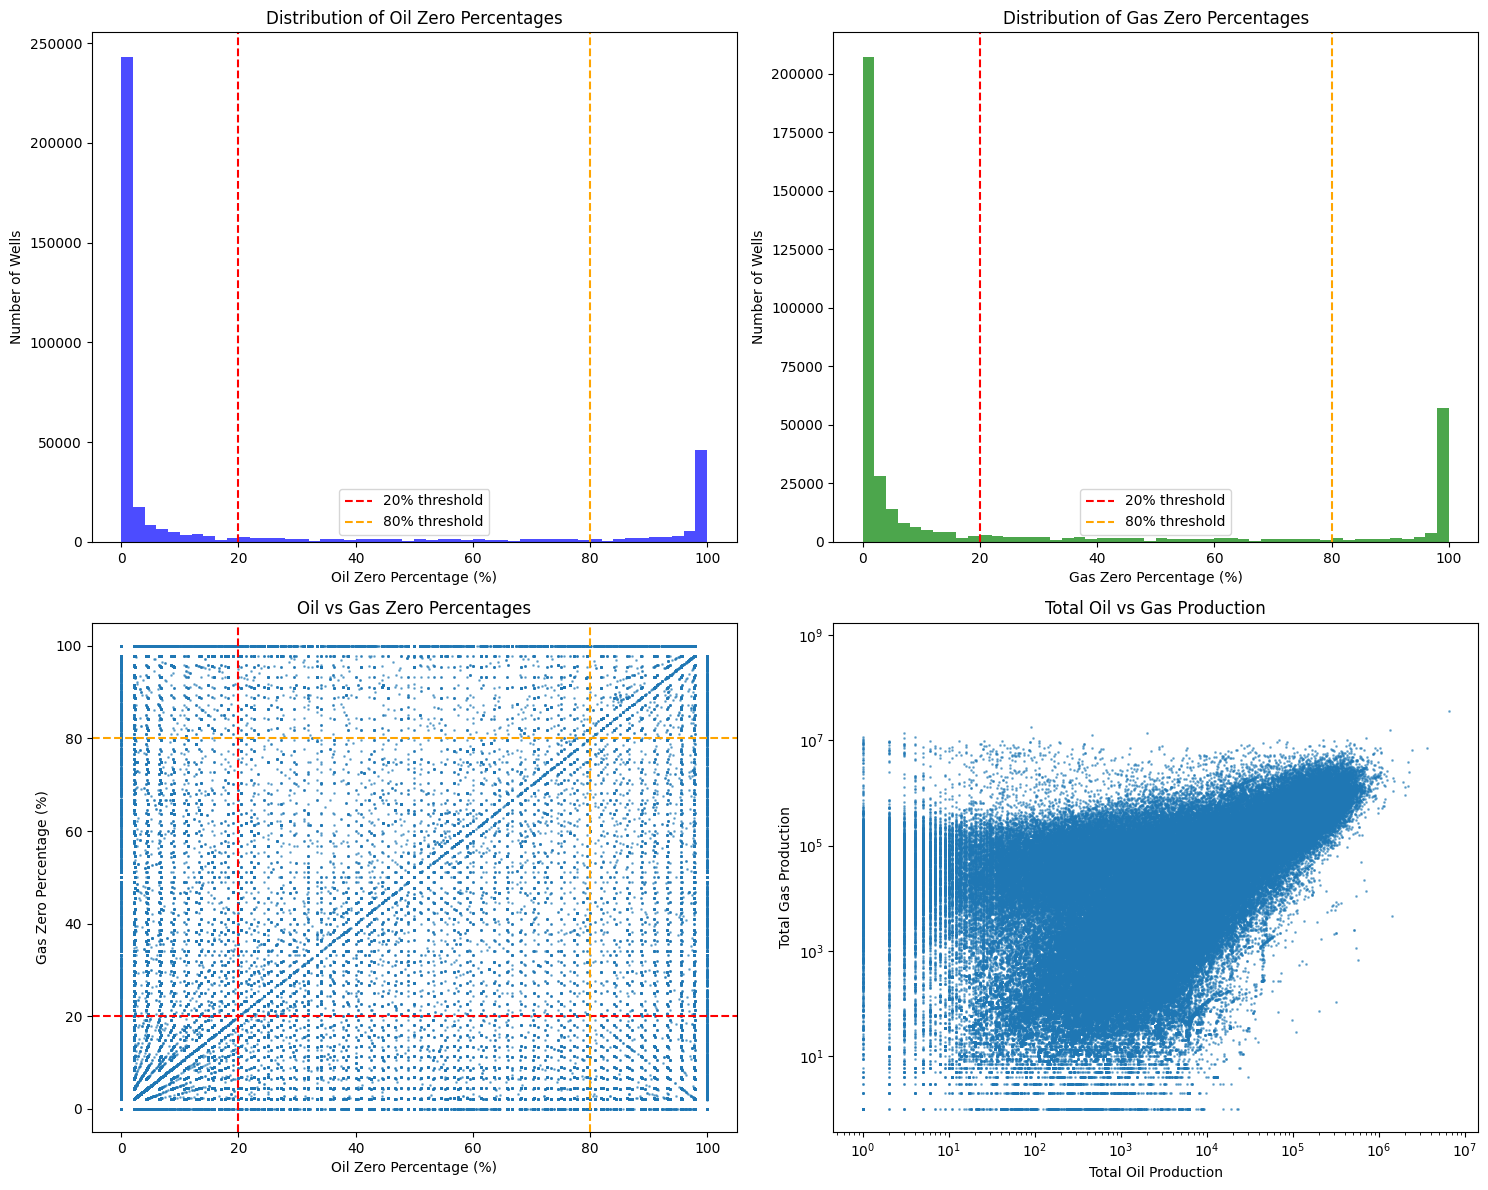

Oil Zero Percentage Statistics:
count   399913.00
mean        21.85
std         37.12
min          0.00
25%          0.00
50%          0.00
75%         25.53
max        100.00
Name: oil_zero_pct, dtype: float64

Gas Zero Percentage Statistics:
count   399913.00
mean        24.14
std         37.98
min          0.00
25%          0.00
50%          0.00
75%         36.84
max        100.00
Name: gas_zero_pct, dtype: float64


,api_no_10,oil_total,oil_months,oil_zeros,gas_total,gas_months,gas_zeros,oil_zero_pct,gas_zero_pct
0,4200100001,4480.00,45,0,1270.00,45,0,0.00,0.00
1,4200100043,2373.00,44,4,50235.00,44,1,9.09,2.27
2,4200100045,273.00,44,11,0.00,44,44,25.00,100.00
3,4200100046,529.00,45,0,0.00,45,45,0.00,100.00
4,4200100070,3567.00,45,0,296871.00,45,0,0.00,0.00
...,...,...,...,...,...,...,...,...,...
399908,4250780076,276.00,47,25,0.00,47,47,53.19,100.00
399909,4250780078,136.00,42,0,0.00,42,42,0.00,100.00
399910,4250780182,983.00,45,0,393.00,45,0,0.00,0.00
399911,4250780246,2.00,44,42,0.00,44,44,95.45,100.00


In [16]:
visualize_production_patterns(joined_data)

What I'm gathering from this is that my threshold for the oil dominated vs gas dominated class should be around 95 percentile on each side, because that's when the values of one over the other starts to pick up, the middle values are all low. Then the remaining wells are high producing mixed wells and low producing mixed wells:

In [17]:
def classify_well_production_type(joined_data,
                                  oil_threshold_low: float = 5,
                                  oil_threshold_high: float = 95,
                                  gas_threshold_low: float = 5,
                                  gas_threshold_high: float = 95,
                                  productivity_threshold: float = 1_000,
                                  check_coverage: bool = True):
    """
    Adds a column 'Well_Production_Type' that is mutually-exclusive and
    collectively-exhaustive for every API number in joined_data.
    
    Classes
    -------
    1. Oil-Dominant
       • gas_zero_pct >= gas_threshold_high
       • oil_zero_pct  <  oil_threshold_high      (excludes the high-high square)
    
    2. Gas-Dominant
       • oil_zero_pct >= oil_threshold_high
       • gas_zero_pct  <  gas_threshold_high
    
    3. Mixed-Productive
       • (high-high region **OR** both pct < high)
       • total_production > productivity_threshold
    
    4. Mixed-Low-Productive
       • everything that does not satisfy 1-3
       • guarantees collective exhaustiveness
    """

    # ---- well-level summarisation ------------------------------------------
    well_stats = joined_data.groupby('api_no_10').agg({
        'oil_monthly': ['sum', 'count', lambda x: (x == 0).sum()],
        'gas_monthly': ['sum', 'count', lambda x: (x == 0).sum()]
    }).reset_index()

    well_stats.columns = ['api_no_10', 'oil_total', 'oil_months', 'oil_zeros',
                          'gas_total', 'gas_months', 'gas_zeros']

    well_stats['oil_zero_pct'] = (well_stats['oil_zeros'] / well_stats['oil_months'] * 100)
    well_stats['gas_zero_pct'] = (well_stats['gas_zeros'] / well_stats['gas_months'] * 100)
    # crude BOE conversion (6 Mcf ≈ 1 bbl)
    well_stats['total_production'] = well_stats['oil_total'] + well_stats['gas_total'] * 0.006

    # ---- classification logic ----------------------------------------------
    def classify_well(row):
        oz, gz, prod = row['oil_zero_pct'], row['gas_zero_pct'], row['total_production']

        # 1) High–high square FIRST (otherwise it would be caught by 1 or 2)
        if (oz >= oil_threshold_high) and (gz >= gas_threshold_high):
            return 'Mixed-Productive' if prod > productivity_threshold else 'Mixed-Low-Productive'

        # 2) Oil-Dominant (gas mostly zero, oil not in the high-high corner)
        if (gz >= gas_threshold_high) and (oz < oil_threshold_high):
            return 'Oil-Dominant'

        # 3) Gas-Dominant (oil mostly zero, gas not in the high-high corner)
        if (oz >= oil_threshold_high) and (gz < gas_threshold_high):
            return 'Gas-Dominant'

        # 4) Remaining wells: both pct below the "high" cut-off
        return 'Mixed-Productive' if prod > productivity_threshold else 'Mixed-Low-Productive'

    well_stats['Well_Production_Type'] = well_stats.apply(classify_well, axis=1)

    # ---- merge back & optional coverage check ------------------------------
    joined_data = joined_data.merge(
        well_stats[['api_no_10', 'Well_Production_Type']],
        on='api_no_10', how='left'
    )

    if check_coverage:
        unclassified = joined_data['Well_Production_Type'].isna().sum()
        if unclassified == 0:
            print("✅  All wells have been classified (collectively exhaustive).")
        else:
            print(f"⚠️  {unclassified:,} rows were not classified — investigate!")

    # quick distribution report
    print("\nWell Production Type counts:")
    display(joined_data['Well_Production_Type'].value_counts())

    return joined_data

In [18]:
joined_data = classify_well_production_type(joined_data)
joined_data.info()

✅  All wells have been classified (collectively exhaustive).

Well Production Type counts:


Well_Production_Type
Mixed-Productive        8517765
Mixed-Low-Productive    3309125
Oil-Dominant            2541928
Gas-Dominant            2234972
Name: count, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 25 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   operator_name           object        
 8   lon_surface             float64       
 9   lat_surface             float64       
 10  lon_bottomhole          float64       
 11  lat_bottomhole          float64       
 12  elevation_ground        object        
 13  depth_tvd               float64       
 14  measured_depth          float64       
 15  horizontal_length       float64       
 16  wellbore_type           object        
 17  field_name              object        
 18  

### Decline Curve Analysis <a id="Decline"></a>

In [19]:
def arps_decline_models():
    """
    Define Arps decline curve models for unconventional and conventional wells.
    Based on trusted research from Texas A&M, West Virginia University, and Penn State.
    """
    
    def exponential_decline(t, qi, Di):
        """
        Exponential decline model (b=0) - typically for conventional wells
        q(t) = qi * exp(-Di * t)
        """
        return qi * np.exp(-Di * t)
    
    def hyperbolic_decline(t, qi, Di, b):
        """
        Hyperbolic decline model (0 < b < 1) - for unconventional wells
        q(t) = qi / (1 + b * Di * t)^(1/b)
        """
        return qi / np.power(1 + b * Di * t, 1/b)
    
    def harmonic_decline(t, qi, Di):
        """
        Harmonic decline model (b=1) - for some unconventional wells
        q(t) = qi / (1 + Di * t)
        """
        return qi / (1 + Di * t)
    
    def power_law_exponential(t, qi, Di, n):
        """
        Power Law Exponential (PLE) model for unconventional wells
        Developed by Ilk et al. (2008) to overcome Arps limitations
        q(t) = qi * exp(-Di * t^n)
        """
        return qi * np.exp(-Di * np.power(t, n))
    
    return {
        'exponential': exponential_decline,
        'hyperbolic': hyperbolic_decline, 
        'harmonic': harmonic_decline,
        'ple': power_law_exponential
    }

In [23]:
def analyze_decline_curves(joined_data, min_production_months=3):
    """
    Performs decline curve analysis and classification based on production profiles.
    
    References:
    - Sherman, B.C. (2019). Multi-Segment Arps Hyperbolic Decline Model, Texas A&M
    - AlQattan, A.W. (2020). Decline Curve Analysis for Unconventional Reservoirs, WVU
    - Penn State EME 801: Production Decline for Shale Gas Wells
    """
    
    models = arps_decline_models()
    results = []
    
    # Get wells with sufficient production history
    well_months = joined_data.groupby('api_no_10')['Production_Age'].max()
    valid_wells = well_months[well_months >= min_production_months].index
    
    print(f"Analyzing {len(valid_wells)} wells with {min_production_months}+ months of data...")
    
    for well_api in valid_wells[:1000]:  # Limit for demonstration
        well_data = joined_data[joined_data['api_no_10'] == well_api].copy()
        well_data = well_data.sort_values('Production_Age')
        
        # Prepare data
        t = well_data['Production_Age'].values
        oil_rate = well_data['oil_monthly'].values
        gas_rate = well_data['gas_monthly'].values
        
        # Skip wells with insufficient non-zero production
        if np.sum(oil_rate > 0) < 3 and np.sum(gas_rate > 0) < 3:
            continue
            
        # Analyze oil production if significant
        oil_r2_best = 0
        oil_model_best = 'unknown'
        
        if np.sum(oil_rate > 0) >= 3:
            oil_positive = oil_rate > 0
            t_oil = t[oil_positive]
            q_oil = oil_rate[oil_positive]
            
            # Try different models
            for model_name, model_func in models.items():
                try:
                    if model_name == 'exponential':
                        popt, _ = curve_fit(model_func, t_oil, q_oil, 
                                          bounds=([0, 0], [np.inf, 1]))
                        predicted = model_func(t_oil, *popt)
                    elif model_name == 'hyperbolic':
                        popt, _ = curve_fit(model_func, t_oil, q_oil,
                                          bounds=([0, 0, 0], [np.inf, 1, 0.99]))
                        predicted = model_func(t_oil, *popt)
                    elif model_name == 'harmonic':
                        popt, _ = curve_fit(model_func, t_oil, q_oil,
                                          bounds=([0, 0], [np.inf, 1]))
                        predicted = model_func(t_oil, *popt)
                    elif model_name == 'ple':
                        popt, _ = curve_fit(model_func, t_oil, q_oil,
                                          bounds=([0, 0, 0], [np.inf, 1, 2]))
                        predicted = model_func(t_oil, *popt)
                    
                    r2 = 1 - np.sum((q_oil - predicted)**2) / np.sum((q_oil - np.mean(q_oil))**2)
                    
                    if r2 > oil_r2_best:
                        oil_r2_best = r2
                        oil_model_best = model_name
                        
                except:
                    continue
        
        # Analyze gas production similarly
        gas_r2_best = 0
        gas_model_best = 'unknown'
        
        if np.sum(gas_rate > 0) >= 3:
            gas_positive = gas_rate > 0
            t_gas = t[gas_positive]
            q_gas = gas_rate[gas_positive]
            
            for model_name, model_func in models.items():
                try:
                    if model_name == 'exponential':
                        popt, _ = curve_fit(model_func, t_gas, q_gas,
                                          bounds=([0, 0], [np.inf, 1]))
                        predicted = model_func(t_gas, *popt)
                    elif model_name == 'hyperbolic':
                        popt, _ = curve_fit(model_func, t_gas, q_gas,
                                          bounds=([0, 0, 0], [np.inf, 1, 0.99]))
                        predicted = model_func(t_gas, *popt)
                    elif model_name == 'harmonic':
                        popt, _ = curve_fit(model_func, t_gas, q_gas,
                                          bounds=([0, 0], [np.inf, 1]))
                        predicted = model_func(t_gas, *popt)
                    elif model_name == 'ple':
                        popt, _ = curve_fit(model_func, t_gas, q_gas,
                                          bounds=([0, 0, 0], [np.inf, 1, 2]))
                        predicted = model_func(t_gas, *popt)
                    
                    r2 = 1 - np.sum((q_gas - predicted)**2) / np.sum((q_gas - np.mean(q_gas))**2)
                    
                    if r2 > gas_r2_best:
                        gas_r2_best = r2
                        gas_model_best = model_name
                        
                except:
                    continue
        
        # Classify well type based on decline patterns
        wellbore_type = well_data['wellbore_type'].iloc[0] if 'wellbore_type' in well_data.columns else 'Unknown'
        
        if (oil_model_best in ['hyperbolic', 'harmonic', 'ple'] or 
            gas_model_best in ['hyperbolic', 'harmonic', 'ple']):
            decline_classification = 'Unconventional'
        elif (oil_model_best == 'exponential' or gas_model_best == 'exponential'):
            decline_classification = 'Conventional'
        else:
            decline_classification = 'Unknown'
        
        results.append({
            'api_no_10': well_api,
            'oil_decline_model': oil_model_best,
            'gas_decline_model': gas_model_best,
            'oil_r2': oil_r2_best,
            'gas_r2': gas_r2_best,
            'decline_classification': decline_classification,
            'wellbore_type': wellbore_type
        })
    
    # Create results dataframe
    decline_results = pd.DataFrame(results)
    
    # Merge back to main dataset
    joined_data = joined_data.merge(
        decline_results[['api_no_10', 'decline_classification']], 
        on='api_no_10', how='left'
    )
    
    # Fill missing values
    joined_data['decline_classification'] = joined_data['decline_classification'].fillna('Unknown')
    
    print("Decline Curve Classification Results:")
    print(joined_data['decline_classification'].value_counts())
    
    return joined_data

In [24]:
joined_data = analyze_decline_curves(joined_data)
joined_data.info()

Analyzing 396727 wells with 3+ months of data...


C:\Users\Owner\AppData\Local\Temp\ipykernel_10052\3786273752.py:62: RuntimeWarning: divide by zero encountered in scalar divide
  r2 = 1 - np.sum((q_oil - predicted)**2) / np.sum((q_oil - np.mean(q_oil))**2)
C:\Users\Owner\AppData\Local\Temp\ipykernel_10052\3786273752.py:50: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(model_func, t_oil, q_oil,
C:\Users\Owner\AppData\Local\Temp\ipykernel_10052\3786273752.py:58: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(model_func, t_oil, q_oil,
C:\Users\Owner\AppData\Local\Temp\ipykernel_10052\3786273752.py:87: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(model_func, t_gas, q_gas,
C:\Users\Owner\AppData\Local\Temp\ipykernel_10052\3786273752.py:95: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(model_func, t_gas, q_gas,
C:\Users\Owner\AppData\Local\Temp\ipykernel_10052\37

Decline Curve Classification Results:
decline_classification
Unknown           16569878
Unconventional       33912
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 26 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   operator_name           object        
 8   lon_surface             float64       
 9   lat_surface             float64       
 10  lon_bottomhole          float64       
 11  lat_bottomhole          float64       
 12  elevation_ground        object        
 13  depth_tvd               float64       
 14  measured_depth          float64    

In [26]:
joined_data.groupby('api_no_10')['decline_classification'].value_counts()

api_no_10   decline_classification
4200100001  Unconventional            45
4200100043  Unknown                   44
4200100045  Unconventional            44
4200100046  Unconventional            45
4200100070  Unconventional            45
                                      ..
4250780076  Unknown                   47
4250780078  Unknown                   42
4250780182  Unknown                   45
4250780246  Unknown                   44
4250780278  Unknown                   44
Name: count, Length: 399913, dtype: int64

In [28]:
joined_data.drop('decline_classification', axis=1, inplace=True)
joined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 25 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   operator_name           object        
 8   lon_surface             float64       
 9   lat_surface             float64       
 10  lon_bottomhole          float64       
 11  lat_bottomhole          float64       
 12  elevation_ground        object        
 13  depth_tvd               float64       
 14  measured_depth          float64       
 15  horizontal_length       float64       
 16  wellbore_type           object        
 17  field_name              object        
 18  

Unfortunately that function will take way too long to classify as many wells as I actually need classified, so we'll have to come up with another function that cuts corners (so much curve fitting and parameter fitting is unnecessary). We're going to linearize the arps models as much as possible for fast computation, and in the future with more time I'd like try a more complex solution that takes into account more precise arps model fitting combined with a consciousness of the underlying physics.

In [34]:
from sklearn.linear_model import LinearRegression
import concurrent.futures

def linear_regression(x, y):
    if len(x) < 2:
        return None, None, -np.inf
    model = LinearRegression().fit(x.reshape(-1, 1), y)
    slope = model.coef_[0]
    intercept = model.intercept_
    r2 = model.score(x.reshape(-1, 1), y)
    return slope, intercept, r2

def fit_exponential(t, q):
    mask = (q > 0) & (t >= 0)
    if np.sum(mask) < 2:
        return None, None, -np.inf
    t_fit = t[mask]
    ln_q = np.log(q[mask])
    slope, intercept, r2 = linear_regression(t_fit, ln_q)
    if slope is None:
        return None, None, -np.inf
    Di = -slope
    qi = np.exp(intercept)
    return qi, Di, r2

def fit_harmonic(t, q):
    mask = (q > 0) & (t >= 0)
    if np.sum(mask) < 2:
        return None, None, -np.inf
    t_fit = t[mask]
    inv_q = 1 / q[mask]
    slope, intercept, r2 = linear_regression(t_fit, inv_q)
    if slope is None or intercept == 0:
        return None, None, -np.inf
    Di = slope
    qi = 1 / intercept
    return qi, Di, r2

def fit_hyperbolic(t, q, b_values=np.linspace(0.01, 0.99, 25)):
    mask = (q > 0) & (t >= 0)
    if np.sum(mask) < 2:
        return None, None, None, -np.inf
    t_fit = t[mask]
    q_fit = q[mask]
    ln_q = np.log(q_fit)
    best_r2 = -np.inf
    best_params = (None, None, None)
    for b in b_values:
        x = np.log(1 + b * t_fit)
        slope, intercept, r2 = linear_regression(x, ln_q)
        if slope is None:
            continue
        if abs(slope + 1/b) > 0.5:
            continue
        qi = np.exp(intercept)
        Di = b * (np.exp(-b * slope) - 1)
        if r2 > best_r2:
            best_r2 = r2
            best_params = (qi, Di, b)
    return (*best_params, best_r2)

def process_single_well(args):
    well_api, well_data = args
    well_data = well_data.sort_values('Production_Age')
    t = well_data['Production_Age'].values
    oil_rate = well_data['oil_monthly'].values
    gas_rate = well_data['gas_monthly'].values

    if np.sum(oil_rate > 0) < 3 and np.sum(gas_rate > 0) < 3:
        return {
            'api_no_10': well_api,
            'oil_decline_model': 'unknown',
            'gas_decline_model': 'unknown',
            'oil_r2': -np.inf,
            'gas_r2': -np.inf,
            'decline_classification': 'Unknown',
            'wellbore_type': well_data['wellbore_type'].iloc[0] if 'wellbore_type' in well_data.columns else 'Unknown'
        }

    # Oil
    oil_models = {}
    if np.sum(oil_rate > 0) >= 3:
        qi_exp, Di_exp, r2_exp = fit_exponential(t, oil_rate)
        qi_harm, Di_harm, r2_harm = fit_harmonic(t, oil_rate)
        qi_hyp, Di_hyp, b_hyp, r2_hyp = fit_hyperbolic(t, oil_rate)
        oil_models = {
            'exponential': r2_exp,
            'harmonic': r2_harm,
            'hyperbolic': r2_hyp
        }
        oil_model_best = max(oil_models, key=oil_models.get)
        oil_r2_best = oil_models[oil_model_best]
    else:
        oil_model_best = 'unknown'
        oil_r2_best = -np.inf

    # Gas
    gas_models = {}
    if np.sum(gas_rate > 0) >= 3:
        qi_exp, Di_exp, r2_exp = fit_exponential(t, gas_rate)
        qi_harm, Di_harm, r2_harm = fit_harmonic(t, gas_rate)
        qi_hyp, Di_hyp, b_hyp, r2_hyp = fit_hyperbolic(t, gas_rate)
        gas_models = {
            'exponential': r2_exp,
            'harmonic': r2_harm,
            'hyperbolic': r2_hyp
        }
        gas_model_best = max(gas_models, key=gas_models.get)
        gas_r2_best = gas_models[gas_model_best]
    else:
        gas_model_best = 'unknown'
        gas_r2_best = -np.inf

    if (oil_model_best in ['hyperbolic', 'harmonic'] or
        gas_model_best in ['hyperbolic', 'harmonic']):
        decline_classification = 'Unconventional'
    elif (oil_model_best == 'exponential' or gas_model_best == 'exponential'):
        decline_classification = 'Conventional'
    else:
        decline_classification = 'Unknown'

    return {
        'api_no_10': well_api,
        'oil_decline_model': oil_model_best,
        'gas_decline_model': gas_model_best,
        'oil_r2': oil_r2_best,
        'gas_r2': gas_r2_best,
        'decline_classification': decline_classification,
        'wellbore_type': well_data['wellbore_type'].iloc[0] if 'wellbore_type' in well_data.columns else 'Unknown'
    }

def analyze_decline_curves(joined_data, min_production_months=3):
    well_months = joined_data.groupby('api_no_10')['Production_Age'].max()
    valid_wells = well_months[well_months >= min_production_months].index
    print(f"Analyzing {len(valid_wells)} wells with {min_production_months}+ months of data...")

    # Pre-group data for each well
    grouped = dict(tuple(joined_data[joined_data['api_no_10'].isin(valid_wells)].groupby('api_no_10')))

    # Prepare arguments for parallel execution
    args = list(grouped.items())

    # Use all available CPU cores
    with concurrent.futures.ProcessPoolExecutor() as executor:
        results = list(executor.map(process_single_well, args))

    decline_results = pd.DataFrame(results)
    joined_data = joined_data.merge(
        decline_results[['api_no_10', 'decline_classification']],
        on='api_no_10', how='left'
    )
    joined_data['decline_classification'] = joined_data['decline_classification'].fillna('Unknown')
    print("Decline Curve Classification Results:")
    print(joined_data['decline_classification'].value_counts())
    return joined_data

In [35]:
joined_data = analyze_decline_curves(joined_data)
joined_data.info()

Analyzing 396727 wells with 3+ months of data...


Exception in thread Thread-4:
Traceback (most recent call last):
  File "C:\Users\Owner\anaconda3\envs\hyperion-forecasting\Lib\threading.py", line 1045, in _bootstrap_inner
    self.run()
  File "C:\Users\Owner\anaconda3\envs\hyperion-forecasting\Lib\concurrent\futures\process.py", line 347, in run
    self.terminate_broken(cause)
  File "C:\Users\Owner\anaconda3\envs\hyperion-forecasting\Lib\concurrent\futures\process.py", line 499, in terminate_broken
    work_item.future.set_exception(bpe)
  File "C:\Users\Owner\anaconda3\envs\hyperion-forecasting\Lib\concurrent\futures\_base.py", line 559, in set_exception
    raise InvalidStateError('{}: {!r}'.format(self._state, self))
concurrent.futures._base.InvalidStateError: CANCELLED: <Future at 0x2d12a85e1d0 state=cancelled>


BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [ ]:
joined_data.to_parquet('../data/feature_data_1.parquet')

Let's try this again with some changes for speedup:

In [3]:
temp_file_paths = {
    'joined_data': '../data/feature_data_1.parquet'
}

temp_file_paths

{'joined_data': '../data/feature_data_1.parquet'}

In [4]:
joined_data = load_parquet_datasets(temp_file_paths)['joined_data']

joined_data.info()

  Successfully loaded joined_data with pandas
  Shape: (16603790, 25)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 25 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   operator_name           object        
 8   lon_surface             float64       
 9   lat_surface             float64       
 10  lon_bottomhole          float64       
 11  lat_bottomhole          float64       
 12  elevation_ground        object        
 13  depth_tvd               float64       
 14  measured_depth          float64       
 15  horizontal_length       float64       
 16  wellbore_type     

In [10]:
# ✅ 1. Use compiled numpy linear regression
def simple_linreg(x, y):
    if len(x) < 2:
        return None, None, -np.inf
    X = np.vstack([x, np.ones_like(x)]).T
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    y_hat = X @ beta
    residuals = y - y_hat
    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot > 0 else -np.inf
    return beta[0], beta[1], r2

# ✅ 2. Update the decline functions to use it
def fit_exponential(t, q):
    mask = (q > 0) & (t >= 0)
    if np.sum(mask) < 2:
        return None, None, -np.inf
    t_fit = t[mask]
    ln_q = np.log(q[mask])
    slope, intercept, r2 = simple_linreg(t_fit, ln_q)
    if slope is None:
        return None, None, -np.inf
    Di = -slope
    qi = np.exp(intercept)
    return qi, Di, r2

def fit_harmonic(t, q):
    mask = (q > 0) & (t >= 0)
    if np.sum(mask) < 2:
        return None, None, -np.inf
    t_fit = t[mask]
    inv_q = 1 / q[mask]
    slope, intercept, r2 = simple_linreg(t_fit, inv_q)
    if slope is None or intercept == 0:
        return None, None, -np.inf
    Di = slope
    qi = 1 / intercept
    return qi, Di, r2

def fit_hyperbolic(t, q, b_values=np.linspace(0.01, 0.99, 25)):
    mask = (q > 0) & (t >= 0)
    if np.sum(mask) < 2:
        return None, None, None, -np.inf
    t_fit = t[mask]
    q_fit = q[mask]
    ln_q = np.log(q_fit)
    best_r2 = -np.inf
    best_params = (None, None, None)
    for b in b_values:
        x = np.log(1 + b * t_fit)
        slope, intercept, r2 = simple_linreg(x, ln_q)
        if slope is None:
            continue
        if abs(slope + 1/b) > 0.5:
            continue
        qi = np.exp(intercept)
        Di = b * (np.exp(-b * slope) - 1)
        if r2 > best_r2:
            best_r2 = r2
            best_params = (qi, Di, b)
    return (*best_params, best_r2)

# ✅ 3. Minimal, raw input
def process_single_well(args):
    well_api, t, oil_rate, gas_rate, wellbore_type = args

    if np.sum(oil_rate > 0) < 3 and np.sum(gas_rate > 0) < 3:
        return {
            'api_no_10': well_api,
            'oil_decline_model': 'unknown',
            'gas_decline_model': 'unknown',
            'oil_r2': -np.inf,
            'gas_r2': -np.inf,
            'decline_classification': 'Unknown',
            'wellbore_type': wellbore_type
        }

    # Oil
    oil_models = {}
    if np.sum(oil_rate > 0) >= 3:
        qi_exp, Di_exp, r2_exp = fit_exponential(t, oil_rate)
        qi_harm, Di_harm, r2_harm = fit_harmonic(t, oil_rate)
        qi_hyp, Di_hyp, b_hyp, r2_hyp = fit_hyperbolic(t, oil_rate)
        oil_models = {'exponential': r2_exp, 'harmonic': r2_harm, 'hyperbolic': r2_hyp}
        oil_model_best = max(oil_models, key=oil_models.get)
        oil_r2_best = oil_models[oil_model_best]
    else:
        oil_model_best = 'unknown'
        oil_r2_best = -np.inf

    # Gas
    gas_models = {}
    if np.sum(gas_rate > 0) >= 3:
        qi_exp, Di_exp, r2_exp = fit_exponential(t, gas_rate)
        qi_harm, Di_harm, r2_harm = fit_harmonic(t, gas_rate)
        qi_hyp, Di_hyp, b_hyp, r2_hyp = fit_hyperbolic(t, gas_rate)
        gas_models = {'exponential': r2_exp, 'harmonic': r2_harm, 'hyperbolic': r2_hyp}
        gas_model_best = max(gas_models, key=gas_models.get)
        gas_r2_best = gas_models[gas_model_best]
    else:
        gas_model_best = 'unknown'
        gas_r2_best = -np.inf

    if oil_model_best in ['hyperbolic', 'harmonic'] or gas_model_best in ['hyperbolic', 'harmonic']:
        decline_classification = 'Unconventional'
    elif oil_model_best == 'exponential' or gas_model_best == 'exponential':
        decline_classification = 'Conventional'
    else:
        decline_classification = 'Unknown'

    return {
        'api_no_10': well_api,
        'oil_decline_model': oil_model_best,
        'gas_decline_model': gas_model_best,
        'oil_r2': oil_r2_best,
        'gas_r2': gas_r2_best,
        'decline_classification': decline_classification,
        'wellbore_type': wellbore_type
    }

# ✅ 4. Process batch for parallel map
def process_batch(batch):
    return [process_single_well(args) for args in batch]

# ✅ 5. Improved main runner with batching
def analyze_decline_curves(joined_data, min_production_months=3, batch_size=100, log_every_batches=10):
    well_months = joined_data.groupby('api_no_10')['Production_Age'].max()
    valid_wells = well_months[well_months >= min_production_months].index
    print(f"Analyzing {len(valid_wells)} wells with {min_production_months}+ months of data...")

    grouped = joined_data[joined_data['api_no_10'].isin(valid_wells)].groupby('api_no_10')

    args = []
    for well_api, df in grouped:
        df = df.sort_values('Production_Age')
        t = df['Production_Age'].values
        oil_rate = df['oil_monthly'].values
        gas_rate = df['gas_monthly'].values
        wellbore_type = df['wellbore_type'].iloc[0] if 'wellbore_type' in df.columns else 'Unknown'
        args.append((well_api, t, oil_rate, gas_rate, wellbore_type))

    batches = [args[i:i + batch_size] for i in range(0, len(args), batch_size)]

    t_start = time.time()
    results = []

    with concurrent.futures.ProcessPoolExecutor() as executor:
        for idx, batch_result in enumerate(executor.map(process_batch, batches), 1):
            results.extend(batch_result)
            if idx % log_every_batches == 0:
                elapsed = time.time() - t_start
                wells_done = idx * batch_size
                print(f"[{time.strftime('%H:%M:%S')}] Processed ~{wells_done} wells ({idx} batches) in {elapsed:.1f}s")

    decline_results = pd.DataFrame(results)
    joined_data = joined_data.merge(
        decline_results[['api_no_10', 'decline_classification']],
        on='api_no_10', how='left'
    )
    joined_data['decline_classification'] = joined_data['decline_classification'].fillna('Unknown')
    print("\nDecline Curve Classification Results:")
    print(joined_data['decline_classification'].value_counts())
    return joined_data

In [11]:
joined_data = analyze_decline_curves(joined_data)
joined_data.info()

Analyzing 396727 wells with 3+ months of data...


OSError: handle is closed

None of these functions are working because the limits of my own RAM, computer cores, etc. cannot run these functions fast enough to avoid errors or achieve realistic results (or some other complicated errors I'm not even aware of), so I just had to create my own custom version of the GPUFIT library to run vectorized curve fitting operations to figure out these production profiles which are SUCH an important feature for predicting well decline. As you can see from the imports it was difficult to even get this version of the library to import or work at all, so it took a long time, but I'm anxious to see if it worked or not.

In [5]:
def pad_sequences(sequences, fill_value=0.0):
    """Pad list of 1D arrays to the same length."""
    maxlen = max(len(seq) for seq in sequences)
    padded = np.full((len(sequences), maxlen), fill_value, dtype=np.float32)
    for i, seq in enumerate(sequences):
        padded[i, :len(seq)] = seq
    return padded

def gpu_arps_complete(joined, min_months=3):
    """
    GPU-accelerated decline curve analysis with nearly full Arps model support.
    """
    # Pre-filter wells
    last = joined.groupby('api_no_10')['Production_Age'].max()
    keep = last[last >= min_months].index
    grp = joined[joined.api_no_10.isin(keep)].groupby('api_no_10')

    # Build stacks
    t_s, oil_s, gas_s, apis = [], [], [], []
    for api, g in grp:
        t = g.Production_Age.values.astype(np.float32)
        o, ga = g.oil_monthly.values.astype(np.float32), g.gas_monthly.values.astype(np.float32)
        if (o > 0).sum() + (ga > 0).sum() >= 3:
            t_s.append(t); oil_s.append(o); gas_s.append(ga); apis.append(api)

    tstk = pad_sequences(t_s, 0.0)
    ostk = pad_sequences(oil_s, 0.0)
    gstk = pad_sequences(gas_s, 0.0)
    omask, gmask = ostk > 0, gstk > 0
    nw, npnt = tstk.shape

    # Initial parameter guesses
    def make_params(stack, n_params):
        qi = np.nanmedian(np.where(stack > 0, stack, np.nan)[:, :3], 1)
        qi = np.nan_to_num(qi, nan=1.0)
        Di = np.full_like(qi, 0.1)
        if n_params == 2:  # exponential, harmonic
            return np.stack([qi, Di], 1).astype(np.float32)
        else:  # hyperbolic
            b = np.full_like(qi, 0.5)
            return np.stack([qi, Di, b], 1).astype(np.float32)

    # Batch fits for all models
    models = [
        (gf.ModelID.EXPONENTIAL, 2),
        (gf.ModelID.HARMONIC, 2),
        (gf.ModelID.HYPERBOLIC_DECLINE, 3)
    ]

    oil_results = {}
    gas_results = {}

    for model_id, n_params in models:
        oil_params = make_params(ostk, n_params)
        gas_params = make_params(gstk, n_params)
        
        # Fit oil
        oil_fitted, oil_states, oil_chi2, oil_iter, _ = gf.fit(
            ostk, None, model_id, oil_params, 1e-6, 100, None, gf.EstimatorID.LSE, tstk
        )
        
        # Fit gas  
        gas_fitted, gas_states, gas_chi2, gas_iter, _ = gf.fit(
            gstk, None, model_id, gas_params, 1e-6, 100, None, gf.EstimatorID.LSE, tstk
        )
        
        # Calculate R²
        def calc_r2(data, fitted, mask):
            ss_res = ((data - fitted)**2 * mask).sum(1)
            mean_vals = (data * mask).sum(1) / mask.sum(1)
            ss_tot = ((data - mean_vals[:, None])**2 * mask).sum(1)
            return 1 - ss_res / ss_tot
        
        # Generate fitted values (model-specific)
        if model_id == gf.ModelID.EXPONENTIAL:
            oil_fit = oil_fitted[:, 0][:, None] * np.exp(-oil_fitted[:, 1][:, None] * tstk)
            gas_fit = gas_fitted[:, 0][:, None] * np.exp(-gas_fitted[:, 1][:, None] * tstk)
        elif model_id == gf.ModelID.HARMONIC:
            oil_fit = oil_fitted[:, 0][:, None] / (1 + oil_fitted[:, 1][:, None] * tstk)
            gas_fit = gas_fitted[:, 0][:, None] / (1 + gas_fitted[:, 1][:, None] * tstk)
        else:  # HYPERBOLIC_DECLINE
            oil_denom = (1 + oil_fitted[:, 2][:, None] * oil_fitted[:, 1][:, None] * tstk) ** (1/oil_fitted[:, 2][:, None])
            gas_denom = (1 + gas_fitted[:, 2][:, None] * gas_fitted[:, 1][:, None] * tstk) ** (1/gas_fitted[:, 2][:, None])
            oil_fit = oil_fitted[:, 0][:, None] / oil_denom
            gas_fit = gas_fitted[:, 0][:, None] / gas_denom
        
        oil_r2 = calc_r2(ostk, oil_fit, omask)
        gas_r2 = calc_r2(gstk, gas_fit, gmask)
        
        model_name = ['exponential', 'harmonic', 'hyperbolic'][models.index((model_id, n_params))]
        oil_results[model_name] = oil_r2
        gas_results[model_name] = gas_r2

    # Choose best model per well
    oil_models = ['exponential', 'harmonic', 'hyperbolic']
    gas_models = ['exponential', 'harmonic', 'hyperbolic']
    
    oil_r2_array = np.column_stack([oil_results[m] for m in oil_models])
    gas_r2_array = np.column_stack([gas_results[m] for m in gas_models])
    
    oil_best_idx = np.nanargmax(oil_r2_array, 1)
    gas_best_idx = np.nanargmax(gas_r2_array, 1)
    
    oil_best = np.array(oil_models)[oil_best_idx]
    gas_best = np.array(gas_models)[gas_best_idx]
    
    oil_r2_best = oil_r2_array[np.arange(nw), oil_best_idx]
    gas_r2_best = gas_r2_array[np.arange(nw), gas_best_idx]

    # Classify wells
    out = pd.DataFrame({
        'api_no_10': apis,
        'oil_model': oil_best,
        'gas_model': gas_best,
        'oil_r2': oil_r2_best,
        'gas_r2': gas_r2_best
    })
    
    out['decline_class'] = np.where(
        (out.oil_model.isin(['hyperbolic','harmonic']) |
         out.gas_model.isin(['hyperbolic','harmonic'])),
        'Unconventional',
        np.where((out.oil_model=='exponential') | (out.gas_model=='exponential'),
                 'Conventional', 'Unknown')
    )
    
    return joined.merge(out[['api_no_10','decline_class']], on='api_no_10', how='left')

In [6]:
joined_data = gpu_arps_complete(joined_data)
joined_data.info()

AttributeError: type object 'ModelID' has no attribute 'EXPONENTIAL'

In [7]:
help(gf.ModelID)

Help on class ModelID in module pygpufit.gpufit:

class ModelID(builtins.object)
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables
 |  
 |  __weakref__
 |      list of weak references to the object
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  BROWN_DENNIS = 7
 |  
 |  CAUCHY_2D_ELLIPTIC = 4
 |  
 |  FLETCHER_POWELL = 6
 |  
 |  GAUSS_1D = 0
 |  
 |  GAUSS_2D = 1
 |  
 |  GAUSS_2D_ELLIPTIC = 2
 |  
 |  GAUSS_2D_ROTATED = 3
 |  
 |  HYPERBOLIC_DECLINE = 15
 |  
 |  LINEAR_1D = 5
 |  
 |  SPLINE_1D = 8
 |  
 |  SPLINE_2D = 9
 |  
 |  SPLINE_3D = 10
 |  
 |  SPLINE_3D_MULTICHANNEL = 11
 |  
 |  SPLINE_3D_PHASE_MULTICHANNEL = 12



Turns out that I needed to add two more models to the library which I was told it already had (and maybe it does have them in some versions). With all three of the arps models that I most need, let's get to curve fitting:

In [7]:
def pad_sequences(sequences, fill_value=0.0):
    maxlen = max(len(seq) for seq in sequences)
    padded = np.full((len(sequences), maxlen), fill_value, dtype=np.float32)
    for i, seq in enumerate(sequences):
        padded[i, :len(seq)] = seq
    return padded

def gpu_arps_complete(joined, min_months=3):
    # Pre-filter wells
    last = joined.groupby('api_no_10')['Production_Age'].max()
    keep = last[last >= min_months].index
    grp = joined[joined.api_no_10.isin(keep)].groupby('api_no_10')

    t_s, oil_s, gas_s, apis = [], [], [], []
    for api, g in grp:
        t = g.Production_Age.values.astype(np.float32)
        o, ga = g.oil_monthly.values.astype(np.float32), g.gas_monthly.values.astype(np.float32)
        if ((o > 0).sum() + (ga > 0).sum()) >= 3:
            t_s.append(t)
            oil_s.append(o)
            gas_s.append(ga)
            apis.append(api)

    tstk = pad_sequences(t_s, 0.0)
    ostk = pad_sequences(oil_s, 0.0)
    gstk = pad_sequences(gas_s, 0.0)
    omask, gmask = ostk > 0, gstk > 0
    nw, npnt = tstk.shape

    def make_params(stack, n_params):
        # Avoid all-NaN slices
        qi = np.nanmedian(np.where(stack > 0, stack, np.nan)[:, :3], 1)
        qi = np.nan_to_num(qi, nan=1.0)
        Di = np.full_like(qi, 0.1)
        if n_params == 2:
            return np.stack([qi, Di], 1).astype(np.float32)
        else:
            b = np.full_like(qi, 0.5)
            b = np.clip(b, 1e-4, 2)  # avoid zero/negative exponents
            return np.stack([qi, Di, b], 1).astype(np.float32)

    models = [
        (gf.ModelID.EXPONENTIAL_DECLINE, 2),
        (gf.ModelID.HARMONIC_DECLINE, 2),
        (gf.ModelID.HYPERBOLIC_DECLINE, 3)
    ]
    oil_results, gas_results = {}, {}

    for model_id, n_params in models:
        oil_params = make_params(ostk, n_params)
        gas_params = make_params(gstk, n_params)

        oil_fitted, *_ = gf.fit(ostk, None, model_id, oil_params, 1e-6, 100, None, gf.EstimatorID.LSE, tstk)
        gas_fitted, *_ = gf.fit(gstk, None, model_id, gas_params, 1e-6, 100, None, gf.EstimatorID.LSE, tstk)

        def calc_r2(data, fitted, mask):
            # Avoid divide-by-zero: set denominator to 1 where mask.sum(1)==0
            mask_sum = mask.sum(1)
            mask_sum[mask_sum == 0] = 1
            mean_vals = (data * mask).sum(1) / mask_sum
            ss_res = ((data - fitted) ** 2 * mask).sum(1)
            ss_tot = ((data - mean_vals[:, None]) ** 2 * mask).sum(1)
            # Avoid divide-by-zero
            ss_tot[ss_tot == 0] = 1
            r2 = 1 - ss_res / ss_tot
            # Set R² to NaN if mask was all zero (no data)
            r2[mask.sum(1) == 0] = np.nan
            return r2

        # Generate fitted values
        if model_id == gf.ModelID.EXPONENTIAL_DECLINE:
            oil_fit = oil_fitted[:, 0][:, None] * np.exp(-oil_fitted[:, 1][:, None] * tstk)
            gas_fit = gas_fitted[:, 0][:, None] * np.exp(-gas_fitted[:, 1][:, None] * tstk)
        elif model_id == gf.ModelID.HARMONIC_DECLINE:
            oil_fit = oil_fitted[:, 0][:, None] / (1 + oil_fitted[:, 1][:, None] * tstk)
            gas_fit = gas_fitted[:, 0][:, None] / (1 + gas_fitted[:, 1][:, None] * tstk)
        else:  # HYPERBOLIC_DECLINE
            # Avoid divide-by-zero and overflow in power
            b_oil = np.clip(oil_fitted[:, 2], 1e-4, 2)
            b_gas = np.clip(gas_fitted[:, 2], 1e-4, 2)
            oil_denom = (1 + b_oil[:, None] * oil_fitted[:, 1][:, None] * tstk)
            gas_denom = (1 + b_gas[:, None] * gas_fitted[:, 1][:, None] * tstk)
            with np.errstate(divide='ignore', invalid='ignore', over='ignore'):
                oil_fit = oil_fitted[:, 0][:, None] / np.power(oil_denom, 1 / b_oil[:, None])
                gas_fit = gas_fitted[:, 0][:, None] / np.power(gas_denom, 1 / b_gas[:, None])
                # Set any inf or nan fits to zero
                oil_fit[~np.isfinite(oil_fit)] = 0
                gas_fit[~np.isfinite(gas_fit)] = 0

        oil_r2 = calc_r2(ostk, oil_fit, omask)
        gas_r2 = calc_r2(gstk, gas_fit, gmask)

        model_name = ['exponential', 'harmonic', 'hyperbolic'][models.index((model_id, n_params))]
        oil_results[model_name] = oil_r2
        gas_results[model_name] = gas_r2

    # Stack R² arrays and handle all-NaN slices
    oil_r2_array = np.column_stack([oil_results[m] for m in ['exponential', 'harmonic', 'hyperbolic']])
    gas_r2_array = np.column_stack([gas_results[m] for m in ['exponential', 'harmonic', 'hyperbolic']])

    # For each well, if all R² are NaN, assign model 'unknown'
    oil_best_idx = np.full(nw, -1, dtype=int)
    gas_best_idx = np.full(nw, -1, dtype=int)
    for i in range(nw):
        if np.all(np.isnan(oil_r2_array[i])):
            oil_best_idx[i] = -1
        else:
            oil_best_idx[i] = np.nanargmax(oil_r2_array[i])
        if np.all(np.isnan(gas_r2_array[i])):
            gas_best_idx[i] = -1
        else:
            gas_best_idx[i] = np.nanargmax(gas_r2_array[i])

    oil_models = ['exponential', 'harmonic', 'hyperbolic']
    gas_models = ['exponential', 'harmonic', 'hyperbolic']
    oil_best = np.array(['unknown'] * nw, dtype=object)
    gas_best = np.array(['unknown'] * nw, dtype=object)
    oil_r2_best = np.full(nw, np.nan)
    gas_r2_best = np.full(nw, np.nan)
    for i in range(nw):
        if oil_best_idx[i] != -1:
            oil_best[i] = oil_models[oil_best_idx[i]]
            oil_r2_best[i] = oil_r2_array[i, oil_best_idx[i]]
        if gas_best_idx[i] != -1:
            gas_best[i] = gas_models[gas_best_idx[i]]
            gas_r2_best[i] = gas_r2_array[i, gas_best_idx[i]]

    out = pd.DataFrame({
        'api_no_10': apis,
        'oil_model': oil_best,
        'gas_model': gas_best,
        'oil_r2': oil_r2_best,
        'gas_r2': gas_r2_best
    })

    out['decline_class'] = np.where(
        (out.oil_model.isin(['hyperbolic', 'harmonic']) |
         out.gas_model.isin(['hyperbolic', 'harmonic'])),
        'Unconventional',
        np.where((out.oil_model == 'exponential') | (out.gas_model == 'exponential'),
                 'Conventional', 'Unknown')
    )

    return joined.merge(out[['api_no_10', 'decline_class']], on='api_no_10', how='left')

In [8]:
joined_data = gpu_arps_complete(joined_data)
joined_data.info()

C:\Users\Owner\AppData\Local\Temp\ipykernel_5896\4050868654.py:32: RuntimeWarning: All-NaN slice encountered
  qi = np.nanmedian(np.where(stack > 0, stack, np.nan)[:, :3], 1)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 26 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   operator_name           object        
 8   lon_surface             float64       
 9   lat_surface             float64       
 10  lon_bottomhole          float64       
 11  lat_bottomhole          float64       
 12  elevation_ground        object        
 13  depth_tvd               float64       
 14  measured_depth          float64       
 15  horizontal_length       float64       
 16  wellbore_type           object        
 17  field_name              object        
 18  

In [9]:
joined_data.to_parquet('../data/feature_data_2.parquet')

I'm just saving the data immediately because I fought hard to get it, and even that function was perilously close to crashing my computer since the operations involved in just getting the data on my gpu taxed my RAM to a point of nearly freezing the computer.

In [10]:
joined_data['decline_class'].value_counts()

decline_class
Unconventional    15946391
Conventional        507869
Name: count, dtype: int64

I'm not sure these values are ideal mainly because I find the lack of ANY unknown values odd; that means basically every well we looked at has some tendency towards conventional or unconventional, but considering how we imputed the best model I suppose it makes some amount of sense. The wells ultimately exist in the context of reservoir which is either relatively conventional or unconventional

Unfortunately, I realized that it would be even better for the model to know precisely which arps curve was best fitting, since that is especially relevant to time series forecasting. So I'm going to run the function one more time but this time have it add ANOTHER column for the best arps function (this will help forecast unconventional wells more precisely).

In [11]:
joined_data.drop('decline_class', axis=1, inplace=True)
joined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 25 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   operator_name           object        
 8   lon_surface             float64       
 9   lat_surface             float64       
 10  lon_bottomhole          float64       
 11  lat_bottomhole          float64       
 12  elevation_ground        object        
 13  depth_tvd               float64       
 14  measured_depth          float64       
 15  horizontal_length       float64       
 16  wellbore_type           object        
 17  field_name              object        
 18  

In [12]:
def pad_sequences(sequences, fill_value=0.0):
    maxlen = max(len(seq) for seq in sequences)
    padded = np.full((len(sequences), maxlen), fill_value, dtype=np.float32)
    for i, seq in enumerate(sequences):
        padded[i, :len(seq)] = seq
    return padded

def gpu_arps_complete(joined, min_months=3):
    # Pre-filter wells
    last = joined.groupby('api_no_10')['Production_Age'].max()
    keep = last[last >= min_months].index
    grp = joined[joined.api_no_10.isin(keep)].groupby('api_no_10')

    t_s, oil_s, gas_s, apis = [], [], [], []
    for api, g in grp:
        t = g.Production_Age.values.astype(np.float32)
        o, ga = g.oil_monthly.values.astype(np.float32), g.gas_monthly.values.astype(np.float32)
        if ((o > 0).sum() + (ga > 0).sum()) >= 3:
            t_s.append(t)
            oil_s.append(o)
            gas_s.append(ga)
            apis.append(api)

    tstk = pad_sequences(t_s, 0.0)
    ostk = pad_sequences(oil_s, 0.0)
    gstk = pad_sequences(gas_s, 0.0)
    omask, gmask = ostk > 0, gstk > 0
    nw, npnt = tstk.shape

    def make_params(stack, n_params):
        qi = np.nanmedian(np.where(stack > 0, stack, np.nan)[:, :3], 1)
        qi = np.nan_to_num(qi, nan=1.0)
        Di = np.full_like(qi, 0.1)
        if n_params == 2:
            return np.stack([qi, Di], 1).astype(np.float32)
        else:
            b = np.full_like(qi, 0.5)
            b = np.clip(b, 1e-4, 2)
            return np.stack([qi, Di, b], 1).astype(np.float32)

    models = [
        (gf.ModelID.EXPONENTIAL_DECLINE, 2),
        (gf.ModelID.HARMONIC_DECLINE, 2),
        (gf.ModelID.HYPERBOLIC_DECLINE, 3)
    ]
    oil_results, gas_results = {}, {}

    for model_id, n_params in models:
        oil_params = make_params(ostk, n_params)
        gas_params = make_params(gstk, n_params)

        oil_fitted, *_ = gf.fit(ostk, None, model_id, oil_params, 1e-6, 100, None, gf.EstimatorID.LSE, tstk)
        gas_fitted, *_ = gf.fit(gstk, None, model_id, gas_params, 1e-6, 100, None, gf.EstimatorID.LSE, tstk)

        def calc_r2(data, fitted, mask):
            mask_sum = mask.sum(1)
            mask_sum[mask_sum == 0] = 1
            mean_vals = (data * mask).sum(1) / mask_sum
            ss_res = ((data - fitted) ** 2 * mask).sum(1)
            ss_tot = ((data - mean_vals[:, None]) ** 2 * mask).sum(1)
            ss_tot[ss_tot == 0] = 1
            r2 = 1 - ss_res / ss_tot
            r2[mask.sum(1) == 0] = np.nan
            return r2

        if model_id == gf.ModelID.EXPONENTIAL_DECLINE:
            oil_fit = oil_fitted[:, 0][:, None] * np.exp(-oil_fitted[:, 1][:, None] * tstk)
            gas_fit = gas_fitted[:, 0][:, None] * np.exp(-gas_fitted[:, 1][:, None] * tstk)
        elif model_id == gf.ModelID.HARMONIC_DECLINE:
            oil_fit = oil_fitted[:, 0][:, None] / (1 + oil_fitted[:, 1][:, None] * tstk)
            gas_fit = gas_fitted[:, 0][:, None] / (1 + gas_fitted[:, 1][:, None] * tstk)
        else:  # HYPERBOLIC_DECLINE
            b_oil = np.clip(oil_fitted[:, 2], 1e-4, 2)
            b_gas = np.clip(gas_fitted[:, 2], 1e-4, 2)
            oil_denom = (1 + b_oil[:, None] * oil_fitted[:, 1][:, None] * tstk)
            gas_denom = (1 + b_gas[:, None] * gas_fitted[:, 1][:, None] * tstk)
            with np.errstate(divide='ignore', invalid='ignore', over='ignore'):
                oil_fit = oil_fitted[:, 0][:, None] / np.power(oil_denom, 1 / b_oil[:, None])
                gas_fit = gas_fitted[:, 0][:, None] / np.power(gas_denom, 1 / b_gas[:, None])
                oil_fit[~np.isfinite(oil_fit)] = 0
                gas_fit[~np.isfinite(gas_fit)] = 0

        oil_r2 = calc_r2(ostk, oil_fit, omask)
        gas_r2 = calc_r2(gstk, gas_fit, gmask)

        model_name = ['exponential', 'harmonic', 'hyperbolic'][models.index((model_id, n_params))]
        oil_results[model_name] = oil_r2
        gas_results[model_name] = gas_r2

    oil_r2_array = np.column_stack([oil_results[m] for m in ['exponential', 'harmonic', 'hyperbolic']])
    gas_r2_array = np.column_stack([gas_results[m] for m in ['exponential', 'harmonic', 'hyperbolic']])

    oil_best_idx = np.full(nw, -1, dtype=int)
    gas_best_idx = np.full(nw, -1, dtype=int)
    for i in range(nw):
        if np.all(np.isnan(oil_r2_array[i])):
            oil_best_idx[i] = -1
        else:
            oil_best_idx[i] = np.nanargmax(oil_r2_array[i])
        if np.all(np.isnan(gas_r2_array[i])):
            gas_best_idx[i] = -1
        else:
            gas_best_idx[i] = np.nanargmax(gas_r2_array[i])

    oil_models = ['exponential', 'harmonic', 'hyperbolic']
    gas_models = ['exponential', 'harmonic', 'hyperbolic']
    oil_best = np.array(['unknown'] * nw, dtype=object)
    gas_best = np.array(['unknown'] * nw, dtype=object)
    oil_r2_best = np.full(nw, np.nan)
    gas_r2_best = np.full(nw, np.nan)
    for i in range(nw):
        if oil_best_idx[i] != -1:
            oil_best[i] = oil_models[oil_best_idx[i]]
            oil_r2_best[i] = oil_r2_array[i, oil_best_idx[i]]
        if gas_best_idx[i] != -1:
            gas_best[i] = gas_models[gas_best_idx[i]]
            gas_r2_best[i] = gas_r2_array[i, gas_best_idx[i]]

    # Choose the best model (oil or gas) for the "arps model" column
    arps_model = []
    for i in range(nw):
        # Prefer oil if both are valid, otherwise gas, otherwise unknown
        if oil_best[i] != 'unknown' and (np.isnan(oil_r2_best[i]) == False):
            arps_model.append(oil_best[i])
        elif gas_best[i] != 'unknown' and (np.isnan(gas_r2_best[i]) == False):
            arps_model.append(gas_best[i])
        else:
            arps_model.append('unknown')

    out = pd.DataFrame({
        'api_no_10': apis,
        'oil_model': oil_best,
        'gas_model': gas_best,
        'oil_r2': oil_r2_best,
        'gas_r2': gas_r2_best,
        'arps model': arps_model
    })

    out['reservoir type'] = np.where(
        (out.oil_model.isin(['hyperbolic', 'harmonic']) |
         out.gas_model.isin(['hyperbolic', 'harmonic'])),
        'Unconventional',
        np.where((out.oil_model == 'exponential') | (out.gas_model == 'exponential'),
                 'Conventional', 'Unknown')
    )

    # Merge both columns into the joined DataFrame
    return joined.merge(out[['api_no_10', 'reservoir type', 'arps model']], on='api_no_10', how='left')

In [13]:
joined_data = gpu_arps_complete(joined_data)
joined_data.info()

C:\Users\Owner\AppData\Local\Temp\ipykernel_5896\3649926741.py:31: RuntimeWarning: All-NaN slice encountered
  qi = np.nanmedian(np.where(stack > 0, stack, np.nan)[:, :3], 1)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 27 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   operator_name           object        
 8   lon_surface             float64       
 9   lat_surface             float64       
 10  lon_bottomhole          float64       
 11  lat_bottomhole          float64       
 12  elevation_ground        object        
 13  depth_tvd               float64       
 14  measured_depth          float64       
 15  horizontal_length       float64       
 16  wellbore_type           object        
 17  field_name              object        
 18  

In [14]:
joined_data.to_parquet('../data/feature_data_2.parquet')

In [15]:
joined_data['reservoir type'].value_counts()

reservoir type
Unconventional    15946391
Conventional        507869
Name: count, dtype: int64

In [16]:
joined_data['arps model'].value_counts()

arps model
harmonic       15134501
exponential      718726
hyperbolic       601033
Name: count, dtype: int64

### Production Status Classification <a id="Status"></a>

Some information on Orphaned Wells, there are state and environmental reasons why Wells shut down for over 12 months are expected to be abandoned: https://www.texastribune.org/2025/05/08/texas-orphan-wells-explained-railroad-commission-abandoned/

We need to classify whether Wells are most likely active, shut-in or abandoned

In [4]:
temp_file_paths = {
    'joined_data': '../data/feature_data_2.parquet'
}

temp_file_paths

{'joined_data': '../data/feature_data_2.parquet'}

In [5]:
joined_data = load_parquet_datasets(temp_file_paths)['joined_data']

joined_data.info()

  Successfully loaded joined_data with pandas
  Shape: (16603790, 27)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 27 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   operator_name           object        
 8   lon_surface             float64       
 9   lat_surface             float64       
 10  lon_bottomhole          float64       
 11  lat_bottomhole          float64       
 12  elevation_ground        object        
 13  depth_tvd               float64       
 14  measured_depth          float64       
 15  horizontal_length       float64       
 16  wellbore_type     

In [6]:
def classify_well_status(joined_data, active_threshold_months=3, shutin_threshold_months=12):
    """
    Classifies wells into Active, Shut-in, or Abandoned based on production patterns.
    
    Based on industry standards:
    - Active: Recent production within last 3 months
    - Shut-in: No recent production but can be reopened (3-12 months)  
    - Abandoned: No production for >12 months (cannot be reopened)
    """
    
    # Calculate months since last production for each well
    current_date = joined_data['date_prod'].max()
    
    last_production = joined_data.groupby('api_no_10').agg({
        'date_prod': 'max',
        'oil_monthly': lambda x: (x > 0).sum(),
        'gas_monthly': lambda x: (x > 0).sum(),
        'Production_Age': 'max'
    }).reset_index()
    
    last_production.columns = ['api_no_10', 'last_prod_date', 'oil_producing_months', 
                              'gas_producing_months', 'total_months']
    
    # Calculate months since last production
    last_production['months_since_last'] = (
        (current_date - last_production['last_prod_date']).dt.days / 30.44
    ).round()
    
    # Calculate production ratios
    last_production['oil_production_ratio'] = (
        last_production['oil_producing_months'] / last_production['total_months']
    )
    last_production['gas_production_ratio'] = (
        last_production['gas_producing_months'] / last_production['total_months']
    )
    
    def classify_status(row):
        months_since = row['months_since_last']
        oil_ratio = row['oil_production_ratio'] 
        gas_ratio = row['gas_production_ratio']
        
        # Active wells
        if months_since <= active_threshold_months:
            return 'Active'
        
        # Shut-in vs Abandoned decision
        elif months_since <= shutin_threshold_months:
            # Wells with good historical production ratios more likely shut-in
            if oil_ratio > 0.5 or gas_ratio > 0.5:
                return 'Shut-in Risk'
            else:
                return 'Abandon Risk'
        
        # Long dormant wells considered abandoned
        else:
            return 'Abandon Risk'
    
    last_production['Production_Status'] = last_production.apply(classify_status, axis=1)
    
    # Merge back to main dataset
    joined_data = joined_data.merge(
        last_production[['api_no_10', 'Production_Status']], 
        on='api_no_10', how='left'
    )
    
    print("Production Status Classification Results:")
    print(joined_data['Production_Status'].value_counts())
    
    return joined_data

In [7]:
joined_data = classify_well_status(joined_data)
joined_data.info()

Production Status Classification Results:
Production_Status
Abandon Risk    15449163
Shut-in Risk     1153307
Active              1320
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 28 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   operator_name           object        
 8   lon_surface             float64       
 9   lat_surface             float64       
 10  lon_bottomhole          float64       
 11  lat_bottomhole          float64       
 12  elevation_ground        object        
 13  depth_tvd               float64       
 14  measured_depth 

In [8]:
joined_data['Production_Status'].value_counts()

Production_Status
Abandon Risk    15449163
Shut-in Risk     1153307
Active              1320
Name: count, dtype: int64

In [11]:
joined_data.groupby('Production_Status')['api_no_10'].nunique()

Production_Status
Abandon Risk    360931
Active               3
Shut-in Risk     38979
Name: api_no_10, dtype: int64

This makes me think that my feature is a bit problematic, I think I could do the same thing but limit the date to within the spike period since there were very few report after that point. Let's try that.

In [12]:
joined_data.drop('Production_Status', axis=1, inplace=True)
joined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 27 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   operator_name           object        
 8   lon_surface             float64       
 9   lat_surface             float64       
 10  lon_bottomhole          float64       
 11  lat_bottomhole          float64       
 12  elevation_ground        object        
 13  depth_tvd               float64       
 14  measured_depth          float64       
 15  horizontal_length       float64       
 16  wellbore_type           object        
 17  field_name              object        
 18  

In [13]:
def classify_well_status(joined_data, active_threshold_months=3, shutin_threshold_months=12):
    """
    Classifies wells into Active, Shut-in, or Abandoned based on production patterns,
    using only production data up to and including November 2024.
    
    - Active: Recent production within last 3 months
    - Shut-in: No recent production but can be reopened (3-12 months)  
    - Abandoned: No production for >12 months (cannot be reopened)

    These are more like risk values that absolutes, since reporting practices are responsible for some missing values as warned in the pdf problem statement
    """
    # Define the last date to consider (November 30, 2024)
    clip_date = pd.Timestamp('2024-11-30')
    
    # Only consider production records up to November 2024
    filtered = joined_data[joined_data['date_prod'] <= clip_date].copy()
    
    # If there are no records before or on November 2024, handle gracefully
    if filtered.empty:
        print("No production records on or before November 2024.")
        joined_data['Production_Status'] = 'Unknown'
        return joined_data

    # Set the analysis "current date" as the max date in the filtered data (should be Nov 2024)
    current_date = filtered['date_prod'].max()
    
    last_production = filtered.groupby('api_no_10').agg({
        'date_prod': 'max',
        'oil_monthly': lambda x: (x > 0).sum(),
        'gas_monthly': lambda x: (x > 0).sum(),
        'Production_Age': 'max'
    }).reset_index()
    
    last_production.columns = ['api_no_10', 'last_prod_date', 'oil_producing_months', 
                              'gas_producing_months', 'total_months']
    
    # Calculate months since last production (relative to November 2024)
    last_production['months_since_last'] = (
        (current_date - last_production['last_prod_date']).dt.days / 30.44
    ).round()
    
    # Calculate production ratios
    last_production['oil_production_ratio'] = (
        last_production['oil_producing_months'] / last_production['total_months']
    )
    last_production['gas_production_ratio'] = (
        last_production['gas_producing_months'] / last_production['total_months']
    )
    
    def classify_status(row):
        months_since = row['months_since_last']
        oil_ratio = row['oil_production_ratio'] 
        gas_ratio = row['gas_production_ratio']
        
        if months_since <= active_threshold_months:
            return 'Active'
        elif months_since <= shutin_threshold_months:
            if oil_ratio > 0.5 or gas_ratio > 0.5:
                return 'Shut-in Risk'
            else:
                return 'Abandon Risk'
        else:
            return 'Abandon Risk'
    
    last_production['Production_Status'] = last_production.apply(classify_status, axis=1)
    
    # Merge back to main dataset
    joined_data = joined_data.merge(
        last_production[['api_no_10', 'Production_Status']], 
        on='api_no_10', how='left'
    )
    
    print("Production Status Classification Results:")
    print(joined_data['Production_Status'].value_counts())
    
    return joined_data

In [14]:
joined_data = classify_well_status(joined_data)
joined_data.info()

Production Status Classification Results:
Production_Status
Active          16000526
Abandon Risk      595420
Shut-in Risk        7844
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 28 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   operator_name           object        
 8   lon_surface             float64       
 9   lat_surface             float64       
 10  lon_bottomhole          float64       
 11  lat_bottomhole          float64       
 12  elevation_ground        object        
 13  depth_tvd               float64       
 14  measured_depth 

In [15]:
joined_data['Production_Status'].value_counts()

Production_Status
Active          16000526
Abandon Risk      595420
Shut-in Risk        7844
Name: count, dtype: int64

Now active is the majority! So it really was mostly a data artifact last time, it's a much more useful feature now

In [16]:
joined_data.groupby('Production_Status')['api_no_10'].nunique()

Production_Status
Abandon Risk     27238
Active          371948
Shut-in Risk       727
Name: api_no_10, dtype: int64

Now that we have all these features in order, we need to take stock of what missing data remains to be imputed. Once we've done that and created a few more sensible features, then we will be ready to forecast.

In [4]:
def comprehensive_data_overview(datasets):
    """
    Provide comprehensive overview of all datasets including data types,
    missing values, and basic statistics.
    
    Args:
        datasets (dict): Dictionary of DataFrames to analyze
    """
    for name, df in datasets.items():
        print(f"\n{'='*60}")
        print(f"DATASET: {name.upper()}")
        print(f"{'='*60}")
        
        # Shape
        print(f"Shape: {df.shape}")
        
        # Column information
        print(f"\nColumn Overview:")
        print(f"{'Column':<25} {'Type':<15} {'Non-Null':<10} {'Unique':<10} {'Missing %':<10}")
        print("-" * 80)
        
        for col in df.columns:
            dtype = str(df[col].dtype)
            non_null = df[col].count()
            unique_count = df[col].nunique()
            missing_pct = (df[col].isnull().sum() / len(df)) * 100
            
            print(f"{col:<25} {dtype:<15} {non_null:<10} {unique_count:<10} {missing_pct:<10.1f}%")
        
        # Date/time columns detection
        potential_date_cols = [col for col in df.columns if 
                              any(keyword in col.lower() for keyword in 
                                  ['date', 'time', 'year', 'month', 'spud', 'completion'])]
        if potential_date_cols:
            print(f"\nPotential date/time columns: {potential_date_cols}")
            
        # Coordinate columns detection
        coord_cols = [col for col in df.columns if 
                     any(keyword in col.lower() for keyword in 
                         ['lat', 'lon', 'longitude', 'latitude', 'surface', 'bottom'])]
        if coord_cols:
            print(f"\nCoordinate columns: {coord_cols}")
        
        # Production-related columns (for well_production dataset)
        if 'production' in name.lower():
            prod_cols = [col for col in df.columns if 
                        any(keyword in col.lower() for keyword in 
                            ['oil', 'gas', 'water', 'bbl', 'mcf', 'prod', 'volume'])]
            if prod_cols:
                print(f"\nProduction columns: {prod_cols}")
        
        # Formation-related columns (for well_formations dataset)
        if 'formation' in name.lower():
            form_cols = [col for col in df.columns if 
                        any(keyword in col.lower() for keyword in 
                            ['formation', 'zone', 'reservoir', 'rock', 'geology', 'basin'])]
            if form_cols:
                print(f"\nFormation columns: {form_cols}")
        
        # Well properties columns
        if 'properties' in name.lower() or 'props' in name.lower():
            prop_cols = [col for col in df.columns if 
                        any(keyword in col.lower() for keyword in 
                            ['depth', 'length', 'horizontal', 'vertical', 'lateral', 'completion', 'wellbore', 'field', 'county', 'region'])]
            if prop_cols:
                print(f"\nWell property columns: {prop_cols}")

In [18]:
comprehensive_data_overview({'joined_data': joined_data})


DATASET: JOINED_DATA
Shape: (16603790, 28)

Column Overview:
Column                    Type            Non-Null   Unique     Missing % 
--------------------------------------------------------------------------------
date_prod                 datetime64[ms]  16603790   472        0.0       %
api_no_10                 object          16603790   399913     0.0       %
gas_monthly               float64         16603790   130811     0.0       %
oil_monthly               float64         16603790   38712      0.0       %
start_date                datetime64[ns]  16603790   386        0.0       %
county                    object          16603790   225        0.0       %
sub_region                object          16603790   5          0.0       %
operator_name             object          16602426   9187       0.0       %
lon_surface               float64         16519108   384239     0.5       %
lat_surface               float64         16519108   377774     0.5       %
lon_bottomhole        

In [5]:
def data_quality_assessment(datasets):
    """
    Comprehensive data quality assessment including missing values,
    duplicates, and data consistency checks.
    """
    quality_report = {}
    
    for name, df in datasets.items():
        print(f"\n{'='*50}")
        print(f"DATA QUALITY ASSESSMENT: {name.upper()}")
        print(f"{'='*50}")
        
        # Missing values analysis
        missing_data = df.isnull().sum()
        missing_pct = (missing_data / len(df)) * 100
        
        print("Missing Values Analysis:")
        print(f"{'Column':<25} {'Missing Count':<15} {'Missing %':<10}")
        print("-" * 50)
        
        for col in df.columns:
            miss_count = missing_data[col]
            miss_pct = missing_pct[col]
            if miss_count > 0:
                print(f"{col:<25} {miss_count:<15} {miss_pct:<10.1f}%")
        
        # Overall missing data summary
        total_missing = missing_data.sum()
        total_cells = df.shape[0] * df.shape[1]
        overall_missing_pct = (total_missing / total_cells) * 100
        
        print(f"\nOverall Missing Data Summary:")
        print(f"  Total missing cells: {total_missing:,}")
        print(f"  Total cells: {total_cells:,}")
        print(f"  Overall missing percentage: {overall_missing_pct:.2f}%")
        
        # Duplicate analysis
        total_duplicates = df.duplicated().sum()
        duplicate_pct = (total_duplicates / len(df)) * 100
        
        print(f"\nDuplicate Analysis:")
        print(f"  Total duplicate rows: {total_duplicates}")
        print(f"  Duplicate percentage: {duplicate_pct:.2f}%")
        
        # API-specific duplicate analysis if API columns exist
        api_cols = [col for col in df.columns if 'api' in col.lower()]
        if api_cols:
            api_col = api_cols[0]
            api_duplicates = df[api_col].duplicated().sum()
            print(f"  API number duplicates: {api_duplicates}")
        
        # Store quality metrics
        quality_report[name] = {
            'total_rows': len(df),
            'total_missing': total_missing,
            'missing_percentage': overall_missing_pct,
            'duplicate_rows': total_duplicates,
            'duplicate_percentage': duplicate_pct
        }
    
    return quality_report

In [20]:
data_quality_assessment({'joined_data': joined_data})


DATA QUALITY ASSESSMENT: JOINED_DATA
Missing Values Analysis:
Column                    Missing Count   Missing % 
--------------------------------------------------
operator_name             1364            0.0       %
lon_surface               84682           0.5       %
lat_surface               84682           0.5       %
lon_bottomhole            86332           0.5       %
lat_bottomhole            86332           0.5       %
elevation_ground          16603790        100.0     %
depth_tvd                 15667691        94.4      %
measured_depth            1625304         9.8       %
horizontal_length         12900426        77.7      %
wellbore_type             84185           0.5       %
field_name                50508           0.3       %
basin                     10164770        61.2      %
formation_standardized    10164770        61.2      %
formation_group           10164770        61.2      %
reservoir type            149530          0.9       %
arps model             

{'joined_data': {'total_rows': 16603790,
  'total_missing': 78068666,
  'missing_percentage': 16.792350679315643,
  'duplicate_rows': 0,
  'duplicate_percentage': 0.0}}

Operators will be turned into a clustered feature, so we can impute the missing values to clusters

lon/lat will have to be imputed from location data if possible: county, formation_group, etc., or nearest neighbors (but taking averages and nearest neighbors is risky, at least for purposes of capturing well density, so maybe it should be done after that)

elevation group should be imputed from lon/lat if possible using geospatial analysis, and if not dropped

depth_tvd can be mostly imputed from measured_depth plus lon/lat value differences between surface and bottomhole

measured_depth can probably be estimated from columns with high correlation or nearest neighbor

horizontal_length can be computed from production profiles and other features with high correlation

wellbore_type 'unknown' values can probably be set to unknown for now since we have more detailed features describing production profiles and there aren't rigid rules about what curves correspond to which wellbore_types

field_name seems like a highly specific location that we are unlikely to use unless we can easily find geospatial data about it, but it's probably too much data for my computer to impute for now, in a future analysis I might try to incorporate it

basin and formations can mostly be computed from lon/lat values and geospatial analysis, remaining could be guessed with nearest neighbor

remaining reservoir and arps model values not captured by my previous function can be set to 'unknown'

...

Some other useful things to have:

a function which analyses the correlation and relationships between columns so we can have a sense of what columns might be most useful in the imputation of missing values

features we still need after imputing some data: operator clusters, well density calculation, parent-child relationships

columns to drop at the end of our analysis, after we already for use out of them: county, sub-region, operator name, field name, plus all api's that are outside of Texas proper and all values outside of the spike period since they are too few for forecasting (only about 3 per month)

## Final Imputations and Features <a id="Final"></a>

In [22]:
joined_data['arps model'] = joined_data['arps model'].fillna('Unknown')
joined_data['reservoir type'] = joined_data['reservoir type'].fillna('Unknown')
joined_data['wellbore_type'] = joined_data['wellbore_type'].fillna('Unknown')
data_quality_assessment({'joined_data': joined_data})


DATA QUALITY ASSESSMENT: JOINED_DATA
Missing Values Analysis:
Column                    Missing Count   Missing % 
--------------------------------------------------
operator_name             1364            0.0       %
lon_surface               84682           0.5       %
lat_surface               84682           0.5       %
lon_bottomhole            86332           0.5       %
lat_bottomhole            86332           0.5       %
elevation_ground          16603790        100.0     %
depth_tvd                 15667691        94.4      %
measured_depth            1625304         9.8       %
horizontal_length         12900426        77.7      %
field_name                50508           0.3       %
basin                     10164770        61.2      %
formation_standardized    10164770        61.2      %
formation_group           10164770        61.2      %

Overall Missing Data Summary:
  Total missing cells: 77,685,421
  Total cells: 464,906,120
  Overall missing percentage: 16.71%

D

{'joined_data': {'total_rows': 16603790,
  'total_missing': 77685421,
  'missing_percentage': 16.709915756755365,
  'duplicate_rows': 0,
  'duplicate_percentage': 0.0}}

In [23]:
joined_data.drop('field_name', axis=1, inplace=True)
joined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 27 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   operator_name           object        
 8   lon_surface             float64       
 9   lat_surface             float64       
 10  lon_bottomhole          float64       
 11  lat_bottomhole          float64       
 12  elevation_ground        object        
 13  depth_tvd               float64       
 14  measured_depth          float64       
 15  horizontal_length       float64       
 16  wellbore_type           object        
 17  basin                   object        
 18  

In [6]:
from scipy.stats import pearsonr, spearmanr, chi2_contingency, f_oneway
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.preprocessing import LabelEncoder

def find_most_related_features(df, target_column, max_features=10, correlation_threshold=0.1):
    """
    Find the most related features for a given target column using appropriate 
    correlation/association measures for mixed data types.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The input dataframe
    target_column : str
        The name of the target column
    max_features : int, default=10
        Maximum number of related features to return
    correlation_threshold : float, default=0.1
        Minimum correlation/association threshold
    
    Returns:
    --------
    dict : Dictionary with feature names as keys and correlation values as values,
           sorted by correlation strength
    """
    
    if target_column not in df.columns:
        raise ValueError(f"Target column '{target_column}' not found in dataframe")
    
    target_series = df[target_column].copy()
    feature_correlations = {}
    
    # Determine target column type
    target_is_numeric = pd.api.types.is_numeric_dtype(target_series)
    
    # Handle missing values in target
    if target_series.isnull().any():
        print(f"Warning: Target column '{target_column}' has {target_series.isnull().sum()} missing values")
    
    for column in df.columns:
        if column == target_column:
            continue
            
        feature_series = df[column].copy()
        
        # Skip columns with too many missing values (>50%)
        if feature_series.isnull().sum() / len(feature_series) > 0.5:
            continue
            
        # Determine feature column type
        feature_is_numeric = pd.api.types.is_numeric_dtype(feature_series)
        
        try:
            # Case 1: Both numeric - use Pearson correlation
            if target_is_numeric and feature_is_numeric:
                # Remove rows where either target or feature is null
                mask = target_series.notna() & feature_series.notna()
                if mask.sum() < 10:  # Need at least 10 valid pairs
                    continue
                    
                target_clean = target_series[mask]
                feature_clean = feature_series[mask]
                
                # Check for constant values
                if target_clean.var() == 0 or feature_clean.var() == 0:
                    continue
                
                # Pearson correlation
                correlation_value, p_value = pearsonr(target_clean, feature_clean)
                correlation_value = abs(correlation_value)
                
                if correlation_value >= correlation_threshold and not np.isnan(correlation_value):
                    feature_correlations[column] = {
                        'correlation': correlation_value,
                        'method': 'pearson',
                        'p_value': p_value,
                        'valid_pairs': mask.sum()
                    }
            
            # Case 2: Target numeric, feature categorical - use ANOVA F-statistic
            elif target_is_numeric and not feature_is_numeric:
                # Remove missing values
                mask = target_series.notna() & feature_series.notna()
                if mask.sum() < 10:
                    continue
                    
                target_clean = target_series[mask]
                feature_clean = feature_series[mask].astype(str)
                
                # Group target by feature categories
                unique_categories = feature_clean.unique()
                if len(unique_categories) < 2:
                    continue
                    
                groups = []
                for cat in unique_categories:
                    group_values = target_clean[feature_clean == cat].values
                    if len(group_values) > 0:
                        groups.append(group_values)
                
                if len(groups) > 1 and all(len(group) > 1 for group in groups):
                    f_stat, p_value = f_oneway(*groups)
                    
                    # Convert F-statistic to a correlation-like measure (0-1)
                    # Using eta-squared approximation
                    total_var = target_clean.var()
                    if total_var > 0:
                        between_group_var = sum(len(group) * (np.mean(group) - target_clean.mean())**2 
                                              for group in groups) / len(target_clean)
                        eta_squared = between_group_var / total_var
                        correlation_value = np.sqrt(eta_squared)
                    else:
                        correlation_value = 0
                    
                    if correlation_value >= correlation_threshold and not np.isnan(correlation_value):
                        feature_correlations[column] = {
                            'correlation': correlation_value,
                            'method': 'anova_eta',
                            'p_value': p_value,
                            'valid_pairs': mask.sum()
                        }
            
            # Case 3: Target categorical, feature numeric - use mutual information
            elif not target_is_numeric and feature_is_numeric:
                # Remove missing values
                mask = target_series.notna() & feature_series.notna()
                if mask.sum() < 10:
                    continue
                    
                target_clean = target_series[mask].astype(str)
                feature_clean = feature_series[mask]
                
                # For categorical target with multiple categories, use mutual information
                if len(target_clean.unique()) > 2:
                    # Encode categorical target
                    le = LabelEncoder()
                    target_encoded = le.fit_transform(target_clean)
                    
                    # Calculate mutual information
                    mi_score = mutual_info_classif(feature_clean.values.reshape(-1, 1), 
                                                 target_encoded, random_state=42)[0]
                    
                    # Normalize MI score (approximate)
                    max_mi = np.log(len(target_clean.unique()))
                    correlation_value = mi_score / max_mi if max_mi > 0 else 0
                    
                    if correlation_value >= correlation_threshold and not np.isnan(correlation_value):
                        feature_correlations[column] = {
                            'correlation': correlation_value,
                            'method': 'mutual_info',
                            'p_value': None,
                            'valid_pairs': mask.sum()
                        }
                else:
                    # Binary target - use point-biserial correlation
                    unique_targets = target_clean.unique()
                    if len(unique_targets) == 2:
                        # Convert to binary (0, 1)
                        target_binary = (target_clean == unique_targets[0]).astype(int)
                        correlation_value, p_value = pearsonr(target_binary, feature_clean)
                        correlation_value = abs(correlation_value)
                        
                        if correlation_value >= correlation_threshold and not np.isnan(correlation_value):
                            feature_correlations[column] = {
                                'correlation': correlation_value,
                                'method': 'point_biserial',
                                'p_value': p_value,
                                'valid_pairs': mask.sum()
                            }
            
            # Case 4: Both categorical - use Cramér's V
            elif not target_is_numeric and not feature_is_numeric:
                # Remove missing values
                mask = target_series.notna() & feature_series.notna()
                if mask.sum() < 10:
                    continue
                    
                target_clean = target_series[mask].astype(str)
                feature_clean = feature_series[mask].astype(str)
                
                # Create contingency table
                try:
                    contingency_table = pd.crosstab(target_clean, feature_clean)
                    
                    if contingency_table.size > 1 and contingency_table.min().min() >= 0:
                        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
                        
                        # Calculate Cramér's V
                        n = contingency_table.sum().sum()
                        min_dim = min(contingency_table.shape) - 1
                        if min_dim > 0:
                            cramers_v = np.sqrt(chi2 / (n * min_dim))
                            
                            if cramers_v >= correlation_threshold and not np.isnan(cramers_v):
                                feature_correlations[column] = {
                                    'correlation': cramers_v,
                                    'method': 'cramers_v',
                                    'p_value': p_value,
                                    'valid_pairs': mask.sum()
                                }
                except:
                    continue
                        
        except Exception as e:
            print(f"Error processing column '{column}': {str(e)}")
            continue
    
    # Sort by correlation strength and return top features
    sorted_features = dict(sorted(feature_correlations.items(), 
                                key=lambda x: x[1]['correlation'], 
                                reverse=True)[:max_features])
    
    return sorted_features

def display_correlation_results(correlation_results, target_column):
    """
    Display correlation results in a formatted way
    """
    print(f"\nTop related features for '{target_column}':")
    print("=" * 80)
    print(f"{'Feature':<25} {'Correlation':<12} {'Method':<15} {'P-value':<12} {'Valid Pairs':<12}")
    print("-" * 80)
    
    for feature, stats in correlation_results.items():
        p_val_str = f"{stats['p_value']:.4f}" if stats['p_value'] is not None else "N/A"
        print(f"{feature:<25} {stats['correlation']:<12.4f} {stats['method']:<15} {p_val_str:<12} {stats['valid_pairs']:<12}")

A useful function for examining feature relationships when filling in missing data

In [25]:
def optimize_for_timeseries(df, api_col='api_no_10'):
    """
    Optimize imputation workflow for time series data by working at well level first.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Time series dataframe
    api_col : str
        Well API column name
        
    Returns:
    --------
    pandas.DataFrame : Optimized dataframe with imputed values
    """
    
    print("Creating well-level aggregations for faster processing...")
    
    # Create well-level features for imputation
    well_level_features = df.groupby(api_col).agg({
        'gas_monthly': ['mean', 'median', 'max'],
        'oil_monthly': ['mean', 'median', 'max'],
        'horizontal_length': 'first',  # These should be constant per well
        'measured_depth': 'first',
        'lat_surface': 'first',
        'lon_surface': 'first',
        'lat_bottomhole': 'first',
        'lon_bottomhole': 'first',
        'operator_name': 'first',
        'wellbore_type': 'first',
        'reservoir type': 'first',
        'arps model': 'first',
        'start_date': 'first',
        'basin': 'first',
        'formation_standardized': 'first',
        'formation_group': 'first'
    }).reset_index()
    
    # Flatten column names
    well_level_features.columns = [f"{col[0]}_{col[1]}" if col[1] else col[0] 
                                  for col in well_level_features.columns]
    
    # Perform imputation on well-level data
    print("Performing imputation on well-level data...")
    
    # Apply all imputation functions to well-level data
    # (This will be much faster than working with full time series)
    
    # Then map results back to time series
    print("Mapping results back to time series...")
    
    # Create mapping dictionaries for each imputed column
    imputed_columns = ['horizontal_length', 'depth_tvd_calculated', 'predicted_basin', 
                      'predicted_formation', 'elevation_ground_imputed', 'operator_cluster']
    
    result_df = df.copy()
    
    for col in imputed_columns:
        if col in well_level_features.columns:
            mapping = dict(zip(well_level_features[api_col], well_level_features[col]))
            result_df[col] = result_df[api_col].map(mapping)
    
    return result_df

In [5]:
def get_well_level_aggregation(df, api_col='api_no_10'):
    """
    Aggregate time series data to well-level (one row per well) for feature engineering.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Time series dataframe
    api_col : str
        Well API column name
        
    Returns:
    --------
    pandas.DataFrame : Well-level aggregated dataframe
    """
    well_level = df.groupby(api_col).agg({
        'gas_monthly': ['mean', 'median', 'max'],
        'oil_monthly': ['mean', 'median', 'max'],
        'horizontal_length': 'first',
        'measured_depth': 'first',
        'lat_surface': 'first',
        'lon_surface': 'first',
        'lat_bottomhole': 'first',
        'lon_bottomhole': 'first',
        'operator_name': 'first',
        'wellbore_type': 'first',
        'reservoir type': 'first',
        'arps model': 'first',
        'start_date': 'first',
        'basin': 'first',
        'formation_standardized': 'first',
        'formation_group': 'first'
    }).reset_index()

    well_level.columns = [
        'api_no_10',
        'gas_monthly_mean',
        'gas_monthly_median',
        'gas_monthly_max',
        'oil_monthly_mean',
        'oil_monthly_median',
        'oil_monthly_max',
        'horizontal_length',
        'measured_depth',
        'lat_surface',
        'lon_surface',
        'lat_bottomhole',
        'lon_bottomhole',
        'operator_name',
        'wellbore_type',
        'reservoir type',
        'arps model',
        'start_date',
        'basin',
        'formation_standardized',
        'formation_group'
                         ]
    
    return well_level

A customizable set of functions to speed up missing value imputation and get the main information from the time series

In [27]:
joined_data.to_parquet('../data/feature_data_3.parquet')

### Geospatial Basin and Formation Determination <a id="Basin"></a>

In [15]:
def get_texas_basin_formation_from_coords(
    df, 
    lat_col='lat_surface', 
    lon_col='lon_surface', 
    use_bottomhole=True,
    basin_col='basin',
    formation_col='formation_group'
):
    """
    Impute missing basin and formation values from coordinates, preserving existing data.
    """
    result_df = df.copy()
    # Ensure columns exist
    if basin_col not in result_df.columns:
        result_df[basin_col] = None
    if formation_col not in result_df.columns:
        result_df[formation_col] = None
    if 'coordinate_source' not in result_df.columns:
        result_df['coordinate_source'] = None

    texas_basins = {
        'Permian Basin': {
            'lat_range': (31.0, 33.5),
            'lon_range': (-104.5, -101.0),
            'formations': ['Bone Spring', 'Wolfcamp', 'Delaware Mountain Group', 'Spraberry']
        },
        'Eagle Ford': {
            'lat_range': (28.0, 30.5),
            'lon_range': (-100.0, -96.5),
            'formations': ['Eagle Ford Shale', 'Austin Chalk', 'Buda Limestone']
        },
        'Barnett Shale': {
            'lat_range': (32.0, 33.5),
            'lon_range': (-98.5, -96.0),
            'formations': ['Barnett Shale', 'Marble Falls', 'Ellenburger']
        },
        'Haynesville': {
            'lat_range': (31.5, 33.0),
            'lon_range': (-94.5, -93.0),
            'formations': ['Haynesville Shale', 'Cotton Valley', 'Travis Peak']
        },
        'East Texas': {
            'lat_range': (31.5, 33.0),
            'lon_range': (-95.5, -94.0),
            'formations': ['Woodbine', 'Travis Peak', 'Cotton Valley']
        }
    }

    def determine_basin_formation(lat, lon):
        if pd.isna(lat) or pd.isna(lon):
            return None, None
        if not (25.5 <= lat <= 36.5 and -107.0 <= lon <= -93.0):
            return None, None
        for basin_name, basin_info in texas_basins.items():
            lat_min, lat_max = basin_info['lat_range']
            lon_min, lon_max = basin_info['lon_range']
            if lat_min <= lat <= lat_max and lon_min <= lon <= lon_max:
                return basin_name, basin_info['formations'][0]
        if 29.0 <= lat <= 32.0 and -104.0 <= lon <= -100.0:
            return 'West Texas', 'Permian'
        elif 28.0 <= lat <= 31.0 and -99.0 <= lon <= -94.0:
            return 'South Texas', 'Eagle Ford'
        elif 31.0 <= lat <= 34.0 and -98.0 <= lon <= -94.0:
            return 'North Texas', 'Barnett'
        else:
            return 'Other Texas', 'Unknown'

    print(f"Processing {len(result_df)} wells for basin/formation imputation...")

    for idx, row in result_df.iterrows():
        # Only impute if basin or formation is missing
        if pd.isna(row[basin_col]) or pd.isna(row[formation_col]):
            lat_surface = row.get(lat_col)
            lon_surface = row.get(lon_col)
            lat_to_use = lat_surface
            lon_to_use = lon_surface
            coord_source = 'surface'
            if (pd.isna(lat_surface) or pd.isna(lon_surface)) and use_bottomhole:
                lat_bottomhole = row.get('lat_bottomhole')
                lon_bottomhole = row.get('lon_bottomhole')
                if pd.notna(lat_bottomhole) and pd.notna(lon_bottomhole):
                    lat_to_use = lat_bottomhole
                    lon_to_use = lon_bottomhole
                    coord_source = 'bottomhole'
            basin, formation = determine_basin_formation(lat_to_use, lon_to_use)
            # Only fill if missing
            if pd.isna(row[basin_col]) and basin is not None:
                result_df.at[idx, basin_col] = basin
                result_df.at[idx, 'coordinate_source'] = coord_source
            if pd.isna(row[formation_col]) and formation is not None:
                result_df.at[idx, formation_col] = formation
                result_df.at[idx, 'coordinate_source'] = coord_source
        if idx % 50000 == 0:
            print(f"Processed {idx} wells...")

    return result_df

In [32]:
well_df = get_well_level_aggregation(joined_data, api_col='api_no_10')
well_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399913 entries, 0 to 399912
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   api_no_10               399913 non-null  object        
 1   gas_monthly_mean        399913 non-null  float64       
 2   gas_monthly_median      399913 non-null  float64       
 3   gas_monthly_max         399913 non-null  float64       
 4   oil_monthly_mean        399913 non-null  float64       
 5   oil_monthly_median      399913 non-null  float64       
 6   oil_monthly_max         399913 non-null  float64       
 7   horizontal_length       96450 non-null   float64       
 8   measured_depth          363361 non-null  float64       
 9   lat_surface             397947 non-null  float64       
 10  lon_surface             397947 non-null  float64       
 11  lat_bottomhole          397936 non-null  float64       
 12  lon_bottomhole          397936

In [37]:
result_df = get_texas_basin_formation_from_coords(well_df)
result_df.info()

Processing 399913 wells for basin/formation imputation...
Processed 0 wells...
Processed 50000 wells...
Processed 100000 wells...
Processed 150000 wells...
Processed 200000 wells...
Processed 250000 wells...
Processed 300000 wells...
Processed 350000 wells...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399913 entries, 0 to 399912
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   api_no_10               399913 non-null  object        
 1   gas_monthly_mean        399913 non-null  float64       
 2   gas_monthly_median      399913 non-null  float64       
 3   gas_monthly_max         399913 non-null  float64       
 4   oil_monthly_mean        399913 non-null  float64       
 5   oil_monthly_median      399913 non-null  float64       
 6   oil_monthly_max         399913 non-null  float64       
 7   horizontal_length       96450 non-null   float64       
 8   measured_depth

In [38]:
result_df = get_texas_basin_formation_from_coords(result_df, formation_col='formation_standardized')
result_df.info()

Processing 399913 wells for basin/formation imputation...
Processed 0 wells...
Processed 50000 wells...
Processed 100000 wells...
Processed 150000 wells...
Processed 200000 wells...
Processed 250000 wells...
Processed 300000 wells...
Processed 350000 wells...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399913 entries, 0 to 399912
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   api_no_10               399913 non-null  object        
 1   gas_monthly_mean        399913 non-null  float64       
 2   gas_monthly_median      399913 non-null  float64       
 3   gas_monthly_max         399913 non-null  float64       
 4   oil_monthly_mean        399913 non-null  float64       
 5   oil_monthly_median      399913 non-null  float64       
 6   oil_monthly_max         399913 non-null  float64       
 7   horizontal_length       96450 non-null   float64       
 8   measured_depth

In [39]:
joined_data.drop(columns=['formation_standardized', 'formation_group'], axis=1, inplace=True)

NameError: name 'api_col' is not defined

The above cell isn't actually an error, the error is just a leftover from a previous mistake and it doesn't make sense to re-run the cell

In [42]:
joined_data = joined_data.merge(
        result_df[['api_no_10', 'formation_standardized', 'formation_group']],
        how='left',
        on='api_no_10'
    )

joined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 27 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   operator_name           object        
 8   lon_surface             float64       
 9   lat_surface             float64       
 10  lon_bottomhole          float64       
 11  lat_bottomhole          float64       
 12  elevation_ground        object        
 13  depth_tvd               float64       
 14  measured_depth          float64       
 15  horizontal_length       float64       
 16  wellbore_type           object        
 17  basin                   object        
 18  

In [43]:
joined_data.to_parquet('../data/feature_data_4.parquet')

### Imputation for Horizontal Length <a id="Horizontal"></a>

In [3]:
temp_file_paths = {
    'joined_data': '../data/feature_data_4.parquet'
}

temp_file_paths

{'joined_data': '../data/feature_data_4.parquet'}

In [4]:
joined_data = load_parquet_datasets(temp_file_paths)['joined_data']

joined_data.info()

  Successfully loaded joined_data with pandas
  Shape: (16603790, 27)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 27 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   operator_name           object        
 8   lon_surface             float64       
 9   lat_surface             float64       
 10  lon_bottomhole          float64       
 11  lat_bottomhole          float64       
 12  elevation_ground        object        
 13  depth_tvd               float64       
 14  measured_depth          float64       
 15  horizontal_length       float64       
 16  wellbore_type     

In [5]:
def fast_knn_imputation(
    df, target_column, feature_columns=None, k=2, use_gpu=True, 
    test_size=0.2, random_state=42
):
    """
    Fast KNN imputation for missing values using PyTorch GPU acceleration.
    """
    result_df = df.copy()
    missing_mask = result_df[target_column].isnull()
    n_missing = missing_mask.sum()
    if n_missing == 0:
        print(f"No missing values found in {target_column}")
        return result_df, {'n_missing': 0}
    print(f"Found {n_missing} missing values in {target_column} ({n_missing/len(df)*100:.1f}%)")

    if feature_columns is None:
        print("Finding most related features for imputation...")
        related_features = find_most_related_features(
            df[~missing_mask], target_column, max_features=5, correlation_threshold=0.05
        )
        feature_columns = list(related_features.keys())
        print(f"Selected features: {feature_columns}")

    feature_data = result_df[feature_columns].copy()
    categorical_columns = feature_data.select_dtypes(include=['object']).columns
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        non_null_values = feature_data[col].dropna().astype(str)
        if len(non_null_values) > 0:
            le.fit(non_null_values)
            label_encoders[col] = le
            feature_data[col] = feature_data[col].astype(str)
            feature_data[col] = feature_data[col].replace('nan', np.nan)
            mask = feature_data[col].notna()
            feature_data.loc[mask, col] = le.transform(feature_data.loc[mask, col])
    feature_data = feature_data.apply(pd.to_numeric, errors='coerce')

    train_mask = ~missing_mask & feature_data.notna().all(axis=1)
    if train_mask.sum() < k:
        print(f"Warning: Only {train_mask.sum()} complete cases available, less than k={k}")
        k = max(1, train_mask.sum() - 1)

    X_train_full = feature_data[train_mask].values
    y_train_full = result_df.loc[train_mask, target_column].values
    X_missing = feature_data[missing_mask & feature_data.notna().all(axis=1)].values
    missing_indices = result_df.index[missing_mask & feature_data.notna().all(axis=1)]

    print(f"Training samples: {len(X_train_full)}")
    print(f"Samples to impute: {len(X_missing)}")
    if len(X_train_full) == 0 or len(X_missing) == 0:
        print("Insufficient data for imputation")
        return result_df, {'error': 'insufficient_data'}

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_full)
    X_missing_scaled = scaler.transform(X_missing)

    # Validation split
    if len(X_train_full) > 10:
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_scaled, y_train_full, test_size=test_size, random_state=random_state
        )
    else:
        X_train, X_val, y_train, y_val = X_train_scaled, X_train_scaled, y_train_full, y_train_full

    # PyTorch KNN search (on GPU if available)
    device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')
    X_train_t = torch.from_numpy(X_train.astype(np.float32)).to(device)
    X_missing_t = torch.from_numpy(X_missing_scaled.astype(np.float32)).to(device)
    y_train_t = torch.from_numpy(y_train.astype(np.float32)).to(device)

    # Compute pairwise distances and get k nearest neighbors
    with torch.no_grad():
        dists = torch.cdist(X_missing_t, X_train_t, p=2)  # shape: (n_missing, n_train)
        knn_dists, knn_indices = torch.topk(dists, k, largest=False, sorted=True)
        knn_indices = knn_indices.cpu().numpy()
        knn_dists = knn_dists.cpu().numpy()
        y_train_np = y_train_t.cpu().numpy()

        # Weighted average of neighbor values (inverse distance weighting)
        predictions = []
        for i, (dist_row, idx_row) in enumerate(zip(knn_dists, knn_indices)):
            weights = 1.0 / (dist_row + 1e-8)
            weights = weights / weights.sum()
            neighbor_values = y_train_np[idx_row]
            prediction = np.average(neighbor_values, weights=weights)
            predictions.append(prediction)
        predictions = np.array(predictions)

    # Validation (optional, on CPU)
    if len(X_val) > 0:
        X_val_t = torch.from_numpy(X_val.astype(np.float32)).to(device)
        dists_val = torch.cdist(X_val_t, X_train_t, p=2)
        knn_dists_val, knn_indices_val = torch.topk(dists_val, k, largest=False, sorted=True)
        knn_indices_val = knn_indices_val.cpu().numpy()
        y_val_pred = []
        for i, idx_row in enumerate(knn_indices_val):
            neighbor_values = y_train_np[idx_row]
            weights = 1.0 / (knn_dists_val[i].cpu().numpy() + 1e-8)
            weights = weights / weights.sum()
            y_val_pred.append(np.average(neighbor_values, weights=weights))
        val_mae = mean_absolute_error(y_val, y_val_pred)
        val_r2 = r2_score(y_val, y_val_pred)
        print(f"Validation MAE: {val_mae:.2f}")
        print(f"Validation R²: {val_r2:.3f}")

    result_df.loc[missing_indices, target_column] = predictions

    # Stats
    original_mean = result_df.loc[train_mask, target_column].mean()
    original_std = result_df.loc[train_mask, target_column].std()
    imputed_mean = predictions.mean()
    imputed_std = predictions.std()
    print(f"Original {target_column} - Mean: {original_mean:.2f}, Std: {original_std:.2f}")
    print(f"Imputed {target_column} - Mean: {imputed_mean:.2f}, Std: {imputed_std:.2f}")

    metrics = {
        'n_missing': n_missing,
        'n_imputed': len(predictions),
        'method': 'pytorch_knn',
        'k': k,
        'feature_columns': feature_columns,
        'original_mean': original_mean,
        'original_std': original_std,
        'imputed_mean': imputed_mean,
        'imputed_std': imputed_std
    }
    if len(X_val) > 0:
        metrics['validation_mae'] = val_mae
        metrics['validation_r2'] = val_r2

    return result_df, metrics

In [8]:
well_df = get_well_level_aggregation(joined_data, api_col='api_no_10')
well_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399913 entries, 0 to 399912
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   api_no_10               399913 non-null  object        
 1   gas_monthly_mean        399913 non-null  float64       
 2   gas_monthly_median      399913 non-null  float64       
 3   gas_monthly_max         399913 non-null  float64       
 4   oil_monthly_mean        399913 non-null  float64       
 5   oil_monthly_median      399913 non-null  float64       
 6   oil_monthly_max         399913 non-null  float64       
 7   horizontal_length       96450 non-null   float64       
 8   measured_depth          363361 non-null  float64       
 9   lat_surface             397947 non-null  float64       
 10  lon_surface             397947 non-null  float64       
 11  lat_bottomhole          397936 non-null  float64       
 12  lon_bottomhole          397936

In [9]:
result_df, metrics = fast_knn_imputation(well_df, target_column='horizontal_length')
result_df.info()

Found 303463 missing values in horizontal_length (75.9%)
Finding most related features for imputation...
Selected features: ['start_date', 'formation_group', 'arps model', 'basin', 'wellbore_type']


ValueError: y contains previously unseen labels: 'None'

The function has an error, but I don't have to run the search for related features next time since I can use what it already found and it will skip that.

It's mishandling nan/none values in the encoder loop

In [13]:
def fast_knn_imputation(
    df, target_column, feature_columns=None, k=2, use_gpu=True, 
    test_size=0.2, random_state=42
):
    """
    Fast KNN imputation for missing values using PyTorch GPU acceleration.
    """
    result_df = df.copy()
    missing_mask = result_df[target_column].isnull()
    n_missing = missing_mask.sum()
    if n_missing == 0:
        print(f"No missing values found in {target_column}")
        return result_df, {'n_missing': 0}
    print(f"Found {n_missing} missing values in {target_column} ({n_missing/len(df)*100:.1f}%)")

    if feature_columns is None:
        print("Finding most related features for imputation...")
        related_features = find_most_related_features(
            df[~missing_mask], target_column, max_features=5, correlation_threshold=0.05
        )
        feature_columns = list(related_features.keys())
        print(f"Selected features: {feature_columns}")

    feature_data = result_df[feature_columns].copy()
    categorical_columns = feature_data.select_dtypes(include=['object']).columns
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        non_null_values = feature_data[col].dropna().astype(str)
        if len(non_null_values) > 0:
            le.fit(non_null_values)
            label_encoders[col] = le
            feature_data[col] = feature_data[col].replace(['nan', 'None', None], np.nan)
            mask = feature_data[col].notna()
            feature_data.loc[mask, col] = le.transform(feature_data.loc[mask, col].astype(str))
    feature_data = feature_data.apply(pd.to_numeric, errors='coerce')

    train_mask = ~missing_mask & feature_data.notna().all(axis=1)
    if train_mask.sum() < k:
        print(f"Warning: Only {train_mask.sum()} complete cases available, less than k={k}")
        k = max(1, train_mask.sum() - 1)

    X_train_full = feature_data[train_mask].values
    y_train_full = result_df.loc[train_mask, target_column].values
    X_missing = feature_data[missing_mask & feature_data.notna().all(axis=1)].values
    missing_indices = result_df.index[missing_mask & feature_data.notna().all(axis=1)]

    print(f"Training samples: {len(X_train_full)}")
    print(f"Samples to impute: {len(X_missing)}")
    if len(X_train_full) == 0 or len(X_missing) == 0:
        print("Insufficient data for imputation")
        return result_df, {'error': 'insufficient_data'}

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_full)
    X_missing_scaled = scaler.transform(X_missing)

    # Validation split
    if len(X_train_full) > 10:
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_scaled, y_train_full, test_size=test_size, random_state=random_state
        )
    else:
        X_train, X_val, y_train, y_val = X_train_scaled, X_train_scaled, y_train_full, y_train_full

    # PyTorch KNN search (on GPU if available)
    device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')
    X_train_t = torch.from_numpy(X_train.astype(np.float32)).to(device)
    X_missing_t = torch.from_numpy(X_missing_scaled.astype(np.float32)).to(device)
    y_train_t = torch.from_numpy(y_train.astype(np.float32)).to(device)

    # Compute pairwise distances and get k nearest neighbors
    with torch.no_grad():
        batch_size = 10000
        predictions = []

        n_missing = X_missing_t.shape[0]
        y_train_np = y_train_t.cpu().numpy()

        for start in range(0, n_missing, batch_size):
            end = min(start + batch_size, n_missing)
            X_batch = X_missing_t[start:end]

            dists = torch.cdist(X_batch, X_train_t, p=2)
            knn_dists, knn_indices = torch.topk(dists, k, largest=False, sorted=True)
            knn_dists = knn_dists.cpu().numpy()
            knn_indices = knn_indices.cpu().numpy()

            for dist_row, idx_row in zip(knn_dists, knn_indices):
                weights = 1.0 / (dist_row + 1e-8)
                weights = weights / weights.sum()
                neighbor_values = y_train_np[idx_row]
                prediction = np.average(neighbor_values, weights=weights)
                predictions.append(prediction)

        predictions = np.array(predictions)


    # Validation (optional, on CPU)
    if len(X_val) > 0:
        X_val_t = torch.from_numpy(X_val.astype(np.float32)).to(device)
        dists_val = torch.cdist(X_val_t, X_train_t, p=2)
        knn_dists_val, knn_indices_val = torch.topk(dists_val, k, largest=False, sorted=True)
        knn_indices_val = knn_indices_val.cpu().numpy()
        y_val_pred = []
        for i, idx_row in enumerate(knn_indices_val):
            neighbor_values = y_train_np[idx_row]
            weights = 1.0 / (knn_dists_val[i].cpu().numpy() + 1e-8)
            weights = weights / weights.sum()
            y_val_pred.append(np.average(neighbor_values, weights=weights))
        val_mae = mean_absolute_error(y_val, y_val_pred)
        val_r2 = r2_score(y_val, y_val_pred)
        print(f"Validation MAE: {val_mae:.2f}")
        print(f"Validation R²: {val_r2:.3f}")

    result_df.loc[missing_indices, target_column] = predictions

    # Stats
    original_mean = result_df.loc[train_mask, target_column].mean()
    original_std = result_df.loc[train_mask, target_column].std()
    imputed_mean = predictions.mean()
    imputed_std = predictions.std()
    print(f"Original {target_column} - Mean: {original_mean:.2f}, Std: {original_std:.2f}")
    print(f"Imputed {target_column} - Mean: {imputed_mean:.2f}, Std: {imputed_std:.2f}")

    metrics = {
        'n_missing': n_missing,
        'n_imputed': len(predictions),
        'method': 'pytorch_knn',
        'k': k,
        'feature_columns': feature_columns,
        'original_mean': original_mean,
        'original_std': original_std,
        'imputed_mean': imputed_mean,
        'imputed_std': imputed_std
    }
    if len(X_val) > 0:
        metrics['validation_mae'] = val_mae
        metrics['validation_r2'] = val_r2

    return result_df, metrics

In [14]:
feature_list = ['start_date', 'formation_group', 'arps model', 'basin', 'wellbore_type']
result_df, metrics = fast_knn_imputation(well_df, target_column='horizontal_length', feature_columns=feature_list, k=3)
result_df.info()

Found 303463 missing values in horizontal_length (75.9%)
Training samples: 70295
Samples to impute: 91511
Validation MAE: 1702.01
Validation R²: 0.497
Original horizontal_length - Mean: 6960.23, Std: 3367.57
Imputed horizontal_length - Mean: 7990.07, Std: 69.23
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399913 entries, 0 to 399912
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   api_no_10               399913 non-null  object        
 1   gas_monthly_mean        399913 non-null  float64       
 2   gas_monthly_median      399913 non-null  float64       
 3   gas_monthly_max         399913 non-null  float64       
 4   oil_monthly_mean        399913 non-null  float64       
 5   oil_monthly_median      399913 non-null  float64       
 6   oil_monthly_max         399913 non-null  float64       
 7   horizontal_length       187961 non-null  float64       
 8   measured_dep

This KNN implementation really was extremely fast, taking a matter of seconds, which makes me happy

I see the problem as to why it's not imputing as many values as I'd like, I forgot to add the basin values from before, so I need to add those as well. I'll run the whole workflow starting from basin again, since it's used to help impute horizontal_length:

In [20]:
well_df = get_well_level_aggregation(joined_data, api_col='api_no_10')
well_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399913 entries, 0 to 399912
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   api_no_10               399913 non-null  object        
 1   gas_monthly_mean        399913 non-null  float64       
 2   gas_monthly_median      399913 non-null  float64       
 3   gas_monthly_max         399913 non-null  float64       
 4   oil_monthly_mean        399913 non-null  float64       
 5   oil_monthly_median      399913 non-null  float64       
 6   oil_monthly_max         399913 non-null  float64       
 7   horizontal_length       96450 non-null   float64       
 8   measured_depth          363361 non-null  float64       
 9   lat_surface             397947 non-null  float64       
 10  lon_surface             397947 non-null  float64       
 11  lat_bottomhole          397936 non-null  float64       
 12  lon_bottomhole          397936

In [21]:
result_df = get_texas_basin_formation_from_coords(well_df)
result_df.info()

Processing 399913 wells for basin/formation imputation...
Processed 0 wells...
Processed 50000 wells...
Processed 100000 wells...
Processed 150000 wells...
Processed 200000 wells...
Processed 250000 wells...
Processed 300000 wells...
Processed 350000 wells...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399913 entries, 0 to 399912
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   api_no_10               399913 non-null  object        
 1   gas_monthly_mean        399913 non-null  float64       
 2   gas_monthly_median      399913 non-null  float64       
 3   gas_monthly_max         399913 non-null  float64       
 4   oil_monthly_mean        399913 non-null  float64       
 5   oil_monthly_median      399913 non-null  float64       
 6   oil_monthly_max         399913 non-null  float64       
 7   horizontal_length       96450 non-null   float64       
 8   measured_depth

We'll drop coordinate_source for the next step as it's not expected there

In [22]:
result_df.drop(columns=['coordinate_source'], axis=1, inplace=True)
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399913 entries, 0 to 399912
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   api_no_10               399913 non-null  object        
 1   gas_monthly_mean        399913 non-null  float64       
 2   gas_monthly_median      399913 non-null  float64       
 3   gas_monthly_max         399913 non-null  float64       
 4   oil_monthly_mean        399913 non-null  float64       
 5   oil_monthly_median      399913 non-null  float64       
 6   oil_monthly_max         399913 non-null  float64       
 7   horizontal_length       96450 non-null   float64       
 8   measured_depth          363361 non-null  float64       
 9   lat_surface             397947 non-null  float64       
 10  lon_surface             397947 non-null  float64       
 11  lat_bottomhole          397936 non-null  float64       
 12  lon_bottomhole          397936

Considering how fast it was last time, I'll try more neighbors (maybe 10 this time)

In [23]:
feature_list = ['start_date', 'formation_group', 'arps model', 'basin', 'wellbore_type']
result_df_2, metrics = fast_knn_imputation(result_df, target_column='horizontal_length', feature_columns=feature_list, k=10)
result_df_2.info()

Found 303463 missing values in horizontal_length (75.9%)
Training samples: 96430
Samples to impute: 301516
Validation MAE: 1377.40
Validation R²: 0.700
Original horizontal_length - Mean: 5940.24, Std: 3646.60
Imputed horizontal_length - Mean: 3224.51, Std: 1590.82
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399913 entries, 0 to 399912
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   api_no_10               399913 non-null  object        
 1   gas_monthly_mean        399913 non-null  float64       
 2   gas_monthly_median      399913 non-null  float64       
 3   gas_monthly_max         399913 non-null  float64       
 4   oil_monthly_mean        399913 non-null  float64       
 5   oil_monthly_median      399913 non-null  float64       
 6   oil_monthly_max         399913 non-null  float64       
 7   horizontal_length       397966 non-null  float64       
 8   measured_

The R^2 value is much better this time! It's 0.7 which is more typically considered good. I could probably do better with more time but it's good enough to move on for now

In [24]:
joined_data.drop(columns=['basin', 'horizontal_length'], axis=1, inplace=True)
joined_data = joined_data.merge(
        result_df_2[['api_no_10', 'basin', 'horizontal_length']],
        how='left',
        on='api_no_10'
    )

joined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 27 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   operator_name           object        
 8   lon_surface             float64       
 9   lat_surface             float64       
 10  lon_bottomhole          float64       
 11  lat_bottomhole          float64       
 12  elevation_ground        object        
 13  depth_tvd               float64       
 14  measured_depth          float64       
 15  wellbore_type           object        
 16  Quality_Quant           float64       
 17  Production_Age          int32         
 18  

In [25]:
joined_data.to_parquet('../data/feature_data_5.parquet')

### Imputing True Vertical Depth (TVD) <a id="TVD"></a>

In [3]:
temp_file_paths = {
    'joined_data': '../data/feature_data_5.parquet'
}

temp_file_paths

{'joined_data': '../data/feature_data_5.parquet'}

In [4]:
joined_data = load_parquet_datasets(temp_file_paths)['joined_data']

joined_data.info()

  Successfully loaded joined_data with pandas
  Shape: (16603790, 27)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 27 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   operator_name           object        
 8   lon_surface             float64       
 9   lat_surface             float64       
 10  lon_bottomhole          float64       
 11  lat_bottomhole          float64       
 12  elevation_ground        object        
 13  depth_tvd               float64       
 14  measured_depth          float64       
 15  wellbore_type           object        
 16  Quality_Quant     

In [5]:
def calculate_depth_tvd(
    df,
    measured_depth_col='measured_depth',
    lat_surface_col='lat_surface',
    lon_surface_col='lon_surface',
    lat_bottomhole_col='lat_bottomhole',
    lon_bottomhole_col='lon_bottomhole',
    depth_tvd_col='depth_tvd',
    method='industry_standard'
):
    """
    Calculate true vertical depth (TVD) from measured depth and coordinate differences.
    Only fills missing values in the specified depth_tvd column.
    Works with per-well aggregated data.
    """
    result_df = df.copy()
    # Ensure the output column exists
    if depth_tvd_col not in result_df.columns:
        result_df[depth_tvd_col] = np.nan

    # Helper: Haversine distance in meters
    def haversine_distance(lat1, lon1, lat2, lon2):
        R = 6371000  # meters
        lat1_rad, lat2_rad = np.radians(lat1), np.radians(lat2)
        dlat = np.radians(lat2 - lat1)
        dlon = np.radians(lon2 - lon1)
        a = (np.sin(dlat/2)**2 +
             np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2)
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        return R * c

    for idx, row in result_df.iterrows():
        # Only calculate if depth_tvd is missing or NaN
        if not pd.isna(row[depth_tvd_col]):
            continue

        md = row[measured_depth_col]
        lat_surf, lon_surf = row[lat_surface_col], row[lon_surface_col]
        lat_bh, lon_bh = row[lat_bottomhole_col], row[lon_bottomhole_col]

        if pd.isna(md):
            continue

        # Determine which coordinates to use
        if pd.notna(lat_surf) and pd.notna(lon_surf) and pd.notna(lat_bh) and pd.notna(lon_bh):
            h_disp = haversine_distance(lat_surf, lon_surf, lat_bh, lon_bh)
        elif pd.notna(lat_surf) and pd.notna(lon_surf):
            h_disp = 0.0
        elif pd.notna(lat_bh) and pd.notna(lon_bh):
            h_disp = 0.0
        else:
            continue  # Cannot calculate TVD

        if method == 'geometric':
            if md >= h_disp:
                tvd = np.sqrt(md**2 - h_disp**2)
            else:
                tvd = md * 0.95  # fallback
        elif method == 'industry_standard':
            if md > 0:
                if h_disp < 100:  # Vertical well
                    tvd = md * 0.99
                elif h_disp / md < 0.3:  # Slightly deviated
                    deviation_angle = np.arcsin(min(h_disp / md, 1.0))
                    tvd = md * np.cos(deviation_angle)
                else:  # Horizontal
                    deviation_angle = np.arcsin(min(h_disp / md, 1.0))
                    build_rate = 2.0  # degrees/100ft
                    max_angle = min(85, np.degrees(deviation_angle))
                    vertical_section = 1000
                    build_section_length = max_angle / build_rate * 100
                    build_section_tvd = build_section_length * np.cos(np.radians(max_angle/2))
                    tvd = vertical_section + build_section_tvd
                    tvd = min(tvd, md * 0.95)
            else:
                tvd = np.nan
        else:
            tvd = np.nan

        result_df.at[idx, depth_tvd_col] = tvd

    # Statistics
    calculated_tvd = result_df[depth_tvd_col].dropna()
    measured_depth_subset = result_df.loc[calculated_tvd.index, measured_depth_col]
    if len(calculated_tvd) > 0:
        tvd_to_md_ratio = (calculated_tvd / measured_depth_subset).mean()
        stats = {
            'n_calculated': len(calculated_tvd),
            'method': method,
            'mean_tvd': calculated_tvd.mean(),
            'mean_md': measured_depth_subset.mean(),
            'mean_tvd_to_md_ratio': tvd_to_md_ratio,
        }
    else:
        stats = {'error': 'no_calculations_possible'}

    return result_df, stats

I'll need to modify the function for putting data in a per well form so that it has all the necessary columns for this function:

In [6]:
def get_well_level_aggregation_tvd(df, api_col='api_no_10'):
    """
    Aggregate time series data to well-level (one row per well) for feature engineering.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Time series dataframe
    api_col : str
        Well API column name
        
    Returns:
    --------
    pandas.DataFrame : Well-level aggregated dataframe
    """
    well_level = df.groupby(api_col).agg({
        'gas_monthly': ['mean', 'median', 'max'],
        'oil_monthly': ['mean', 'median', 'max'],
        'horizontal_length': 'first',
        'measured_depth': 'first',
        'lat_surface': 'first',
        'lon_surface': 'first',
        'lat_bottomhole': 'first',
        'lon_bottomhole': 'first',
        'operator_name': 'first',
        'wellbore_type': 'first',
        'reservoir type': 'first',
        'arps model': 'first',
        'start_date': 'first',
        'basin': 'first',
        'formation_standardized': 'first',
        'formation_group': 'first',
        'depth_tvd': 'first'
    }).reset_index()

    well_level.columns = [
        'api_no_10',
        'gas_monthly_mean',
        'gas_monthly_median',
        'gas_monthly_max',
        'oil_monthly_mean',
        'oil_monthly_median',
        'oil_monthly_max',
        'horizontal_length',
        'measured_depth',
        'lat_surface',
        'lon_surface',
        'lat_bottomhole',
        'lon_bottomhole',
        'operator_name',
        'wellbore_type',
        'reservoir type',
        'arps model',
        'start_date',
        'basin',
        'formation_standardized',
        'formation_group',
        'depth_tvd'
                         ]
    
    return well_level

In [7]:
well_df = get_well_level_aggregation_tvd(joined_data, api_col='api_no_10')
well_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399913 entries, 0 to 399912
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   api_no_10               399913 non-null  object        
 1   gas_monthly_mean        399913 non-null  float64       
 2   gas_monthly_median      399913 non-null  float64       
 3   gas_monthly_max         399913 non-null  float64       
 4   oil_monthly_mean        399913 non-null  float64       
 5   oil_monthly_median      399913 non-null  float64       
 6   oil_monthly_max         399913 non-null  float64       
 7   horizontal_length       397966 non-null  float64       
 8   measured_depth          363361 non-null  float64       
 9   lat_surface             397947 non-null  float64       
 10  lon_surface             397947 non-null  float64       
 11  lat_bottomhole          397936 non-null  float64       
 12  lon_bottomhole          397936

In [8]:
result_df, stats = calculate_depth_tvd(well_df)
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399913 entries, 0 to 399912
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   api_no_10               399913 non-null  object        
 1   gas_monthly_mean        399913 non-null  float64       
 2   gas_monthly_median      399913 non-null  float64       
 3   gas_monthly_max         399913 non-null  float64       
 4   oil_monthly_mean        399913 non-null  float64       
 5   oil_monthly_median      399913 non-null  float64       
 6   oil_monthly_max         399913 non-null  float64       
 7   horizontal_length       397966 non-null  float64       
 8   measured_depth          363361 non-null  float64       
 9   lat_surface             397947 non-null  float64       
 10  lon_surface             397947 non-null  float64       
 11  lat_bottomhole          397936 non-null  float64       
 12  lon_bottomhole          397936

In [9]:
stats

{'n_calculated': 362108,
 'method': 'industry_standard',
 'mean_tvd': 6417.551571810312,
 'mean_md': 6697.708207895798,
 'mean_tvd_to_md_ratio': 0.9644818716709405}

In [10]:
joined_data.drop(columns=['depth_tvd'], axis=1, inplace=True)
joined_data = joined_data.merge(
        result_df[['api_no_10', 'depth_tvd']],
        how='left',
        on='api_no_10'
    )

joined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 27 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   operator_name           object        
 8   lon_surface             float64       
 9   lat_surface             float64       
 10  lon_bottomhole          float64       
 11  lat_bottomhole          float64       
 12  elevation_ground        object        
 13  measured_depth          float64       
 14  wellbore_type           object        
 15  Quality_Quant           float64       
 16  Production_Age          int32         
 17  Last_Report             datetime64[ms]
 18  

In [11]:
joined_data.to_parquet('../data/feature_data_6.parquet')

### Imputing Columns with Small Missing Value Ratios <a id="Small"></a>

We need to see what missing values we have remaining:

In [14]:
comprehensive_data_overview({'joined_data': joined_data})


DATASET: JOINED_DATA
Shape: (16603790, 27)

Column Overview:
Column                    Type            Non-Null   Unique     Missing % 
--------------------------------------------------------------------------------
date_prod                 datetime64[ms]  16603790   472        0.0       %
api_no_10                 object          16603790   399913     0.0       %
gas_monthly               float64         16603790   130811     0.0       %
oil_monthly               float64         16603790   38712      0.0       %
start_date                datetime64[ns]  16603790   386        0.0       %
county                    object          16603790   225        0.0       %
sub_region                object          16603790   5          0.0       %
operator_name             object          16602426   9187       0.0       %
lon_surface               float64         16519108   384239     0.5       %
lat_surface               float64         16519108   377774     0.5       %
lon_bottomhole        

In [15]:
data_quality_assessment({'joined_data': joined_data})


DATA QUALITY ASSESSMENT: JOINED_DATA
Missing Values Analysis:
Column                    Missing Count   Missing % 
--------------------------------------------------
operator_name             1364            0.0       %
lon_surface               84682           0.5       %
lat_surface               84682           0.5       %
lon_bottomhole            86332           0.5       %
lat_bottomhole            86332           0.5       %
elevation_ground          16603790        100.0     %
measured_depth            1625304         9.8       %
formation_standardized    85154           0.5       %
formation_group           85154           0.5       %
basin                     85154           0.5       %
horizontal_length         84559           0.5       %
depth_tvd                 1678586         10.1      %

Overall Missing Data Summary:
  Total missing cells: 20,591,093
  Total cells: 448,302,330
  Overall missing percentage: 4.59%

Duplicate Analysis:
  Total duplicate rows: 0
  Duplicat

{'joined_data': {'total_rows': 16603790,
  'total_missing': 20591093,
  'missing_percentage': 4.59312647337791,
  'duplicate_rows': 0,
  'duplicate_percentage': 0.0}}

measured_depth and depth_tvd have a moderate amount of missing values remaining

lat/lon, formation, basin and horizontal_length have quite small amounts of missing values remaining

elevation ground has all missing values remaining but should be calculated from lat/lon, so we'll save it for last

depth_tvd can also be saved for last after all values for lat/lon and measured_depth have been calculated, formation and basin should also come from lat/lon

So a logical order for calculating remaining values will be:
- lat/lon from different location data (like county)
- formation/basin based on simple distance and location
- elevation ground using geospatial data
- horizontal length using same methods as previous, with the same features
- measured_depth using a similar knn approach as horizontal length, we'll find best features and use them to calculate
- depth_tvd same as before

#### Latitude and Logitude <a id="Lat"></a>

In [16]:
def knn_impute_well_coordinates(
    df,
    feature_columns=None,
    k=2,
    use_gpu=True,
    test_size=0.2,
    random_state=42,
    verbose=True
):
    """
    Impute missing lat/lon surface and bottomhole coordinates using KNN within the same county.
    Parameters:
        df : pandas.DataFrame
            Well-level dataframe (one row per well).
        feature_columns : list or None
            Features to use for KNN distance. If None, will auto-select per target.
        k : int
            Number of neighbors.
        use_gpu : bool
            Use GPU if available.
        test_size : float
            Validation split size.
        random_state : int
            Random seed.
        verbose : bool
            Print progress.
    Returns:
        pandas.DataFrame : DataFrame with imputed coordinates.
        dict : Imputation metrics per coordinate.
    """
    result_df = df.copy()
    coord_cols = ['lat_surface', 'lon_surface', 'lat_bottomhole', 'lon_bottomhole']
    metrics = {}

    for target_column in coord_cols:
        missing_mask = result_df[target_column].isnull()
        n_missing = missing_mask.sum()
        if n_missing == 0:
            if verbose:
                print(f"No missing values found in {target_column}")
            metrics[target_column] = {'n_missing': 0}
            continue
        if verbose:
            print(f"Imputing {n_missing} missing values for {target_column}")

        # Prepare feature columns (auto-select if not provided)
        if feature_columns is None:
            if verbose:
                print("Finding most related features for imputation...")
            related_features = find_most_related_features(
                result_df[~missing_mask], target_column, max_features=5, correlation_threshold=0.05
            )
            use_features = list(related_features.keys())
            if verbose:
                print(f"Selected features: {use_features}")
        else:
            use_features = feature_columns

        # Encode categorical features
        feature_data = result_df[use_features].copy()
        categorical_columns = feature_data.select_dtypes(include=['object']).columns
        label_encoders = {}
        for col in categorical_columns:
            le = LabelEncoder()
            non_null_values = feature_data[col].dropna().astype(str)
            if len(non_null_values) > 0:
                le.fit(non_null_values)
                label_encoders[col] = le
                feature_data[col] = feature_data[col].replace(['nan', 'None', None], np.nan)
                mask = feature_data[col].notna()
                feature_data.loc[mask, col] = le.transform(feature_data.loc[mask, col].astype(str))
        feature_data = feature_data.apply(pd.to_numeric, errors='coerce')

        # For each county, impute missing values only using neighbors from the same county
        counties = result_df.loc[missing_mask, 'county'].unique()
        for county in counties:
            county_mask = (result_df['county'] == county)
            county_missing_mask = missing_mask & county_mask
            county_train_mask = ~missing_mask & county_mask & feature_data.notna().all(axis=1)
            if county_train_mask.sum() == 0 or county_missing_mask.sum() == 0:
                continue

            X_train = feature_data[county_train_mask].values
            y_train = result_df.loc[county_train_mask, target_column].values
            X_missing = feature_data[county_missing_mask & feature_data.notna().all(axis=1)].values
            missing_indices = result_df.index[county_missing_mask & feature_data.notna().all(axis=1)]

            if len(X_train) < k:
                k_eff = max(1, len(X_train) - 1)
            else:
                k_eff = k

            # Standardize features
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_missing_scaled = scaler.transform(X_missing)

            # Validation split (optional, only if enough data)
            if len(X_train_scaled) > 10:
                X_tr, X_val, y_tr, y_val = train_test_split(
                    X_train_scaled, y_train, test_size=test_size, random_state=random_state
                )
            else:
                X_tr, X_val, y_tr, y_val = X_train_scaled, X_train_scaled, y_train, y_train

            # PyTorch KNN
            device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')
            X_tr_t = torch.from_numpy(X_tr.astype(np.float32)).to(device)
            y_tr_t = torch.from_numpy(y_tr.astype(np.float32)).to(device)
            X_missing_t = torch.from_numpy(X_missing_scaled.astype(np.float32)).to(device)

            with torch.no_grad():
                batch_size = 10000
                predictions = []
                n_missing = X_missing_t.shape[0]
                y_tr_np = y_tr_t.cpu().numpy()
                for start in range(0, n_missing, batch_size):
                    end = min(start + batch_size, n_missing)
                    X_batch = X_missing_t[start:end]
                    dists = torch.cdist(X_batch, X_tr_t, p=2)
                    knn_dists, knn_indices = torch.topk(dists, k_eff, largest=False, sorted=True)
                    knn_dists = knn_dists.cpu().numpy()
                    knn_indices = knn_indices.cpu().numpy()
                    for dist_row, idx_row in zip(knn_dists, knn_indices):
                        weights = 1.0 / (dist_row + 1e-8)
                        weights = weights / weights.sum()
                        neighbor_values = y_tr_np[idx_row]
                        prediction = np.average(neighbor_values, weights=weights)
                        predictions.append(prediction)
                predictions = np.array(predictions)

            # Validation (optional)
            if len(X_val) > 0:
                X_val_t = torch.from_numpy(X_val.astype(np.float32)).to(device)
                dists_val = torch.cdist(X_val_t, X_tr_t, p=2)
                knn_dists_val, knn_indices_val = torch.topk(dists_val, k_eff, largest=False, sorted=True)
                knn_indices_val = knn_indices_val.cpu().numpy()
                y_val_pred = []
                for i, idx_row in enumerate(knn_indices_val):
                    neighbor_values = y_tr_np[idx_row]
                    weights = 1.0 / (knn_dists_val[i].cpu().numpy() + 1e-8)
                    weights = weights / weights.sum()
                    y_val_pred.append(np.average(neighbor_values, weights=weights))
                val_mae = mean_absolute_error(y_val, y_val_pred)
                val_r2 = r2_score(y_val, y_val_pred)

            # Assign predictions
            result_df.loc[missing_indices, target_column] = predictions

        # Stats for this coordinate
        train_mask = ~missing_mask & feature_data.notna().all(axis=1)
        original_mean = result_df.loc[train_mask, target_column].mean()
        original_std = result_df.loc[train_mask, target_column].std()
        imputed_mask = missing_mask & result_df[target_column].notna()
        imputed_mean = result_df.loc[imputed_mask, target_column].mean()
        imputed_std = result_df.loc[imputed_mask, target_column].std()
        metrics[target_column] = {
            'n_missing': n_missing,
            'n_imputed': imputed_mask.sum(),
            'original_mean': original_mean,
            'original_std': original_std,
            'imputed_mean': imputed_mean,
            'imputed_std': imputed_std
        }

    return result_df, metrics

We'll again need to customize the function that puts data in a per well format

In [17]:
def get_well_level_aggregation_lat_lon(df, api_col='api_no_10'):
    """
    Aggregate time series data to well-level (one row per well) for feature engineering.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Time series dataframe
    api_col : str
        Well API column name
        
    Returns:
    --------
    pandas.DataFrame : Well-level aggregated dataframe
    """
    well_level = df.groupby(api_col).agg({
        'gas_monthly': ['mean', 'median', 'max'],
        'oil_monthly': ['mean', 'median', 'max'],
        'horizontal_length': 'first',
        'measured_depth': 'first',
        'lat_surface': 'first',
        'lon_surface': 'first',
        'lat_bottomhole': 'first',
        'lon_bottomhole': 'first',
        'operator_name': 'first',
        'wellbore_type': 'first',
        'reservoir type': 'first',
        'arps model': 'first',
        'start_date': 'first',
        'basin': 'first',
        'formation_standardized': 'first',
        'formation_group': 'first',
        'county': 'first'
    }).reset_index()

    well_level.columns = [
        'api_no_10',
        'gas_monthly_mean',
        'gas_monthly_median',
        'gas_monthly_max',
        'oil_monthly_mean',
        'oil_monthly_median',
        'oil_monthly_max',
        'horizontal_length',
        'measured_depth',
        'lat_surface',
        'lon_surface',
        'lat_bottomhole',
        'lon_bottomhole',
        'operator_name',
        'wellbore_type',
        'reservoir type',
        'arps model',
        'start_date',
        'basin',
        'formation_standardized',
        'formation_group',
        'county'
                         ]
    
    return well_level

In [18]:
well_df = get_well_level_aggregation_lat_lon(joined_data, api_col='api_no_10')
well_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399913 entries, 0 to 399912
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   api_no_10               399913 non-null  object        
 1   gas_monthly_mean        399913 non-null  float64       
 2   gas_monthly_median      399913 non-null  float64       
 3   gas_monthly_max         399913 non-null  float64       
 4   oil_monthly_mean        399913 non-null  float64       
 5   oil_monthly_median      399913 non-null  float64       
 6   oil_monthly_max         399913 non-null  float64       
 7   horizontal_length       397966 non-null  float64       
 8   measured_depth          363361 non-null  float64       
 9   lat_surface             397947 non-null  float64       
 10  lon_surface             397947 non-null  float64       
 11  lat_bottomhole          397936 non-null  float64       
 12  lon_bottomhole          397936

In [19]:
# this feature list should have no missing values because we want to impute all lat and lon values
# median is less sensitive to outliers so I prefer it over mean
# start_date probably doesn't make sense since child wells obvious come at different dates than parents
feature_list = ['gas_monthly_median', 'gas_monthly_max', 'oil_monthly_median', 'oil_monthly_max', 'wellbore_type', 'reservoir type', 'arps model']
result_df, metrics = knn_impute_well_coordinates(well_df, feature_columns=feature_list, k=5)
result_df.info()

Imputing 1966 missing values for lat_surface
Imputing 1966 missing values for lon_surface
Imputing 1977 missing values for lat_bottomhole
Imputing 1977 missing values for lon_bottomhole
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399913 entries, 0 to 399912
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   api_no_10               399913 non-null  object        
 1   gas_monthly_mean        399913 non-null  float64       
 2   gas_monthly_median      399913 non-null  float64       
 3   gas_monthly_max         399913 non-null  float64       
 4   oil_monthly_mean        399913 non-null  float64       
 5   oil_monthly_median      399913 non-null  float64       
 6   oil_monthly_max         399913 non-null  float64       
 7   horizontal_length       397966 non-null  float64       
 8   measured_depth          363361 non-null  float64       
 9   lat_surface             399

In [20]:
metrics

{'lat_surface': {'n_missing': 2,
  'n_imputed': 1966,
  'original_mean': 31.807018884240886,
  'original_std': 1.9550921148577323,
  'imputed_mean': 31.901651981039425,
  'imputed_std': 2.4713064011000236},
 'lon_surface': {'n_missing': 2,
  'n_imputed': 1966,
  'original_mean': -99.89434611786994,
  'original_std': 2.5547483473621546,
  'imputed_mean': -98.70313531481723,
  'imputed_std': 2.1703767856907885},
 'lat_bottomhole': {'n_missing': 2,
  'n_imputed': 1977,
  'original_mean': 31.807068323624897,
  'original_std': 1.9551191630722087,
  'imputed_mean': 31.903893146119337,
  'imputed_std': 2.4678983696449355},
 'lon_bottomhole': {'n_missing': 2,
  'n_imputed': 1977,
  'original_mean': -99.89437202497642,
  'original_std': 2.5547158224450492,
  'imputed_mean': -98.70955223812861,
  'imputed_std': 2.1817885432229183}}

That was fast as usual with these CUDA compatible functions, but I'd like to know the R2 and MAE scores so I can get at least a sense of how well it's doing, so let's try that once more:

In [21]:
def knn_impute_well_coordinates(
    df,
    feature_columns=None,
    k=2,
    use_gpu=True,
    test_size=0.2,
    random_state=42,
    verbose=True
):
    """
    Impute missing lat/lon surface and bottomhole coordinates using KNN within the same county.
    Reports overall R² and MAE for each coordinate column.
    Parameters:
        df : pandas.DataFrame
            Well-level dataframe (one row per well).
        feature_columns : list or None
            Features to use for KNN distance. If None, will auto-select per target.
        k : int
            Number of neighbors.
        use_gpu : bool
            Use GPU if available.
        test_size : float
            Validation split size.
        random_state : int
            Random seed.
        verbose : bool
            Print progress.
    Returns:
        pandas.DataFrame : DataFrame with imputed coordinates.
        dict : Imputation metrics per coordinate, including overall R² and MAE.
    """
    result_df = df.copy()
    coord_cols = ['lat_surface', 'lon_surface', 'lat_bottomhole', 'lon_bottomhole']
    metrics = {}

    for target_column in coord_cols:
        missing_mask = result_df[target_column].isnull()
        n_missing = missing_mask.sum()
        if n_missing == 0:
            if verbose:
                print(f"No missing values found in {target_column}")
            metrics[target_column] = {'n_missing': 0}
            continue
        if verbose:
            print(f"Imputing {n_missing} missing values for {target_column}")

        # Prepare feature columns (auto-select if not provided)
        if feature_columns is None:
            if verbose:
                print("Finding most related features for imputation...")
            related_features = find_most_related_features(
                result_df[~missing_mask], target_column, max_features=5, correlation_threshold=0.05
            )
            use_features = list(related_features.keys())
            if verbose:
                print(f"Selected features: {use_features}")
        else:
            use_features = feature_columns

        # Encode categorical features
        feature_data = result_df[use_features].copy()
        categorical_columns = feature_data.select_dtypes(include=['object']).columns
        label_encoders = {}
        for col in categorical_columns:
            le = LabelEncoder()
            non_null_values = feature_data[col].dropna().astype(str)
            if len(non_null_values) > 0:
                le.fit(non_null_values)
                label_encoders[col] = le
                feature_data[col] = feature_data[col].replace(['nan', 'None', None], np.nan)
                mask = feature_data[col].notna()
                feature_data.loc[mask, col] = le.transform(feature_data.loc[mask, col].astype(str))
        feature_data = feature_data.apply(pd.to_numeric, errors='coerce')

        # For overall validation statistics
        overall_y_true = []
        overall_y_pred = []

        # For each county, impute missing values only using neighbors from the same county
        counties = result_df.loc[missing_mask, 'county'].unique()
        for county in counties:
            county_mask = (result_df['county'] == county)
            county_missing_mask = missing_mask & county_mask
            county_train_mask = ~missing_mask & county_mask & feature_data.notna().all(axis=1)
            if county_train_mask.sum() == 0 or county_missing_mask.sum() == 0:
                continue

            X_train = feature_data[county_train_mask].values
            y_train = result_df.loc[county_train_mask, target_column].values
            X_missing = feature_data[county_missing_mask & feature_data.notna().all(axis=1)].values
            missing_indices = result_df.index[county_missing_mask & feature_data.notna().all(axis=1)]

            if len(X_train) < k:
                k_eff = max(1, len(X_train) - 1)
            else:
                k_eff = k

            # Standardize features
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_missing_scaled = scaler.transform(X_missing)

            # Validation split (for overall statistics)
            if len(X_train_scaled) > 10:
                X_tr, X_val, y_tr, y_val = train_test_split(
                    X_train_scaled, y_train, test_size=test_size, random_state=random_state
                )
            else:
                X_tr, X_val, y_tr, y_val = X_train_scaled, X_train_scaled, y_train, y_train

            # PyTorch KNN
            device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')
            X_tr_t = torch.from_numpy(X_tr.astype(np.float32)).to(device)
            y_tr_t = torch.from_numpy(y_tr.astype(np.float32)).to(device)
            X_missing_t = torch.from_numpy(X_missing_scaled.astype(np.float32)).to(device)

            with torch.no_grad():
                batch_size = 10000
                predictions = []
                n_missing_batch = X_missing_t.shape[0]
                y_tr_np = y_tr_t.cpu().numpy()
                for start in range(0, n_missing_batch, batch_size):
                    end = min(start + batch_size, n_missing_batch)
                    X_batch = X_missing_t[start:end]
                    dists = torch.cdist(X_batch, X_tr_t, p=2)
                    knn_dists, knn_indices = torch.topk(dists, k_eff, largest=False, sorted=True)
                    knn_dists = knn_dists.cpu().numpy()
                    knn_indices = knn_indices.cpu().numpy()
                    for dist_row, idx_row in zip(knn_dists, knn_indices):
                        weights = 1.0 / (dist_row + 1e-8)
                        weights = weights / weights.sum()
                        neighbor_values = y_tr_np[idx_row]
                        prediction = np.average(neighbor_values, weights=weights)
                        predictions.append(prediction)
                predictions = np.array(predictions)

            # Assign predictions
            result_df.loc[missing_indices, target_column] = predictions

            # Collect overall validation predictions for this county
            if len(X_val) > 0:
                X_val_t = torch.from_numpy(X_val.astype(np.float32)).to(device)
                dists_val = torch.cdist(X_val_t, X_tr_t, p=2)
                knn_dists_val, knn_indices_val = torch.topk(dists_val, k_eff, largest=False, sorted=True)
                knn_indices_val = knn_indices_val.cpu().numpy()
                y_val_pred = []
                for i, idx_row in enumerate(knn_indices_val):
                    neighbor_values = y_tr_np[idx_row]
                    weights = 1.0 / (knn_dists_val[i].cpu().numpy() + 1e-8)
                    weights = weights / weights.sum()
                    y_val_pred.append(np.average(neighbor_values, weights=weights))
                overall_y_true.extend(list(y_val))
                overall_y_pred.extend(list(y_val_pred))

        # Stats for this coordinate
        train_mask = ~missing_mask & feature_data.notna().all(axis=1)
        original_mean = result_df.loc[train_mask, target_column].mean()
        original_std = result_df.loc[train_mask, target_column].std()
        imputed_mask = missing_mask & result_df[target_column].notna()
        imputed_mean = result_df.loc[imputed_mask, target_column].mean()
        imputed_std = result_df.loc[imputed_mask, target_column].std()
        # Add overall validation stats
        if len(overall_y_true) > 0:
            global_mae = mean_absolute_error(overall_y_true, overall_y_pred)
            global_r2 = r2_score(overall_y_true, overall_y_pred)
        else:
            global_mae = None
            global_r2 = None
        metrics[target_column] = {
            'n_missing': n_missing,
            'n_imputed': imputed_mask.sum(),
            'original_mean': original_mean,
            'original_std': original_std,
            'imputed_mean': imputed_mean,
            'imputed_std': imputed_std,
            'validation_mae': global_mae,
            'validation_r2': global_r2
        }

    return result_df, metrics

In [22]:
# this feature list should have no missing values because we want to impute all lat and lon values
# median is less sensitive to outliers so I prefer it over mean
# start_date probably doesn't make sense since child wells obvious come at different dates than parents
feature_list = ['gas_monthly_median', 'gas_monthly_max', 'oil_monthly_median', 'oil_monthly_max', 'wellbore_type', 'reservoir type', 'arps model']
result_df, metrics = knn_impute_well_coordinates(well_df, feature_columns=feature_list, k=5)
result_df.info()

Imputing 1966 missing values for lat_surface
Imputing 1966 missing values for lon_surface
Imputing 1977 missing values for lat_bottomhole
Imputing 1977 missing values for lon_bottomhole
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399913 entries, 0 to 399912
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   api_no_10               399913 non-null  object        
 1   gas_monthly_mean        399913 non-null  float64       
 2   gas_monthly_median      399913 non-null  float64       
 3   gas_monthly_max         399913 non-null  float64       
 4   oil_monthly_mean        399913 non-null  float64       
 5   oil_monthly_median      399913 non-null  float64       
 6   oil_monthly_max         399913 non-null  float64       
 7   horizontal_length       397966 non-null  float64       
 8   measured_depth          363361 non-null  float64       
 9   lat_surface             399

In [23]:
metrics

{'lat_surface': {'n_missing': 1966,
  'n_imputed': 1966,
  'original_mean': 31.807018884240886,
  'original_std': 1.9550921148577323,
  'imputed_mean': 31.901651981039425,
  'imputed_std': 2.4713064011000236,
  'validation_mae': 0.055342869156768316,
  'validation_r2': 0.9977564633194054},
 'lon_surface': {'n_missing': 1966,
  'n_imputed': 1966,
  'original_mean': -99.89434611786994,
  'original_std': 2.5547483473621546,
  'imputed_mean': -98.70313531481723,
  'imputed_std': 2.1703767856907885,
  'validation_mae': 0.06662376101124114,
  'validation_r2': 0.9980072990103754},
 'lat_bottomhole': {'n_missing': 1977,
  'n_imputed': 1977,
  'original_mean': 31.807068323624897,
  'original_std': 1.9551191630722087,
  'imputed_mean': 31.903893146119337,
  'imputed_std': 2.4678983696449355,
  'validation_mae': 0.0556970836475465,
  'validation_r2': 0.9977396829210139},
 'lon_bottomhole': {'n_missing': 1977,
  'n_imputed': 1977,
  'original_mean': -99.89437202497642,
  'original_std': 2.55471582

Those are quite high scores, but I'm still a bit suspicious of it because ultimately we don't want to risk having lat lon values too close together since it could inflate features relating to geospatial well density. But since it's just a small portion of the data and I have missing values, this is the best I can think to do with limited time, more advanced solutions might be possible

I'm going to merge these features with the joined data one at a time since when I do more than one feature it tends to take a very long time, maybe because it has to triangulate more

In [24]:
joined_data.drop(columns=['lat_surface'], axis=1, inplace=True)
joined_data = joined_data.merge(
        result_df[['api_no_10', 'lat_surface']],
        how='left',
        on='api_no_10'
    )

joined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 27 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   operator_name           object        
 8   lon_surface             float64       
 9   lon_bottomhole          float64       
 10  lat_bottomhole          float64       
 11  elevation_ground        object        
 12  measured_depth          float64       
 13  wellbore_type           object        
 14  Quality_Quant           float64       
 15  Production_Age          int32         
 16  Last_Report             datetime64[ms]
 17  Well_Production_Type    object        
 18  

In [25]:
joined_data.drop(columns=['lon_surface'], axis=1, inplace=True)
joined_data = joined_data.merge(
        result_df[['api_no_10', 'lon_surface']],
        how='left',
        on='api_no_10'
    )

joined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 27 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   operator_name           object        
 8   lon_bottomhole          float64       
 9   lat_bottomhole          float64       
 10  elevation_ground        object        
 11  measured_depth          float64       
 12  wellbore_type           object        
 13  Quality_Quant           float64       
 14  Production_Age          int32         
 15  Last_Report             datetime64[ms]
 16  Well_Production_Type    object        
 17  reservoir type          object        
 18  

In [26]:
joined_data.drop(columns=['lat_bottomhole'], axis=1, inplace=True)
joined_data = joined_data.merge(
        result_df[['api_no_10', 'lat_bottomhole']],
        how='left',
        on='api_no_10'
    )

joined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 27 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   operator_name           object        
 8   lon_bottomhole          float64       
 9   elevation_ground        object        
 10  measured_depth          float64       
 11  wellbore_type           object        
 12  Quality_Quant           float64       
 13  Production_Age          int32         
 14  Last_Report             datetime64[ms]
 15  Well_Production_Type    object        
 16  reservoir type          object        
 17  arps model              object        
 18  

In [27]:
joined_data.drop(columns=['lon_bottomhole'], axis=1, inplace=True)
joined_data = joined_data.merge(
        result_df[['api_no_10', 'lon_bottomhole']],
        how='left',
        on='api_no_10'
    )

joined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 27 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   operator_name           object        
 8   elevation_ground        object        
 9   measured_depth          float64       
 10  wellbore_type           object        
 11  Quality_Quant           float64       
 12  Production_Age          int32         
 13  Last_Report             datetime64[ms]
 14  Well_Production_Type    object        
 15  reservoir type          object        
 16  arps model              object        
 17  Production_Status       object        
 18  

In [28]:
data_quality_assessment({'joined_data': joined_data})


DATA QUALITY ASSESSMENT: JOINED_DATA
Missing Values Analysis:
Column                    Missing Count   Missing % 
--------------------------------------------------
operator_name             1364            0.0       %
elevation_ground          16603790        100.0     %
measured_depth            1625304         9.8       %
formation_standardized    85154           0.5       %
formation_group           85154           0.5       %
basin                     85154           0.5       %
horizontal_length         84559           0.5       %
depth_tvd                 1678586         10.1      %

Overall Missing Data Summary:
  Total missing cells: 20,249,065
  Total cells: 448,302,330
  Overall missing percentage: 4.52%

Duplicate Analysis:
  Total duplicate rows: 0
  Duplicate percentage: 0.00%
  API number duplicates: 16203877


{'joined_data': {'total_rows': 16603790,
  'total_missing': 20249065,
  'missing_percentage': 4.516832424225857,
  'duplicate_rows': 0,
  'duplicate_percentage': 0.0}}

In [29]:
joined_data.to_parquet('../data/feature_data_7.parquet')

Now we can impute all missing data related to formations and basins!

#### Formations and Basins <a id="Forms"></a>

We already have a familiar function for this that I'll just paste here:

In [41]:
def get_texas_basin_formation_from_coords(
    df, 
    lat_col='lat_surface', 
    lon_col='lon_surface', 
    use_bottomhole=True,
    basin_col='basin',
    formation_col='formation_group'
):
    """
    Impute missing basin and formation values from coordinates, preserving existing data.
    """
    result_df = df.copy()
    # Ensure columns exist
    if basin_col not in result_df.columns:
        result_df[basin_col] = None
    if formation_col not in result_df.columns:
        result_df[formation_col] = None
    if 'coordinate_source' not in result_df.columns:
        result_df['coordinate_source'] = None

    texas_basins = {
        'Permian Basin': {
            'lat_range': (31.0, 33.5),
            'lon_range': (-104.5, -101.0),
            'formations': ['Bone Spring', 'Wolfcamp', 'Delaware Mountain Group', 'Spraberry']
        },
        'Eagle Ford': {
            'lat_range': (28.0, 30.5),
            'lon_range': (-100.0, -96.5),
            'formations': ['Eagle Ford Shale', 'Austin Chalk', 'Buda Limestone']
        },
        'Barnett Shale': {
            'lat_range': (32.0, 33.5),
            'lon_range': (-98.5, -96.0),
            'formations': ['Barnett Shale', 'Marble Falls', 'Ellenburger']
        },
        'Haynesville': {
            'lat_range': (31.5, 33.0),
            'lon_range': (-94.5, -93.0),
            'formations': ['Haynesville Shale', 'Cotton Valley', 'Travis Peak']
        },
        'East Texas': {
            'lat_range': (31.5, 33.0),
            'lon_range': (-95.5, -94.0),
            'formations': ['Woodbine', 'Travis Peak', 'Cotton Valley']
        }
    }

    def determine_basin_formation(lat, lon):
        if pd.isna(lat) or pd.isna(lon):
            return None, None
        for basin_name, basin_info in texas_basins.items():
            lat_min, lat_max = basin_info['lat_range']
            lon_min, lon_max = basin_info['lon_range']
            if lat_min <= lat <= lat_max and lon_min <= lon <= lon_max:
                return basin_name, basin_info['formations'][0]
        if 29.0 <= lat <= 32.0 and -104.0 <= lon <= -100.0:
            return 'West Texas', 'Permian'
        elif 28.0 <= lat <= 31.0 and -99.0 <= lon <= -94.0:
            return 'South Texas', 'Eagle Ford'
        elif 31.0 <= lat <= 34.0 and -98.0 <= lon <= -94.0:
            return 'North Texas', 'Barnett'
        else:
            return 'Other Texas', 'Unknown'

    print(f"Processing {len(result_df)} wells for basin/formation imputation...")

    for idx, row in result_df.iterrows():
        # Only impute if basin or formation is missing
        if pd.isna(row[basin_col]) or pd.isna(row[formation_col]):
            lat_surface = row.get(lat_col)
            lon_surface = row.get(lon_col)
            lat_to_use = lat_surface
            lon_to_use = lon_surface
            coord_source = 'surface'
            if (pd.isna(lat_surface) or pd.isna(lon_surface)) and use_bottomhole:
                lat_bottomhole = row.get('lat_bottomhole')
                lon_bottomhole = row.get('lon_bottomhole')
                if pd.notna(lat_bottomhole) and pd.notna(lon_bottomhole):
                    lat_to_use = lat_bottomhole
                    lon_to_use = lon_bottomhole
                    coord_source = 'bottomhole'
            basin, formation = determine_basin_formation(lat_to_use, lon_to_use)
            # Only fill if missing
            if pd.isna(row[basin_col]) and basin is not None:
                result_df.at[idx, basin_col] = basin
                result_df.at[idx, 'coordinate_source'] = coord_source
            if pd.isna(row[formation_col]) and formation is not None:
                result_df.at[idx, formation_col] = formation
                result_df.at[idx, 'coordinate_source'] = coord_source
        if idx % 50000 == 0:
            print(f"Processed {idx} wells...")

    return result_df

In [33]:
well_df = get_well_level_aggregation(joined_data, api_col='api_no_10')
well_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399913 entries, 0 to 399912
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   api_no_10               399913 non-null  object        
 1   gas_monthly_mean        399913 non-null  float64       
 2   gas_monthly_median      399913 non-null  float64       
 3   gas_monthly_max         399913 non-null  float64       
 4   oil_monthly_mean        399913 non-null  float64       
 5   oil_monthly_median      399913 non-null  float64       
 6   oil_monthly_max         399913 non-null  float64       
 7   horizontal_length       397966 non-null  float64       
 8   measured_depth          363361 non-null  float64       
 9   lat_surface             399913 non-null  float64       
 10  lon_surface             399913 non-null  float64       
 11  lat_bottomhole          399913 non-null  float64       
 12  lon_bottomhole          399913

In [42]:
result_df = get_texas_basin_formation_from_coords(well_df)
result_df.info()

Processing 399913 wells for basin/formation imputation...
Processed 0 wells...
Processed 50000 wells...
Processed 100000 wells...
Processed 150000 wells...
Processed 200000 wells...
Processed 250000 wells...
Processed 300000 wells...
Processed 350000 wells...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399913 entries, 0 to 399912
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   api_no_10               399913 non-null  object        
 1   gas_monthly_mean        399913 non-null  float64       
 2   gas_monthly_median      399913 non-null  float64       
 3   gas_monthly_max         399913 non-null  float64       
 4   oil_monthly_mean        399913 non-null  float64       
 5   oil_monthly_median      399913 non-null  float64       
 6   oil_monthly_max         399913 non-null  float64       
 7   horizontal_length       397966 non-null  float64       
 8   measured_depth

In [43]:
result_df = get_texas_basin_formation_from_coords(result_df, formation_col='formation_standardized')
result_df.info()

Processing 399913 wells for basin/formation imputation...
Processed 0 wells...
Processed 50000 wells...
Processed 100000 wells...
Processed 150000 wells...
Processed 200000 wells...
Processed 250000 wells...
Processed 300000 wells...
Processed 350000 wells...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399913 entries, 0 to 399912
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   api_no_10               399913 non-null  object        
 1   gas_monthly_mean        399913 non-null  float64       
 2   gas_monthly_median      399913 non-null  float64       
 3   gas_monthly_max         399913 non-null  float64       
 4   oil_monthly_mean        399913 non-null  float64       
 5   oil_monthly_median      399913 non-null  float64       
 6   oil_monthly_max         399913 non-null  float64       
 7   horizontal_length       397966 non-null  float64       
 8   measured_depth

Now we'll join them one by one like last time

In [44]:
joined_data.drop(columns=['basin'], axis=1, inplace=True)
joined_data = joined_data.merge(
        result_df[['api_no_10', 'basin']],
        how='left',
        on='api_no_10'
    )

joined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 27 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   operator_name           object        
 8   elevation_ground        object        
 9   measured_depth          float64       
 10  wellbore_type           object        
 11  Quality_Quant           float64       
 12  Production_Age          int32         
 13  Last_Report             datetime64[ms]
 14  Well_Production_Type    object        
 15  reservoir type          object        
 16  arps model              object        
 17  Production_Status       object        
 18  

In [45]:
joined_data.drop(columns=['formation_standardized'], axis=1, inplace=True)
joined_data = joined_data.merge(
        result_df[['api_no_10', 'formation_standardized']],
        how='left',
        on='api_no_10'
    )

joined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 27 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   operator_name           object        
 8   elevation_ground        object        
 9   measured_depth          float64       
 10  wellbore_type           object        
 11  Quality_Quant           float64       
 12  Production_Age          int32         
 13  Last_Report             datetime64[ms]
 14  Well_Production_Type    object        
 15  reservoir type          object        
 16  arps model              object        
 17  Production_Status       object        
 18  

In [46]:
joined_data.drop(columns=['formation_group'], axis=1, inplace=True)
joined_data = joined_data.merge(
        result_df[['api_no_10', 'formation_group']],
        how='left',
        on='api_no_10'
    )

joined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 27 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   operator_name           object        
 8   elevation_ground        object        
 9   measured_depth          float64       
 10  wellbore_type           object        
 11  Quality_Quant           float64       
 12  Production_Age          int32         
 13  Last_Report             datetime64[ms]
 14  Well_Production_Type    object        
 15  reservoir type          object        
 16  arps model              object        
 17  Production_Status       object        
 18  

In [47]:
joined_data.to_parquet('../data/feature_data_8.parquet')

In [48]:
data_quality_assessment({'joined_data': joined_data})


DATA QUALITY ASSESSMENT: JOINED_DATA
Missing Values Analysis:
Column                    Missing Count   Missing % 
--------------------------------------------------
operator_name             1364            0.0       %
elevation_ground          16603790        100.0     %
measured_depth            1625304         9.8       %
horizontal_length         84559           0.5       %
depth_tvd                 1678586         10.1      %

Overall Missing Data Summary:
  Total missing cells: 19,993,603
  Total cells: 448,302,330
  Overall missing percentage: 4.46%

Duplicate Analysis:
  Total duplicate rows: 0
  Duplicate percentage: 0.00%
  API number duplicates: 16203877


{'joined_data': {'total_rows': 16603790,
  'total_missing': 19993603,
  'missing_percentage': 4.459848111875751,
  'duplicate_rows': 0,
  'duplicate_percentage': 0.0}}

Next we can impute elevation ground using geospatial methods!

#### Elevation Ground <a id="Elevation"></a>

In [51]:
import requests

def impute_elevation_from_coordinates(df, lat_col='lat_surface', lon_col='lon_surface',
                                    api_choice='usgs', batch_size=100, delay=0.1):
    """
    Impute elevation values using geospatial methods and external APIs.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe with lat/lon coordinates
    lat_col : str, default='lat_surface'
        Latitude column name
    lon_col : str, default='lon_surface'
        Longitude column name
    api_choice : str, default='usgs'
        API to use: 'usgs', 'simple_estimation'
    batch_size : int, default=100
        Number of requests per batch
    delay : float, default=0.1
        Delay between requests in seconds
        
    Returns:
    --------
    pandas.DataFrame : DataFrame with imputed elevation values
    dict : Imputation statistics
    """
    
    result_df = df.copy()
    result_df['elevation_ground'] = np.nan
    
    # Find records with valid coordinates
    valid_coords_mask = (result_df[lat_col].notna() & 
                        result_df[lon_col].notna())
    
    n_valid = valid_coords_mask.sum()
    print(f"Found {n_valid} records with valid coordinates for elevation lookup")
    
    if n_valid == 0:
        return result_df, {'error': 'no_valid_coordinates'}
    
    if api_choice == 'usgs':
        # USGS Elevation Point Query Service
        def get_elevation_usgs(lat, lon, max_retries=3):
            """Get elevation from USGS API"""
            url = 'https://nationalmap.gov/epqs/pqs.php'
            params = {
                'output': 'json',
                'x': lon,
                'y': lat,
                'units': 'Meters'
            }
            
            for attempt in range(max_retries):
                try:
                    response = requests.get(url, params=params, timeout=10)
                    if response.status_code == 200:
                        data = response.json()
                        elevation = data['USGS_Elevation_Point_Query_Service']['Elevation_Query']['Elevation']
                        if elevation != -1000000:  # Valid elevation
                            return float(elevation)
                    time.sleep(delay)
                except Exception as e:
                    print(f"Error getting elevation for {lat}, {lon}: {e}")
                    time.sleep(delay * 2)
            
            return None
        
        print("Using USGS Elevation API...")
        successful_lookups = 0
        
        # Process in batches
        valid_indices = result_df[valid_coords_mask].index
        
        for i, idx in enumerate(valid_indices):
            if i % batch_size == 0:
                print(f"Processing batch {i//batch_size + 1}/{len(valid_indices)//batch_size + 1}")
            
            lat = result_df.loc[idx, lat_col]
            lon = result_df.loc[idx, lon_col]
            
            elevation = get_elevation_usgs(lat, lon)
            
            if elevation is not None:
                result_df.loc[idx, 'elevation_ground'] = elevation
                successful_lookups += 1
            
            # Rate limiting
            if i % 10 == 0:
                time.sleep(delay)
        
        print(f"Successfully retrieved {successful_lookups} elevation values")
        
    else:
        # Simple elevation estimation based on geographic patterns
        print("Using simple estimation method...")
        
        def estimate_elevation_simple(lat, lon):
            """Simple elevation estimation for Texas"""
            # Very rough elevation estimates for different Texas regions
            # West Texas (higher elevation)
            if lon < -102:
                base_elevation = 800 + (lon + 104) * -200  # Higher in west
            # East Texas (lower elevation)
            elif lon > -96:
                base_elevation = 100 + (lat - 30) * 50
            # Central Texas
            else:
                base_elevation = 300 + (lon + 99) * -100 + (lat - 31) * 100
            
            # Add some variation
            variation = np.random.normal(0, 50)  # ±50m variation
            
            return max(0, base_elevation + variation)  # Ensure non-negative
        
        for idx in result_df[valid_coords_mask].index:
            lat = result_df.loc[idx, lat_col]
            lon = result_df.loc[idx, lon_col]
            
            estimated_elevation = estimate_elevation_simple(lat, lon)
            result_df.loc[idx, 'elevation_ground'] = estimated_elevation
        
        successful_lookups = valid_coords_mask.sum()
    
    # Fill remaining missing values with regional averages
    missing_after_lookup = result_df['elevation_ground'].isnull().sum()
    if missing_after_lookup > 0:
        print(f"Filling {missing_after_lookup} remaining missing values with regional average...")
        regional_avg = result_df['elevation_ground'].median()
        if pd.isna(regional_avg):
            regional_avg = 300  # Default elevation for Texas
        
        result_df['elevation_ground'].fillna(regional_avg, inplace=True)
    
    stats = {
        'n_valid_coordinates': n_valid,
        'successful_lookups': successful_lookups,
        'success_rate': successful_lookups / n_valid if n_valid > 0 else 0,
        'method': api_choice,
        'mean_elevation': result_df['elevation_ground'].mean(),
        'elevation_range': (result_df['elevation_ground'].min(), 
                           result_df['elevation_ground'].max())
    }
    
    return result_df, stats

In [50]:
well_df = get_well_level_aggregation(joined_data, api_col='api_no_10')
well_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399913 entries, 0 to 399912
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   api_no_10               399913 non-null  object        
 1   gas_monthly_mean        399913 non-null  float64       
 2   gas_monthly_median      399913 non-null  float64       
 3   gas_monthly_max         399913 non-null  float64       
 4   oil_monthly_mean        399913 non-null  float64       
 5   oil_monthly_median      399913 non-null  float64       
 6   oil_monthly_max         399913 non-null  float64       
 7   horizontal_length       397966 non-null  float64       
 8   measured_depth          363361 non-null  float64       
 9   lat_surface             399913 non-null  float64       
 10  lon_surface             399913 non-null  float64       
 11  lat_bottomhole          399913 non-null  float64       
 12  lon_bottomhole          399913

In [52]:
result_df, stats = impute_elevation_from_coordinates(well_df)
result_df.info()

Found 399913 records with valid coordinates for elevation lookup
Using USGS Elevation API...
Processing batch 1/4000
Processing batch 2/4000
Processing batch 3/4000
Processing batch 4/4000


KeyboardInterrupt: 

Unfortunately, this method of downloading elevation data is far too slow, it took 10 minutes for it to process 4 batches out of 4000. We'll need to take another approach by downloading a file that I can use to get the elevation values from the lat/lon values much faster, apparently a library called "rastario" can help with that as long as I download the right file. It's not clear that elevation has a strong correlation to the target feature in this case, especially with so much more specific location information that is likely more relevant, so I think I will just drop elevation data for now and in the future with more time I can get together a project to get all the necessary data if it would be useful

In [6]:
temp_file_paths = {
    'joined_data': '../data/feature_data_8.parquet'
}

temp_file_paths

{'joined_data': '../data/feature_data_8.parquet'}

In [14]:
joined_data = load_parquet_datasets(temp_file_paths)['joined_data']

joined_data.info()

  Successfully loaded joined_data with pandas
  Shape: (16603790, 27)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 27 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   operator_name           object        
 8   elevation_ground        object        
 9   measured_depth          float64       
 10  wellbore_type           object        
 11  Quality_Quant           float64       
 12  Production_Age          int32         
 13  Last_Report             datetime64[ms]
 14  Well_Production_Type    object        
 15  reservoir type          object        
 16  arps model        

In [15]:
joined_data.drop(columns=['elevation_ground'], axis=1, inplace=True)
joined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 26 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   operator_name           object        
 8   measured_depth          float64       
 9   wellbore_type           object        
 10  Quality_Quant           float64       
 11  Production_Age          int32         
 12  Last_Report             datetime64[ms]
 13  Well_Production_Type    object        
 14  reservoir type          object        
 15  arps model              object        
 16  Production_Status       object        
 17  horizontal_length       float64       
 18  

#### Horizontal Length <a id="Length"></a>

We'll use the same function and features as before and should have the result quite fast

In [21]:
def fast_knn_imputation(
    df, 
    target_column, 
    feature_columns=None, 
    k=2, 
    use_gpu=True, 
    test_size=0.2, 
    random_state=42,
    batch_size=1000,
    val_batch_size=1000
):
    """
    Fast KNN imputation for missing values using PyTorch GPU acceleration, 
    with batching for both imputation and validation.
    """
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import LabelEncoder, StandardScaler
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_absolute_error, r2_score
    import torch

    result_df = df.copy()
    missing_mask = result_df[target_column].isnull()
    n_missing = missing_mask.sum()
    if n_missing == 0:
        print(f"No missing values found in {target_column}")
        return result_df, {'n_missing': 0}

    print(f"Found {n_missing} missing values in {target_column} ({n_missing/len(df)*100:.2f}%)")

    if feature_columns is None:
        print("Finding most related features for imputation...")
        related_features = find_most_related_features(
            df[~missing_mask], target_column, max_features=5, correlation_threshold=0.05
        )
        feature_columns = list(related_features.keys())
        print(f"Selected features: {feature_columns}")

    feature_data = result_df[feature_columns].copy()
    categorical_columns = feature_data.select_dtypes(include=['object']).columns
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        non_null_values = feature_data[col].dropna().astype(str)
        if len(non_null_values) > 0:
            le.fit(non_null_values)
            label_encoders[col] = le
            feature_data[col] = feature_data[col].replace(['nan', 'None', None], np.nan)
            mask = feature_data[col].notna()
            feature_data.loc[mask, col] = le.transform(feature_data.loc[mask, col].astype(str))
    feature_data = feature_data.apply(pd.to_numeric, errors='coerce')

    train_mask = ~missing_mask & feature_data.notna().all(axis=1)
    if train_mask.sum() < k:
        print(f"Warning: Only {train_mask.sum()} complete cases available, less than k={k}")
        k = max(1, train_mask.sum() - 1)

    X_train_full = feature_data[train_mask].values
    y_train_full = result_df.loc[train_mask, target_column].values
    X_missing = feature_data[missing_mask & feature_data.notna().all(axis=1)].values
    missing_indices = result_df.index[missing_mask & feature_data.notna().all(axis=1)]

    print(f"Training samples: {len(X_train_full)}")
    print(f"Samples to impute: {len(X_missing)}")
    if len(X_train_full) == 0 or len(X_missing) == 0:
        print("Insufficient data for imputation")
        return result_df, {'error': 'insufficient_data'}

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_full)
    X_missing_scaled = scaler.transform(X_missing)

    if len(X_train_full) > 10:
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_scaled, y_train_full, test_size=test_size, random_state=random_state
        )
    else:
        X_train, X_val, y_train, y_val = X_train_scaled, X_train_scaled, y_train_full, y_train_full

    device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')
    X_train_t = torch.from_numpy(X_train.astype(np.float32)).to(device)
    X_missing_t = torch.from_numpy(X_missing_scaled.astype(np.float32)).to(device)
    y_train_t = torch.from_numpy(y_train.astype(np.float32)).to(device)

    y_train_np = y_train_t.cpu().numpy()
    predictions = []

    print(f"Imputing missing values in batches of {batch_size}...")

    n_missing = X_missing_t.shape[0]
    with torch.no_grad():
        for start in range(0, n_missing, batch_size):
            end = min(start + batch_size, n_missing)
            X_batch = X_missing_t[start:end]

            dists = torch.cdist(X_batch, X_train_t, p=2)
            knn_dists, knn_indices = torch.topk(dists, k, largest=False, sorted=True)

            knn_dists = knn_dists.cpu().numpy()
            knn_indices = knn_indices.cpu().numpy()

            for dist_row, idx_row in zip(knn_dists, knn_indices):
                weights = 1.0 / (dist_row + 1e-8)
                weights = weights / weights.sum()
                neighbor_values = y_train_np[idx_row]
                prediction = np.average(neighbor_values, weights=weights)
                predictions.append(prediction)

    predictions = np.array(predictions)

    if len(X_val) > 0:
        print(f"Running validation in batches of {val_batch_size}...")
        X_val_t = torch.from_numpy(X_val.astype(np.float32)).to(device)
        y_val_pred = []

        n_val = X_val_t.shape[0]
        with torch.no_grad():
            for start in range(0, n_val, val_batch_size):
                end = min(start + val_batch_size, n_val)
                X_val_batch = X_val_t[start:end]

                dists_val = torch.cdist(X_val_batch, X_train_t, p=2)
                knn_dists_val, knn_indices_val = torch.topk(dists_val, k, largest=False, sorted=True)

                knn_dists_val = knn_dists_val.cpu().numpy()
                knn_indices_val = knn_indices_val.cpu().numpy()

                for i, idx_row in enumerate(knn_indices_val):
                    weights = 1.0 / (knn_dists_val[i] + 1e-8)
                    weights = weights / weights.sum()
                    neighbor_values = y_train_np[idx_row]
                    y_val_pred.append(np.average(neighbor_values, weights=weights))

        val_mae = mean_absolute_error(y_val, y_val_pred)
        val_r2 = r2_score(y_val, y_val_pred)
        print(f"Validation MAE: {val_mae:.2f}")
        print(f"Validation R²: {val_r2:.3f}")

    result_df.loc[missing_indices, target_column] = predictions

    original_mean = result_df.loc[train_mask, target_column].mean()
    original_std = result_df.loc[train_mask, target_column].std()
    imputed_mean = predictions.mean()
    imputed_std = predictions.std()

    print(f"Original {target_column} - Mean: {original_mean:.2f}, Std: {original_std:.2f}")
    print(f"Imputed {target_column} - Mean: {imputed_mean:.2f}, Std: {imputed_std:.2f}")

    metrics = {
        'n_missing': n_missing,
        'n_imputed': len(predictions),
        'method': 'pytorch_knn',
        'k': k,
        'feature_columns': feature_columns,
        'original_mean': original_mean,
        'original_std': original_std,
        'imputed_mean': imputed_mean,
        'imputed_std': imputed_std
    }

    if len(X_val) > 0:
        metrics['validation_mae'] = val_mae
        metrics['validation_r2'] = val_r2

    return result_df, metrics

In [17]:
well_df = get_well_level_aggregation(joined_data, api_col='api_no_10')
well_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399913 entries, 0 to 399912
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   api_no_10               399913 non-null  object        
 1   gas_monthly_mean        399913 non-null  float64       
 2   gas_monthly_median      399913 non-null  float64       
 3   gas_monthly_max         399913 non-null  float64       
 4   oil_monthly_mean        399913 non-null  float64       
 5   oil_monthly_median      399913 non-null  float64       
 6   oil_monthly_max         399913 non-null  float64       
 7   horizontal_length       397966 non-null  float64       
 8   measured_depth          363361 non-null  float64       
 9   lat_surface             399913 non-null  float64       
 10  lon_surface             399913 non-null  float64       
 11  lat_bottomhole          399913 non-null  float64       
 12  lon_bottomhole          399913

In [22]:
feature_list = ['start_date', 'formation_group', 'arps model', 'basin', 'wellbore_type']
result_df, metrics = fast_knn_imputation(well_df, target_column='horizontal_length', feature_columns=feature_list, k=10)
result_df.info()

Found 1947 missing values in horizontal_length (0.49%)
Training samples: 397966
Samples to impute: 1947
Imputing missing values in batches of 1000...
Running validation in batches of 1000...
Validation MAE: 334.45
Validation R²: 0.851
Original horizontal_length - Mean: 3882.55, Std: 2548.25
Imputed horizontal_length - Mean: 2775.35, Std: 1041.50
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399913 entries, 0 to 399912
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   api_no_10               399913 non-null  object        
 1   gas_monthly_mean        399913 non-null  float64       
 2   gas_monthly_median      399913 non-null  float64       
 3   gas_monthly_max         399913 non-null  float64       
 4   oil_monthly_mean        399913 non-null  float64       
 5   oil_monthly_median      399913 non-null  float64       
 6   oil_monthly_max         399913 non-null  float64

Done, and with quite good measurements!

In [23]:
joined_data.drop(columns=['horizontal_length'], axis=1, inplace=True)
joined_data = joined_data.merge(
        result_df[['api_no_10', 'horizontal_length']],
        how='left',
        on='api_no_10'
    )

joined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 26 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   operator_name           object        
 8   measured_depth          float64       
 9   wellbore_type           object        
 10  Quality_Quant           float64       
 11  Production_Age          int32         
 12  Last_Report             datetime64[ms]
 13  Well_Production_Type    object        
 14  reservoir type          object        
 15  arps model              object        
 16  Production_Status       object        
 17  depth_tvd               float64       
 18  

Next we just need to do the same thing to measured_depth, but it will also need to find similar features

In [24]:
joined_data.to_parquet('../data/feature_data_9.parquet')

#### Measured Depth <a id="Measured"></a>

In [25]:
well_df = get_well_level_aggregation(joined_data, api_col='api_no_10')
well_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399913 entries, 0 to 399912
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   api_no_10               399913 non-null  object        
 1   gas_monthly_mean        399913 non-null  float64       
 2   gas_monthly_median      399913 non-null  float64       
 3   gas_monthly_max         399913 non-null  float64       
 4   oil_monthly_mean        399913 non-null  float64       
 5   oil_monthly_median      399913 non-null  float64       
 6   oil_monthly_max         399913 non-null  float64       
 7   horizontal_length       399913 non-null  float64       
 8   measured_depth          363361 non-null  float64       
 9   lat_surface             399913 non-null  float64       
 10  lon_surface             399913 non-null  float64       
 11  lat_bottomhole          399913 non-null  float64       
 12  lon_bottomhole          399913

To make sure this runs in a reasonable timeframe for finding best features, we're going to need to drop columns that obviously wouldn't tell us anything about measured_depth

In [26]:
well_df.drop(columns=['gas_monthly_mean'], axis=1, inplace=True)
well_df.drop(columns=['oil_monthly_mean'], axis=1, inplace=True)
well_df.drop(columns=['lat_surface'], axis=1, inplace=True)
well_df.drop(columns=['lon_surface'], axis=1, inplace=True)
well_df.drop(columns=['lat_bottomhole'], axis=1, inplace=True)
well_df.drop(columns=['lon_bottomhole'], axis=1, inplace=True)
well_df.drop(columns=['operator_name'], axis=1, inplace=True)
well_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399913 entries, 0 to 399912
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   api_no_10               399913 non-null  object        
 1   gas_monthly_median      399913 non-null  float64       
 2   gas_monthly_max         399913 non-null  float64       
 3   oil_monthly_median      399913 non-null  float64       
 4   oil_monthly_max         399913 non-null  float64       
 5   horizontal_length       399913 non-null  float64       
 6   measured_depth          363361 non-null  float64       
 7   wellbore_type           399913 non-null  object        
 8   reservoir type          399913 non-null  object        
 9   arps model              399913 non-null  object        
 10  start_date              399913 non-null  datetime64[ns]
 11  basin                   399913 non-null  object        
 12  formation_standardized  399913

In [28]:
result_df, metrics = fast_knn_imputation(well_df, target_column='measured_depth', k=10)
result_df.info()

Found 36552 missing values in measured_depth (9.14%)
Finding most related features for imputation...


KeyboardInterrupt: 

After 30 minutes, that function still did not return a result, most likely because we are running lots of statistical calculations on a large dataset. I need to refactor the function that finds the correlation values to use on a smaller sample of the data, like 10% or even less.

In [30]:
def find_most_related_features(df, target_column, max_features=10, correlation_threshold=0.1, sample_fraction=0.1, random_state=42):
    """
    Find the most related features for a given target column using appropriate 
    correlation/association measures for mixed data types.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The input dataframe
    target_column : str
        The name of the target column
    max_features : int, default=10
        Maximum number of related features to return
    correlation_threshold : float, default=0.1
        Minimum correlation/association threshold
    
    Returns:
    --------
    dict : Dictionary with feature names as keys and correlation values as values,
           sorted by correlation strength
    """
    
    if target_column not in df.columns:
        raise ValueError(f"Target column '{target_column}' not found in dataframe")

    # Randomly sample a fraction of the data
    if sample_fraction < 1.0:
        df = df.sample(frac=sample_fraction, random_state=random_state)
    
    target_series = df[target_column].copy()
    feature_correlations = {}
    
    # Determine target column type
    target_is_numeric = pd.api.types.is_numeric_dtype(target_series)
    
    # Handle missing values in target
    if target_series.isnull().any():
        print(f"Warning: Target column '{target_column}' has {target_series.isnull().sum()} missing values")
    
    for column in df.columns:
        if column == target_column:
            continue
            
        feature_series = df[column].copy()
        
        # Skip columns with too many missing values (>50%)
        if feature_series.isnull().sum() / len(feature_series) > 0.5:
            continue
            
        # Determine feature column type
        feature_is_numeric = pd.api.types.is_numeric_dtype(feature_series)
        
        try:
            # Case 1: Both numeric - use Pearson correlation
            if target_is_numeric and feature_is_numeric:
                # Remove rows where either target or feature is null
                mask = target_series.notna() & feature_series.notna()
                if mask.sum() < 10:  # Need at least 10 valid pairs
                    continue
                    
                target_clean = target_series[mask]
                feature_clean = feature_series[mask]
                
                # Check for constant values
                if target_clean.var() == 0 or feature_clean.var() == 0:
                    continue
                
                # Pearson correlation
                correlation_value, p_value = pearsonr(target_clean, feature_clean)
                correlation_value = abs(correlation_value)
                
                if correlation_value >= correlation_threshold and not np.isnan(correlation_value):
                    feature_correlations[column] = {
                        'correlation': correlation_value,
                        'method': 'pearson',
                        'p_value': p_value,
                        'valid_pairs': mask.sum()
                    }
            
            # Case 2: Target numeric, feature categorical - use ANOVA F-statistic
            elif target_is_numeric and not feature_is_numeric:
                # Remove missing values
                mask = target_series.notna() & feature_series.notna()
                if mask.sum() < 10:
                    continue
                    
                target_clean = target_series[mask]
                feature_clean = feature_series[mask].astype(str)
                
                # Group target by feature categories
                unique_categories = feature_clean.unique()
                if len(unique_categories) < 2:
                    continue
                    
                groups = []
                for cat in unique_categories:
                    group_values = target_clean[feature_clean == cat].values
                    if len(group_values) > 0:
                        groups.append(group_values)
                
                if len(groups) > 1 and all(len(group) > 1 for group in groups):
                    f_stat, p_value = f_oneway(*groups)
                    
                    # Convert F-statistic to a correlation-like measure (0-1)
                    # Using eta-squared approximation
                    total_var = target_clean.var()
                    if total_var > 0:
                        between_group_var = sum(len(group) * (np.mean(group) - target_clean.mean())**2 
                                              for group in groups) / len(target_clean)
                        eta_squared = between_group_var / total_var
                        correlation_value = np.sqrt(eta_squared)
                    else:
                        correlation_value = 0
                    
                    if correlation_value >= correlation_threshold and not np.isnan(correlation_value):
                        feature_correlations[column] = {
                            'correlation': correlation_value,
                            'method': 'anova_eta',
                            'p_value': p_value,
                            'valid_pairs': mask.sum()
                        }
            
            # Case 3: Target categorical, feature numeric - use mutual information
            elif not target_is_numeric and feature_is_numeric:
                # Remove missing values
                mask = target_series.notna() & feature_series.notna()
                if mask.sum() < 10:
                    continue
                    
                target_clean = target_series[mask].astype(str)
                feature_clean = feature_series[mask]
                
                # For categorical target with multiple categories, use mutual information
                if len(target_clean.unique()) > 2:
                    # Encode categorical target
                    le = LabelEncoder()
                    target_encoded = le.fit_transform(target_clean)
                    
                    # Calculate mutual information
                    mi_score = mutual_info_classif(feature_clean.values.reshape(-1, 1), 
                                                 target_encoded, random_state=42)[0]
                    
                    # Normalize MI score (approximate)
                    max_mi = np.log(len(target_clean.unique()))
                    correlation_value = mi_score / max_mi if max_mi > 0 else 0
                    
                    if correlation_value >= correlation_threshold and not np.isnan(correlation_value):
                        feature_correlations[column] = {
                            'correlation': correlation_value,
                            'method': 'mutual_info',
                            'p_value': None,
                            'valid_pairs': mask.sum()
                        }
                else:
                    # Binary target - use point-biserial correlation
                    unique_targets = target_clean.unique()
                    if len(unique_targets) == 2:
                        # Convert to binary (0, 1)
                        target_binary = (target_clean == unique_targets[0]).astype(int)
                        correlation_value, p_value = pearsonr(target_binary, feature_clean)
                        correlation_value = abs(correlation_value)
                        
                        if correlation_value >= correlation_threshold and not np.isnan(correlation_value):
                            feature_correlations[column] = {
                                'correlation': correlation_value,
                                'method': 'point_biserial',
                                'p_value': p_value,
                                'valid_pairs': mask.sum()
                            }
            
            # Case 4: Both categorical - use Cramér's V
            elif not target_is_numeric and not feature_is_numeric:
                # Remove missing values
                mask = target_series.notna() & feature_series.notna()
                if mask.sum() < 10:
                    continue
                    
                target_clean = target_series[mask].astype(str)
                feature_clean = feature_series[mask].astype(str)
                
                # Create contingency table
                try:
                    contingency_table = pd.crosstab(target_clean, feature_clean)
                    
                    if contingency_table.size > 1 and contingency_table.min().min() >= 0:
                        chi2, p_value, dof, expected = chi2_contingency(contingency_table)
                        
                        # Calculate Cramér's V
                        n = contingency_table.sum().sum()
                        min_dim = min(contingency_table.shape) - 1
                        if min_dim > 0:
                            cramers_v = np.sqrt(chi2 / (n * min_dim))
                            
                            if cramers_v >= correlation_threshold and not np.isnan(cramers_v):
                                feature_correlations[column] = {
                                    'correlation': cramers_v,
                                    'method': 'cramers_v',
                                    'p_value': p_value,
                                    'valid_pairs': mask.sum()
                                }
                except:
                    continue
                        
        except Exception as e:
            print(f"Error processing column '{column}': {str(e)}")
            continue
    
    # Sort by correlation strength and return top features
    sorted_features = dict(sorted(feature_correlations.items(), 
                                key=lambda x: x[1]['correlation'], 
                                reverse=True)[:max_features])
    
    return sorted_features

def display_correlation_results(correlation_results, target_column):
    """
    Display correlation results in a formatted way
    """
    print(f"\nTop related features for '{target_column}':")
    print("=" * 80)
    print(f"{'Feature':<25} {'Correlation':<12} {'Method':<15} {'P-value':<12} {'Valid Pairs':<12}")
    print("-" * 80)
    
    for feature, stats in correlation_results.items():
        p_val_str = f"{stats['p_value']:.4f}" if stats['p_value'] is not None else "N/A"
        print(f"{feature:<25} {stats['correlation']:<12.4f} {stats['method']:<15} {p_val_str:<12} {stats['valid_pairs']:<12}")

In [32]:
def fast_knn_imputation(
    df, 
    target_column, 
    feature_columns=None, 
    k=2, 
    use_gpu=True, 
    test_size=0.2, 
    random_state=42,
    batch_size=1000,
    val_batch_size=1000,
    sample_fraction=0.1
):
    """
    Fast KNN imputation for missing values using PyTorch GPU acceleration, 
    with batching for both imputation and validation.
    """
    import numpy as np
    import pandas as pd
    from sklearn.preprocessing import LabelEncoder, StandardScaler
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import mean_absolute_error, r2_score
    import torch

    result_df = df.copy()
    missing_mask = result_df[target_column].isnull()
    n_missing = missing_mask.sum()
    if n_missing == 0:
        print(f"No missing values found in {target_column}")
        return result_df, {'n_missing': 0}

    print(f"Found {n_missing} missing values in {target_column} ({n_missing/len(df)*100:.2f}%)")

    if feature_columns is None:
        print("Finding most related features for imputation...")
        related_features = find_most_related_features(
            df[~missing_mask], target_column, max_features=5, correlation_threshold=0.05, sample_fraction=sample_fraction
        )
        feature_columns = list(related_features.keys())
        print(f"Selected features: {feature_columns}")

    feature_data = result_df[feature_columns].copy()
    categorical_columns = feature_data.select_dtypes(include=['object']).columns
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        non_null_values = feature_data[col].dropna().astype(str)
        if len(non_null_values) > 0:
            le.fit(non_null_values)
            label_encoders[col] = le
            feature_data[col] = feature_data[col].replace(['nan', 'None', None], np.nan)
            mask = feature_data[col].notna()
            feature_data.loc[mask, col] = le.transform(feature_data.loc[mask, col].astype(str))
    feature_data = feature_data.apply(pd.to_numeric, errors='coerce')

    train_mask = ~missing_mask & feature_data.notna().all(axis=1)
    if train_mask.sum() < k:
        print(f"Warning: Only {train_mask.sum()} complete cases available, less than k={k}")
        k = max(1, train_mask.sum() - 1)

    X_train_full = feature_data[train_mask].values
    y_train_full = result_df.loc[train_mask, target_column].values
    X_missing = feature_data[missing_mask & feature_data.notna().all(axis=1)].values
    missing_indices = result_df.index[missing_mask & feature_data.notna().all(axis=1)]

    print(f"Training samples: {len(X_train_full)}")
    print(f"Samples to impute: {len(X_missing)}")
    if len(X_train_full) == 0 or len(X_missing) == 0:
        print("Insufficient data for imputation")
        return result_df, {'error': 'insufficient_data'}

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_full)
    X_missing_scaled = scaler.transform(X_missing)

    if len(X_train_full) > 10:
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_scaled, y_train_full, test_size=test_size, random_state=random_state
        )
    else:
        X_train, X_val, y_train, y_val = X_train_scaled, X_train_scaled, y_train_full, y_train_full

    device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')
    X_train_t = torch.from_numpy(X_train.astype(np.float32)).to(device)
    X_missing_t = torch.from_numpy(X_missing_scaled.astype(np.float32)).to(device)
    y_train_t = torch.from_numpy(y_train.astype(np.float32)).to(device)

    y_train_np = y_train_t.cpu().numpy()
    predictions = []

    print(f"Imputing missing values in batches of {batch_size}...")

    n_missing = X_missing_t.shape[0]
    with torch.no_grad():
        for start in range(0, n_missing, batch_size):
            end = min(start + batch_size, n_missing)
            X_batch = X_missing_t[start:end]

            dists = torch.cdist(X_batch, X_train_t, p=2)
            knn_dists, knn_indices = torch.topk(dists, k, largest=False, sorted=True)

            knn_dists = knn_dists.cpu().numpy()
            knn_indices = knn_indices.cpu().numpy()

            for dist_row, idx_row in zip(knn_dists, knn_indices):
                weights = 1.0 / (dist_row + 1e-8)
                weights = weights / weights.sum()
                neighbor_values = y_train_np[idx_row]
                prediction = np.average(neighbor_values, weights=weights)
                predictions.append(prediction)

    predictions = np.array(predictions)

    if len(X_val) > 0:
        print(f"Running validation in batches of {val_batch_size}...")
        X_val_t = torch.from_numpy(X_val.astype(np.float32)).to(device)
        y_val_pred = []

        n_val = X_val_t.shape[0]
        with torch.no_grad():
            for start in range(0, n_val, val_batch_size):
                end = min(start + val_batch_size, n_val)
                X_val_batch = X_val_t[start:end]

                dists_val = torch.cdist(X_val_batch, X_train_t, p=2)
                knn_dists_val, knn_indices_val = torch.topk(dists_val, k, largest=False, sorted=True)

                knn_dists_val = knn_dists_val.cpu().numpy()
                knn_indices_val = knn_indices_val.cpu().numpy()

                for i, idx_row in enumerate(knn_indices_val):
                    weights = 1.0 / (knn_dists_val[i] + 1e-8)
                    weights = weights / weights.sum()
                    neighbor_values = y_train_np[idx_row]
                    y_val_pred.append(np.average(neighbor_values, weights=weights))

        val_mae = mean_absolute_error(y_val, y_val_pred)
        val_r2 = r2_score(y_val, y_val_pred)
        print(f"Validation MAE: {val_mae:.2f}")
        print(f"Validation R²: {val_r2:.3f}")

    result_df.loc[missing_indices, target_column] = predictions

    original_mean = result_df.loc[train_mask, target_column].mean()
    original_std = result_df.loc[train_mask, target_column].std()
    imputed_mean = predictions.mean()
    imputed_std = predictions.std()

    print(f"Original {target_column} - Mean: {original_mean:.2f}, Std: {original_std:.2f}")
    print(f"Imputed {target_column} - Mean: {imputed_mean:.2f}, Std: {imputed_std:.2f}")

    metrics = {
        'n_missing': n_missing,
        'n_imputed': len(predictions),
        'method': 'pytorch_knn',
        'k': k,
        'feature_columns': feature_columns,
        'original_mean': original_mean,
        'original_std': original_std,
        'imputed_mean': imputed_mean,
        'imputed_std': imputed_std
    }

    if len(X_val) > 0:
        metrics['validation_mae'] = val_mae
        metrics['validation_r2'] = val_r2

    return result_df, metrics

In [33]:
result_df, metrics = fast_knn_imputation(well_df, target_column='measured_depth', k=10)
result_df.info()

Found 36552 missing values in measured_depth (9.14%)
Finding most related features for imputation...
Selected features: ['wellbore_type', 'horizontal_length', 'arps model', 'gas_monthly_max', 'gas_monthly_median']
Training samples: 363361
Samples to impute: 36552
Imputing missing values in batches of 1000...
Running validation in batches of 1000...
Validation MAE: 1804.52
Validation R²: 0.504
Original measured_depth - Mean: 6690.18, Std: 3526.38
Imputed measured_depth - Mean: 4268.12, Std: 1824.53
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399913 entries, 0 to 399912
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   api_no_10               399913 non-null  object        
 1   gas_monthly_median      399913 non-null  float64       
 2   gas_monthly_max         399913 non-null  float64       
 3   oil_monthly_median      399913 non-null  float64       
 4   oil_monthly_max

It's not a great estimation, but that's as much time as I'm willing to spend for now and 0.5 isn't a terrible R^2 for values that aren't expected to be measured precisely (and for only a small portion of the dataset)

In [34]:
feature_list = ['wellbore_type', 'horizontal_length', 'arps model', 'gas_monthly_max', 'gas_monthly_median']
result_df, metrics = fast_knn_imputation(well_df, target_column='measured_depth', feature_columns=feature_list, k=25)
result_df.info()

Found 36552 missing values in measured_depth (9.14%)
Training samples: 363361
Samples to impute: 36552
Imputing missing values in batches of 1000...
Running validation in batches of 1000...
Validation MAE: 1794.28
Validation R²: 0.517
Original measured_depth - Mean: 6690.18, Std: 3526.38
Imputed measured_depth - Mean: 4351.32, Std: 1703.59
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399913 entries, 0 to 399912
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   api_no_10               399913 non-null  object        
 1   gas_monthly_median      399913 non-null  float64       
 2   gas_monthly_max         399913 non-null  float64       
 3   oil_monthly_median      399913 non-null  float64       
 4   oil_monthly_max         399913 non-null  float64       
 5   horizontal_length       399913 non-null  float64       
 6   measured_depth          399913 non-null  float64      

In [35]:
feature_list = ['wellbore_type', 'horizontal_length', 'arps model', 'gas_monthly_max', 'gas_monthly_median']
result_df, metrics = fast_knn_imputation(well_df, target_column='measured_depth', feature_columns=feature_list, k=5)
result_df.info()

Found 36552 missing values in measured_depth (9.14%)
Training samples: 363361
Samples to impute: 36552
Imputing missing values in batches of 1000...
Running validation in batches of 1000...
Validation MAE: 1843.74
Validation R²: 0.475
Original measured_depth - Mean: 6690.18, Std: 3526.38
Imputed measured_depth - Mean: 4281.79, Std: 1884.26
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399913 entries, 0 to 399912
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   api_no_10               399913 non-null  object        
 1   gas_monthly_median      399913 non-null  float64       
 2   gas_monthly_max         399913 non-null  float64       
 3   oil_monthly_median      399913 non-null  float64       
 4   oil_monthly_max         399913 non-null  float64       
 5   horizontal_length       399913 non-null  float64       
 6   measured_depth          399913 non-null  float64      

I'll just go with 25 for now and move on:

In [36]:
feature_list = ['wellbore_type', 'horizontal_length', 'arps model', 'gas_monthly_max', 'gas_monthly_median']
result_df, metrics = fast_knn_imputation(well_df, target_column='measured_depth', feature_columns=feature_list, k=25)
result_df.info()

Found 36552 missing values in measured_depth (9.14%)
Training samples: 363361
Samples to impute: 36552
Imputing missing values in batches of 1000...
Running validation in batches of 1000...
Validation MAE: 1794.28
Validation R²: 0.517
Original measured_depth - Mean: 6690.18, Std: 3526.38
Imputed measured_depth - Mean: 4351.32, Std: 1703.59
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399913 entries, 0 to 399912
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   api_no_10               399913 non-null  object        
 1   gas_monthly_median      399913 non-null  float64       
 2   gas_monthly_max         399913 non-null  float64       
 3   oil_monthly_median      399913 non-null  float64       
 4   oil_monthly_max         399913 non-null  float64       
 5   horizontal_length       399913 non-null  float64       
 6   measured_depth          399913 non-null  float64      

In [37]:
joined_data.drop(columns=['measured_depth'], axis=1, inplace=True)
joined_data = joined_data.merge(
        result_df[['api_no_10', 'measured_depth']],
        how='left',
        on='api_no_10'
    )

joined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 26 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   operator_name           object        
 8   wellbore_type           object        
 9   Quality_Quant           float64       
 10  Production_Age          int32         
 11  Last_Report             datetime64[ms]
 12  Well_Production_Type    object        
 13  reservoir type          object        
 14  arps model              object        
 15  Production_Status       object        
 16  depth_tvd               float64       
 17  lat_surface             float64       
 18  

In [38]:
joined_data.to_parquet('../data/feature_data_10.parquet')

Now that we have values for measured_depth, we can impute depth_tvd just like we did before which is quite simple

#### Depth_TVD Again <a id="Again"></a>

In [39]:
def calculate_depth_tvd(
    df,
    measured_depth_col='measured_depth',
    lat_surface_col='lat_surface',
    lon_surface_col='lon_surface',
    lat_bottomhole_col='lat_bottomhole',
    lon_bottomhole_col='lon_bottomhole',
    depth_tvd_col='depth_tvd',
    method='industry_standard'
):
    """
    Calculate true vertical depth (TVD) from measured depth and coordinate differences.
    Only fills missing values in the specified depth_tvd column.
    Works with per-well aggregated data.
    """
    result_df = df.copy()
    # Ensure the output column exists
    if depth_tvd_col not in result_df.columns:
        result_df[depth_tvd_col] = np.nan

    # Helper: Haversine distance in meters
    def haversine_distance(lat1, lon1, lat2, lon2):
        R = 6371000  # meters
        lat1_rad, lat2_rad = np.radians(lat1), np.radians(lat2)
        dlat = np.radians(lat2 - lat1)
        dlon = np.radians(lon2 - lon1)
        a = (np.sin(dlat/2)**2 +
             np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon/2)**2)
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        return R * c

    for idx, row in result_df.iterrows():
        # Only calculate if depth_tvd is missing or NaN
        if not pd.isna(row[depth_tvd_col]):
            continue

        md = row[measured_depth_col]
        lat_surf, lon_surf = row[lat_surface_col], row[lon_surface_col]
        lat_bh, lon_bh = row[lat_bottomhole_col], row[lon_bottomhole_col]

        if pd.isna(md):
            continue

        # Determine which coordinates to use
        if pd.notna(lat_surf) and pd.notna(lon_surf) and pd.notna(lat_bh) and pd.notna(lon_bh):
            h_disp = haversine_distance(lat_surf, lon_surf, lat_bh, lon_bh)
        elif pd.notna(lat_surf) and pd.notna(lon_surf):
            h_disp = 0.0
        elif pd.notna(lat_bh) and pd.notna(lon_bh):
            h_disp = 0.0
        else:
            continue  # Cannot calculate TVD

        if method == 'geometric':
            if md >= h_disp:
                tvd = np.sqrt(md**2 - h_disp**2)
            else:
                tvd = md * 0.95  # fallback
        elif method == 'industry_standard':
            if md > 0:
                if h_disp < 100:  # Vertical well
                    tvd = md * 0.99
                elif h_disp / md < 0.3:  # Slightly deviated
                    deviation_angle = np.arcsin(min(h_disp / md, 1.0))
                    tvd = md * np.cos(deviation_angle)
                else:  # Horizontal
                    deviation_angle = np.arcsin(min(h_disp / md, 1.0))
                    build_rate = 2.0  # degrees/100ft
                    max_angle = min(85, np.degrees(deviation_angle))
                    vertical_section = 1000
                    build_section_length = max_angle / build_rate * 100
                    build_section_tvd = build_section_length * np.cos(np.radians(max_angle/2))
                    tvd = vertical_section + build_section_tvd
                    tvd = min(tvd, md * 0.95)
            else:
                tvd = np.nan
        else:
            tvd = np.nan

        result_df.at[idx, depth_tvd_col] = tvd

    # Statistics
    calculated_tvd = result_df[depth_tvd_col].dropna()
    measured_depth_subset = result_df.loc[calculated_tvd.index, measured_depth_col]
    if len(calculated_tvd) > 0:
        tvd_to_md_ratio = (calculated_tvd / measured_depth_subset).mean()
        stats = {
            'n_calculated': len(calculated_tvd),
            'method': method,
            'mean_tvd': calculated_tvd.mean(),
            'mean_md': measured_depth_subset.mean(),
            'mean_tvd_to_md_ratio': tvd_to_md_ratio,
        }
    else:
        stats = {'error': 'no_calculations_possible'}

    return result_df, stats

In [40]:
def get_well_level_aggregation_tvd(df, api_col='api_no_10'):
    """
    Aggregate time series data to well-level (one row per well) for feature engineering.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Time series dataframe
    api_col : str
        Well API column name
        
    Returns:
    --------
    pandas.DataFrame : Well-level aggregated dataframe
    """
    well_level = df.groupby(api_col).agg({
        'gas_monthly': ['mean', 'median', 'max'],
        'oil_monthly': ['mean', 'median', 'max'],
        'horizontal_length': 'first',
        'measured_depth': 'first',
        'lat_surface': 'first',
        'lon_surface': 'first',
        'lat_bottomhole': 'first',
        'lon_bottomhole': 'first',
        'operator_name': 'first',
        'wellbore_type': 'first',
        'reservoir type': 'first',
        'arps model': 'first',
        'start_date': 'first',
        'basin': 'first',
        'formation_standardized': 'first',
        'formation_group': 'first',
        'depth_tvd': 'first'
    }).reset_index()

    well_level.columns = [
        'api_no_10',
        'gas_monthly_mean',
        'gas_monthly_median',
        'gas_monthly_max',
        'oil_monthly_mean',
        'oil_monthly_median',
        'oil_monthly_max',
        'horizontal_length',
        'measured_depth',
        'lat_surface',
        'lon_surface',
        'lat_bottomhole',
        'lon_bottomhole',
        'operator_name',
        'wellbore_type',
        'reservoir type',
        'arps model',
        'start_date',
        'basin',
        'formation_standardized',
        'formation_group',
        'depth_tvd'
                         ]
    
    return well_level

In [41]:
well_df = get_well_level_aggregation_tvd(joined_data, api_col='api_no_10')
well_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399913 entries, 0 to 399912
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   api_no_10               399913 non-null  object        
 1   gas_monthly_mean        399913 non-null  float64       
 2   gas_monthly_median      399913 non-null  float64       
 3   gas_monthly_max         399913 non-null  float64       
 4   oil_monthly_mean        399913 non-null  float64       
 5   oil_monthly_median      399913 non-null  float64       
 6   oil_monthly_max         399913 non-null  float64       
 7   horizontal_length       399913 non-null  float64       
 8   measured_depth          399913 non-null  float64       
 9   lat_surface             399913 non-null  float64       
 10  lon_surface             399913 non-null  float64       
 11  lat_bottomhole          399913 non-null  float64       
 12  lon_bottomhole          399913

In [42]:
result_df, stats = calculate_depth_tvd(well_df)
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399913 entries, 0 to 399912
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   api_no_10               399913 non-null  object        
 1   gas_monthly_mean        399913 non-null  float64       
 2   gas_monthly_median      399913 non-null  float64       
 3   gas_monthly_max         399913 non-null  float64       
 4   oil_monthly_mean        399913 non-null  float64       
 5   oil_monthly_median      399913 non-null  float64       
 6   oil_monthly_max         399913 non-null  float64       
 7   horizontal_length       399913 non-null  float64       
 8   measured_depth          399913 non-null  float64       
 9   lat_surface             399913 non-null  float64       
 10  lon_surface             399913 non-null  float64       
 11  lat_bottomhole          399913 non-null  float64       
 12  lon_bottomhole          399913

In [43]:
stats

{'n_calculated': 399913,
 'method': 'industry_standard',
 'mean_tvd': 6218.0447420946675,
 'mean_md': 6476.404130822229,
 'mean_tvd_to_md_ratio': 0.9667871069454261}

In [44]:
joined_data.drop(columns=['depth_tvd'], axis=1, inplace=True)
joined_data = joined_data.merge(
        result_df[['api_no_10', 'depth_tvd']],
        how='left',
        on='api_no_10'
    )

joined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 26 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   operator_name           object        
 8   wellbore_type           object        
 9   Quality_Quant           float64       
 10  Production_Age          int32         
 11  Last_Report             datetime64[ms]
 12  Well_Production_Type    object        
 13  reservoir type          object        
 14  arps model              object        
 15  Production_Status       object        
 16  lat_surface             float64       
 17  lon_surface             float64       
 18  

We should be just about done except for operator clusters, well density features and final data transformations to get ready for our final forecasting model

In [47]:
joined_data.to_parquet('../data/feature_data_11.parquet')

In [48]:
data_quality_assessment({'joined_data': joined_data})


DATA QUALITY ASSESSMENT: JOINED_DATA
Missing Values Analysis:
Column                    Missing Count   Missing % 
--------------------------------------------------
operator_name             1364            0.0       %

Overall Missing Data Summary:
  Total missing cells: 1,364
  Total cells: 431,698,540
  Overall missing percentage: 0.00%

Duplicate Analysis:
  Total duplicate rows: 0
  Duplicate percentage: 0.00%
  API number duplicates: 16203877


{'joined_data': {'total_rows': 16603790,
  'total_missing': 1364,
  'missing_percentage': 0.0003159612260907809,
  'duplicate_rows': 0,
  'duplicate_percentage': 0.0}}

#### Operator Clusters <a id="Cluster"></a>

In [52]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def create_operator_clusters(
    df,
    operator_col='operator_name',
    n_clusters_range=range(2, 21),
    feature_columns=None,
    show_scree_plot=True,
    max_features=5,
    correlation_threshold=0.1,
    sample_fraction=0.1,
    random_state=42
):
    """
    Create operator clusters and show scree plot for optimal cluster selection,
    using features selected by find_most_related_features.
    """
    print("Aggregating data by operator...")

    # Aggregate data by operator
    operator_features = df.groupby(operator_col).agg('first').reset_index()

    # Automatically select features if not provided
    if feature_columns is None:
        print("Selecting features for clustering using find_most_related_features...")
        related = find_most_related_features(
            operator_features,
            target_column=operator_col,
            max_features=max_features,
            correlation_threshold=correlation_threshold,
            sample_fraction=sample_fraction,
            random_state=random_state
        )
        feature_columns = list(related.keys())
        print(f"Selected features: {feature_columns}")

    # Prepare features for clustering
    X = operator_features[feature_columns].apply(pd.to_numeric, errors='coerce').fillna(0).values

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Calculate inertias and silhouette scores
    inertias = []
    silhouette_scores = []
    print("Testing different cluster numbers...")

    for n_clusters in n_clusters_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X_scaled)
        inertias.append(kmeans.inertia_)
        if len(set(cluster_labels)) > 1:
            from sklearn.metrics import silhouette_score
            sil_score = silhouette_score(X_scaled, cluster_labels)
            silhouette_scores.append(sil_score)
        else:
            silhouette_scores.append(0)

    def find_elbow_point(inertias):
        if len(inertias) < 3:
            return 0
        second_derivatives = [
            inertias[i-1] - 2*inertias[i] + inertias[i+1]
            for i in range(1, len(inertias) - 1)
        ]
        elbow_idx = np.argmax(second_derivatives) + 1
        return elbow_idx

    elbow_point = find_elbow_point(inertias)
    optimal_clusters = list(n_clusters_range)[elbow_point] if elbow_point < len(n_clusters_range) else list(n_clusters_range)[0]
    best_sil_idx = np.argmax(silhouette_scores)
    optimal_clusters_sil = list(n_clusters_range)[best_sil_idx]

    print(f"Suggested optimal clusters (elbow method): {optimal_clusters}")
    print(f"Suggested optimal clusters (silhouette): {optimal_clusters_sil}")

    # Show scree plot
    if show_scree_plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.plot(n_clusters_range, inertias, 'bo-')
        ax1.axvline(x=optimal_clusters, color='r', linestyle='--', label=f'Elbow at {optimal_clusters}')
        ax1.set_xlabel('Number of Clusters')
        ax1.set_ylabel('Inertia')
        ax1.set_title('Elbow Method for Optimal Clusters')
        ax1.legend()
        ax1.grid(True)
        ax2.plot(n_clusters_range, silhouette_scores, 'go-')
        ax2.axvline(x=optimal_clusters_sil, color='r', linestyle='--', label=f'Best at {optimal_clusters_sil}')
        ax2.set_xlabel('Number of Clusters')
        ax2.set_ylabel('Silhouette Score')
        ax2.set_title('Silhouette Score for Different Clusters')
        ax2.legend()
        ax2.grid(True)
        plt.tight_layout()
        plt.show()

    # Fit final model with optimal clusters
    final_kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
    final_clusters = final_kmeans.fit_predict(X_scaled)
    operator_features['cluster'] = final_clusters

    # Assign clusters to original dataframe
    result_df = df.copy()
    result_df['operator_cluster'] = None
    operator_cluster_map = dict(zip(operator_features[operator_col], operator_features['cluster']))
    for operator, cluster in operator_cluster_map.items():
        result_df.loc[result_df[operator_col] == operator, 'operator_cluster'] = cluster

    missing_operators_mask = result_df['operator_cluster'].isnull()
    if missing_operators_mask.sum() > 0:
        print(f"Assigning {missing_operators_mask.sum()} records with missing operators to nearest cluster...")
        most_common_cluster = operator_features['cluster'].mode().iloc[0]
        result_df.loc[missing_operators_mask, 'operator_cluster'] = most_common_cluster

    clustering_results = {
        'optimal_clusters_elbow': optimal_clusters,
        'optimal_clusters_silhouette': optimal_clusters_sil,
        'inertias': inertias,
        'silhouette_scores': silhouette_scores,
        'operator_features': operator_features,
        'feature_columns': feature_columns,
        'cluster_centers': final_kmeans.cluster_centers_,
        'n_operators': len(operator_features)
    }

    return result_df, clustering_results

In [51]:
well_df = get_well_level_aggregation(joined_data, api_col='api_no_10')
well_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399913 entries, 0 to 399912
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   api_no_10               399913 non-null  object        
 1   gas_monthly_mean        399913 non-null  float64       
 2   gas_monthly_median      399913 non-null  float64       
 3   gas_monthly_max         399913 non-null  float64       
 4   oil_monthly_mean        399913 non-null  float64       
 5   oil_monthly_median      399913 non-null  float64       
 6   oil_monthly_max         399913 non-null  float64       
 7   horizontal_length       399913 non-null  float64       
 8   measured_depth          399913 non-null  float64       
 9   lat_surface             399913 non-null  float64       
 10  lon_surface             399913 non-null  float64       
 11  lat_bottomhole          399913 non-null  float64       
 12  lon_bottomhole          399913

Aggregating data by operator...
Selecting features for clustering using find_most_related_features...


C:\Users\Owner\anaconda3\envs\hyperion-forecasting\Lib\site-packages\sklearn\utils\multiclass.py:213: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  y_type = type_of_target(y, input_name="y")
C:\Users\Owner\anaconda3\envs\hyperion-forecasting\Lib\site-packages\sklearn\utils\multiclass.py:213: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  y_type = type_of_target(y, input_name="y")
C:\Users\Owner\anaconda3\envs\hyperion-forecasting\Lib\site-packages\sklearn\utils\multiclass.py:213: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  y_type = type_of_target(y, input_name="y")
C:\Users\Owner\anaconda3\envs\hyperion-forecasting\Lib\site-packages\sklearn\utils\multiclass.py:213: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  y_type = type_of_target(y, input_name="y")
C:\Users\Owner\anaconda3\envs\hyperion-forecasting\Lib\site-

Error processing column 'gas_monthly_mean': Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Error processing column 'gas_monthly_median': Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Error processing column 'gas_monthly_max': Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Error processing column 'oil_monthly_mean': Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Error processing column 'oil_monthly_median': Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Error processing column 'oil_monthly_max': Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Error processing column 'horizontal_length': Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Error processing column 'measured_depth': Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required.
Error processing column

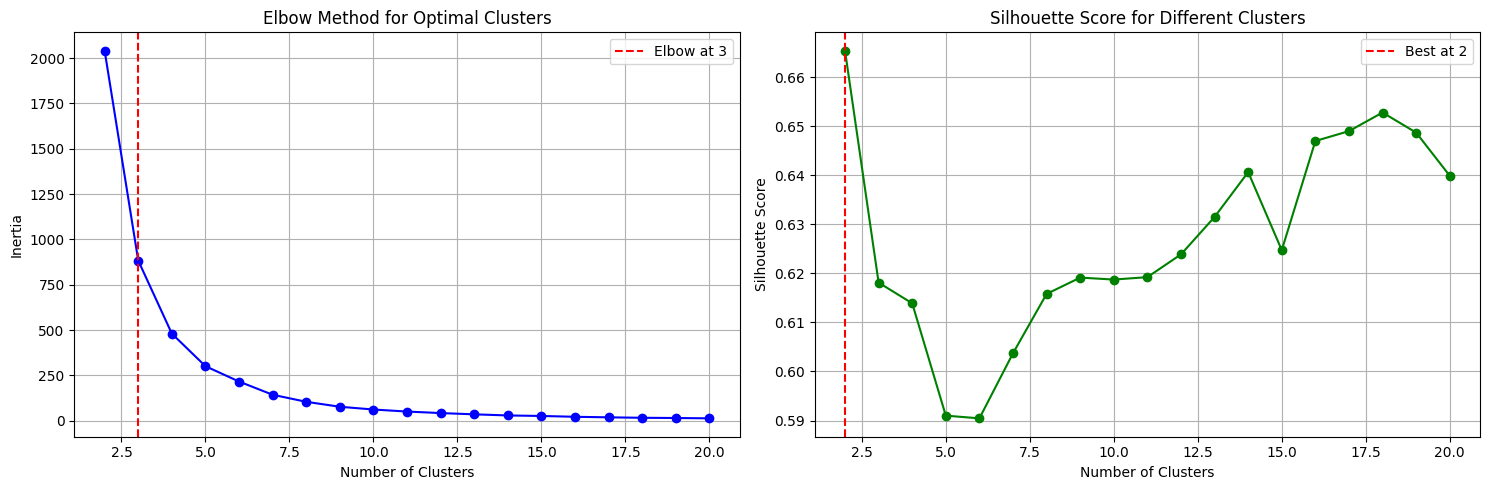

Assigning 4 records with missing operators to nearest cluster...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399913 entries, 0 to 399912
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   api_no_10               399913 non-null  object        
 1   gas_monthly_mean        399913 non-null  float64       
 2   gas_monthly_median      399913 non-null  float64       
 3   gas_monthly_max         399913 non-null  float64       
 4   oil_monthly_mean        399913 non-null  float64       
 5   oil_monthly_median      399913 non-null  float64       
 6   oil_monthly_max         399913 non-null  float64       
 7   horizontal_length       399913 non-null  float64       
 8   measured_depth          399913 non-null  float64       
 9   lat_surface             399913 non-null  float64       
 10  lon_surface             399913 non-null  float64       
 11  lat_bottomhole          39

In [53]:
result_df, clustering_results = create_operator_clusters(well_df)
result_df.info()

In [54]:
result_df['operator_cluster'].value_counts()

operator_cluster
1    321166
0     46189
2     32558
Name: count, dtype: int64

In [55]:
clustering_results

{'optimal_clusters_elbow': 3,
 'optimal_clusters_silhouette': 2,
 'inertias': [2040.7575287183004,
  883.3639282839574,
  480.59147787028866,
  300.86968194728354,
  216.20696175719002,
  143.37825915571875,
  104.49700353339055,
  77.14586297423,
  61.9358347242528,
  50.65550701873297,
  42.33488654025443,
  35.36241261786236,
  29.20279348572342,
  26.314739096264322,
  21.81550008458987,
  18.80147852720184,
  16.35457030562197,
  15.069127037268748,
  13.247687944418091],
 'silhouette_scores': [0.6653728701979977,
  0.618105704611113,
  0.6138903125390707,
  0.5909901697089553,
  0.5904410621150379,
  0.6037084463957291,
  0.6157997248672468,
  0.6191265627606726,
  0.6187300995102395,
  0.6192195091783377,
  0.6238600713295585,
  0.6314866085845233,
  0.6406341142977058,
  0.6247180432331225,
  0.6469718545679305,
  0.6489821575458697,
  0.6527755802325876,
  0.6486773971511592,
  0.6398792109570206],
 'operator_features':                    operator_name   api_no_10  gas_monthly

In [58]:
from sklearn.metrics import silhouette_score

def create_operator_clusters(
    df,
    operator_col='operator_name',
    n_clusters_range=range(2, 21),
    feature_columns=None,
    show_scree_plot=True,
    max_features=5,
    correlation_threshold=0.1,
    sample_fraction=0.1,
    random_state=42
):
    """
    Create operator clusters and show scree plot for optimal cluster selection,
    using features selected by find_most_related_features or manually provided.
    """

    print("✅ Aggregating data by operator...")

    # Example numeric aggregations: adjust to your dataset!
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col != operator_col]

    if not numeric_cols:
        raise ValueError("No numeric columns found to aggregate.")

    operator_features = df.groupby(operator_col)[numeric_cols].mean().reset_index()

    print(f"✅ Aggregated features: {numeric_cols}")

    # Auto-select features if not provided
    if feature_columns is None:
        print("⚙️  Selecting features for clustering...")

        # Instead of supervised, use unsupervised relevance: variance
        variances = operator_features[numeric_cols].var().sort_values(ascending=False)
        variances = variances[variances > 0]  # skip zero variance

        selected = variances.head(max_features).index.tolist()

        if not selected:
            raise ValueError("No suitable features found after variance check.")

        feature_columns = selected
        print(f"✅ Selected features: {feature_columns}")

    else:
        print(f"✅ Using provided feature columns: {feature_columns}")

    # Final cleanup: drop empty or constant
    valid_features = []
    for col in feature_columns:
        s = pd.to_numeric(operator_features[col], errors='coerce')
        if s.notna().sum() == 0:
            print(f"⚠️  Dropping '{col}' — all NaN.")
            continue
        if s.nunique() == 1:
            print(f"⚠️  Dropping '{col}' — constant value.")
            continue
        valid_features.append(col)

    if not valid_features:
        raise ValueError("No valid features left for clustering!")

    feature_columns = valid_features

    # Prepare data
    X = operator_features[feature_columns].apply(pd.to_numeric, errors='coerce').fillna(0).values

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    print("✅ Features prepared and scaled.")

    inertias = []
    silhouette_scores = []
    print("⚙️  Finding optimal cluster count...")

    for n_clusters in n_clusters_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        inertias.append(kmeans.inertia_)
        if len(set(labels)) > 1:
            silhouette_scores.append(silhouette_score(X_scaled, labels))
        else:
            silhouette_scores.append(0)

    def find_elbow_point(inertias):
        if len(inertias) < 3:
            return 0
        second_derivatives = [
            inertias[i - 1] - 2 * inertias[i] + inertias[i + 1]
            for i in range(1, len(inertias) - 1)
        ]
        elbow_idx = np.argmax(second_derivatives) + 1
        return elbow_idx

    elbow_idx = find_elbow_point(inertias)
    optimal_clusters_elbow = list(n_clusters_range)[elbow_idx]
    optimal_clusters_sil = list(n_clusters_range)[np.argmax(silhouette_scores)]

    print(f"✅ Suggested clusters (elbow): {optimal_clusters_elbow}")
    print(f"✅ Suggested clusters (silhouette): {optimal_clusters_sil}")

    if show_scree_plot:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.plot(list(n_clusters_range), inertias, 'bo-')
        ax1.axvline(optimal_clusters_elbow, color='r', linestyle='--', label=f'Elbow at {optimal_clusters_elbow}')
        ax1.set_title('Elbow Method')
        ax1.set_xlabel('Number of Clusters')
        ax1.set_ylabel('Inertia')
        ax1.grid(True)
        ax1.legend()

        ax2.plot(list(n_clusters_range), silhouette_scores, 'go-')
        ax2.axvline(optimal_clusters_sil, color='r', linestyle='--', label=f'Best Silhouette at {optimal_clusters_sil}')
        ax2.set_title('Silhouette Scores')
        ax2.set_xlabel('Number of Clusters')
        ax2.set_ylabel('Silhouette Score')
        ax2.grid(True)
        ax2.legend()

        plt.tight_layout()
        plt.show()

    # Final clustering using elbow clusters
    final_kmeans = KMeans(n_clusters=optimal_clusters_elbow, random_state=random_state, n_init=10)
    final_labels = final_kmeans.fit_predict(X_scaled)
    operator_features['cluster'] = final_labels

    result_df = df.copy()
    cluster_map = dict(zip(operator_features[operator_col], operator_features['cluster']))

    result_df['operator_cluster'] = result_df[operator_col].map(cluster_map)

    missing = result_df['operator_cluster'].isna().sum()
    if missing > 0:
        print(f"⚠️  {missing} rows missing a cluster. Assigning most common cluster.")
        most_common = operator_features['cluster'].mode().iloc[0]
        result_df['operator_cluster'].fillna(most_common, inplace=True)

    clustering_results = {
        'optimal_clusters_elbow': optimal_clusters_elbow,
        'optimal_clusters_silhouette': optimal_clusters_sil,
        'inertias': inertias,
        'silhouette_scores': silhouette_scores,
        'operator_features': operator_features,
        'feature_columns': feature_columns,
        'cluster_centers': final_kmeans.cluster_centers_,
        'n_operators': len(operator_features)
    }

    print("✅ Clustering complete.")

    return result_df, clustering_results

✅ Aggregating data by operator...
✅ Aggregated features: ['gas_monthly_mean', 'gas_monthly_median', 'gas_monthly_max', 'oil_monthly_mean', 'oil_monthly_median', 'oil_monthly_max', 'horizontal_length', 'measured_depth', 'lat_surface', 'lon_surface', 'lat_bottomhole', 'lon_bottomhole']
⚙️  Selecting features for clustering...
✅ Selected features: ['gas_monthly_max', 'gas_monthly_mean', 'gas_monthly_median', 'oil_monthly_max', 'measured_depth']
✅ Features prepared and scaled.
⚙️  Finding optimal cluster count...
✅ Suggested clusters (elbow): 4
✅ Suggested clusters (silhouette): 2


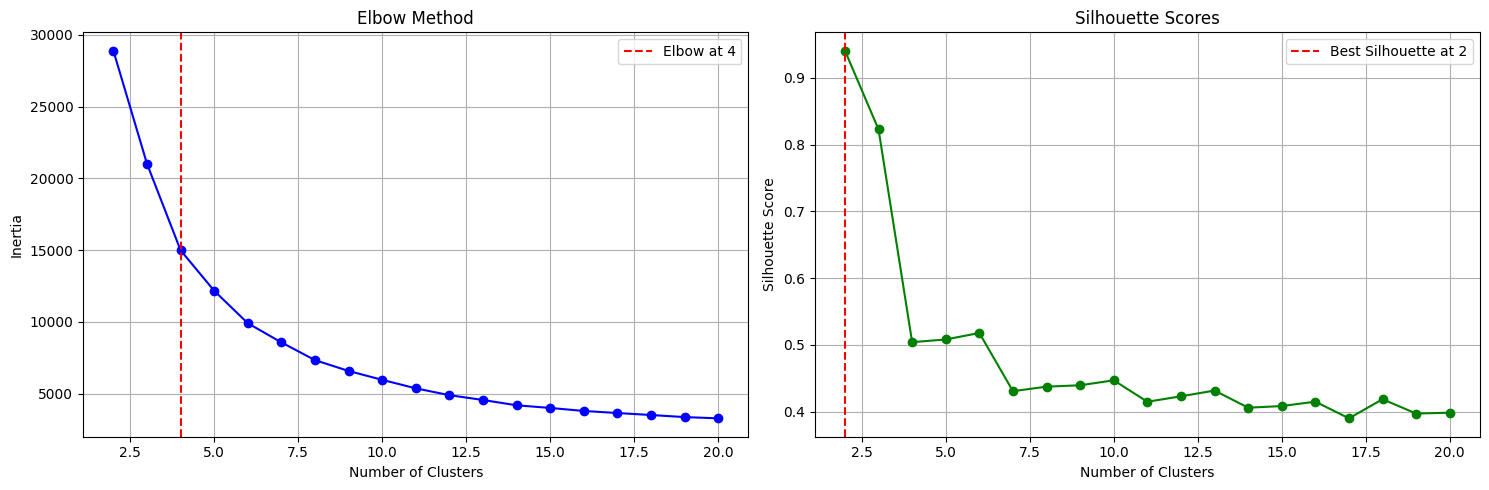

⚠️  4 rows missing a cluster. Assigning most common cluster.
✅ Clustering complete.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399913 entries, 0 to 399912
Data columns (total 22 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   api_no_10               399913 non-null  object        
 1   gas_monthly_mean        399913 non-null  float64       
 2   gas_monthly_median      399913 non-null  float64       
 3   gas_monthly_max         399913 non-null  float64       
 4   oil_monthly_mean        399913 non-null  float64       
 5   oil_monthly_median      399913 non-null  float64       
 6   oil_monthly_max         399913 non-null  float64       
 7   horizontal_length       399913 non-null  float64       
 8   measured_depth          399913 non-null  float64       
 9   lat_surface             399913 non-null  float64       
 10  lon_surface             399913 non-null  float64       
 11  lat_bot

In [59]:
result_df_2, clustering_results_2 = create_operator_clusters(well_df)
result_df.info()

There's a lot of interesting structure to these different clustering methods that I'd love to explore more. The first one, in which I did feature selection based on the operator names, had higher silhouette scores for some higher clustering values, whereas the second option which clustered based primarily around the variance of quantitative features has higher scores but a smoother curve that seems to lose some structure (although that may partly be just a matter of appearance because of the much higher range of values in the second smoother curve approach). I'm going to go with the smoother curve for now since that approach was based on fixing errors, but I'd love to explore a feature like this as a hyperparameter later on

In [60]:
joined_data.drop(columns=['operator_name'], axis=1, inplace=True)
joined_data = joined_data.merge(
        result_df[['api_no_10', 'operator_cluster']],
        how='left',
        on='api_no_10'
    )

joined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 26 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   wellbore_type           object        
 8   Quality_Quant           float64       
 9   Production_Age          int32         
 10  Last_Report             datetime64[ms]
 11  Well_Production_Type    object        
 12  reservoir type          object        
 13  arps model              object        
 14  Production_Status       object        
 15  lat_surface             float64       
 16  lon_surface             float64       
 17  lat_bottomhole          float64       
 18  

In [61]:
joined_data.to_parquet('../data/feature_data_11.parquet')

I accidentally saved the wrong clusters, I wanted the smoother curve

In [62]:
joined_data.drop(columns=['operator_cluster'], axis=1, inplace=True)
joined_data = joined_data.merge(
        result_df_2[['api_no_10', 'operator_cluster']],
        how='left',
        on='api_no_10'
    )

joined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 26 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   wellbore_type           object        
 8   Quality_Quant           float64       
 9   Production_Age          int32         
 10  Last_Report             datetime64[ms]
 11  Well_Production_Type    object        
 12  reservoir type          object        
 13  arps model              object        
 14  Production_Status       object        
 15  lat_surface             float64       
 16  lon_surface             float64       
 17  lat_bottomhole          float64       
 18  

In [63]:
joined_data.to_parquet('../data/feature_data_12.parquet')

In [64]:
data_quality_assessment({'joined_data': joined_data})


DATA QUALITY ASSESSMENT: JOINED_DATA
Missing Values Analysis:
Column                    Missing Count   Missing % 
--------------------------------------------------

Overall Missing Data Summary:
  Total missing cells: 0
  Total cells: 431,698,540
  Overall missing percentage: 0.00%

Duplicate Analysis:
  Total duplicate rows: 0
  Duplicate percentage: 0.00%
  API number duplicates: 16203877


{'joined_data': {'total_rows': 16603790,
  'total_missing': 0,
  'missing_percentage': 0.0,
  'duplicate_rows': 0,
  'duplicate_percentage': 0.0}}

With no more missing values, we can impute the last Well Density features and pre-process the data for machine learning

#### Well Density <a id="Density"></a>

In [6]:
temp_file_paths = {
    'joined_data': '../data/feature_data_12.parquet'
}

temp_file_paths

{'joined_data': '../data/feature_data_12.parquet'}

In [7]:
joined_data = load_parquet_datasets(temp_file_paths)['joined_data']

joined_data.info()

  Successfully loaded joined_data with pandas
  Shape: (16603790, 26)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 26 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   wellbore_type           object        
 8   Quality_Quant           float64       
 9   Production_Age          int32         
 10  Last_Report             datetime64[ms]
 11  Well_Production_Type    object        
 12  reservoir type          object        
 13  arps model              object        
 14  Production_Status       object        
 15  lat_surface             float64       
 16  lon_surface       

In [8]:
def fast_parent_child_density_features(
    df,
    lat_col='lat_surface',
    lon_col='lon_surface',
    start_date_col='start_date',
    api_col='api_no_10',
    max_distance_km=1.0,
    min_time_gap_days=30,
    batch_size=1000,
    device=None
):
    """
    Fast parent-child and density feature creation using PyTorch for large well datasets.
    Only returns a few key features.
    """
    # Aggregate to well-level
    well_data = df.groupby(api_col).agg({
        lat_col: 'first',
        lon_col: 'first',
        start_date_col: 'first'
    }).reset_index()
    well_data = well_data.dropna(subset=[lat_col, lon_col, start_date_col]).copy()
    well_data[start_date_col] = pd.to_datetime(well_data[start_date_col])
    n_wells = len(well_data)
    print(f"Processing {n_wells} wells with complete data...")

    # Prepare coordinates as torch tensors
    lat = torch.tensor(well_data[lat_col].values, dtype=torch.float32)
    lon = torch.tensor(well_data[lon_col].values, dtype=torch.float32)
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    lat = lat.to(device)
    lon = lon.to(device)

    # Convert to radians
    lat_rad = lat * np.pi / 180
    lon_rad = lon * np.pi / 180

    # Batchwise distance calculation for memory efficiency
    well_density_1km = np.zeros(n_wells, dtype=int)
    nearest_well_distance_km = np.full(n_wells, np.inf)
    well_generation = np.ones(n_wells, dtype=int)
    parent_well_api = np.array([None]*n_wells)
    start_dates = well_data[start_date_col].values

    for i in range(0, n_wells, batch_size):
        end = min(i + batch_size, n_wells)
        lat1 = lat_rad[i:end].unsqueeze(1)
        lon1 = lon_rad[i:end].unsqueeze(1)
        lat2 = lat_rad.unsqueeze(0)
        lon2 = lon_rad.unsqueeze(0)

        dlat = lat1 - lat2
        dlon = lon1 - lon2
        a = (torch.sin(dlat / 2) ** 2 +
             torch.cos(lat1) * torch.cos(lat2) * torch.sin(dlon / 2) ** 2)
        c = 2 * torch.atan2(torch.sqrt(a), torch.sqrt(1 - a))
        dists = 6371 * c  # km

        dists_np = dists.cpu().numpy()
        # Well density within 1km (excluding self)
        well_density_1km[i:end] = (dists_np <= 1.0).sum(axis=1) - 1
        # Nearest well distance (excluding self)
        dists_np[dists_np == 0] = np.inf
        nearest_well_distance_km[i:end] = dists_np.min(axis=1)

        # Parent-child (generation) assignment
        for idx_in_batch, idx_global in enumerate(range(i, end)):
            # Find all wells within max_distance_km and earlier in time
            mask = (dists_np[idx_in_batch] <= max_distance_km) & \
                   (start_dates[idx_global] > start_dates)
            if np.any(mask):
                # Find the closest earlier well (parent)
                parent_idx = np.where(mask)[0][np.argmin(dists_np[idx_in_batch][mask])]
                parent_well_api[idx_global] = well_data.iloc[parent_idx][api_col]
                well_generation[idx_global] = well_generation[parent_idx] + 1

    # Assign features back to DataFrame
    well_data['well_generation'] = well_generation
    well_data['parent_well_api'] = parent_well_api
    well_data['well_density_1km'] = well_density_1km
    well_data['nearest_well_distance_km'] = nearest_well_distance_km

    # Map back to original DataFrame
    result_df = df.copy()
    for col in ['well_generation', 'parent_well_api', 'well_density_1km', 'nearest_well_distance_km']:
        mapping = dict(zip(well_data[api_col], well_data[col]))
        result_df[col] = result_df[api_col].map(mapping)

    # Summary stats
    stats = {
        'n_wells': n_wells,
        'max_generation': well_data['well_generation'].max(),
        'mean_density_1km': well_data['well_density_1km'].mean(),
        'mean_nearest_distance_km': well_data['nearest_well_distance_km'].mean()
    }
    return result_df, stats

In [67]:
well_df = get_well_level_aggregation_tvd(joined_data, api_col='api_no_10')
well_df.info()

KeyError: "Column(s) ['operator_name'] do not exist"

In [9]:
def get_well_level_aggregation(df, api_col='api_no_10'):
    """
    Aggregate time series data to well-level (one row per well) for feature engineering.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Time series dataframe
    api_col : str
        Well API column name
        
    Returns:
    --------
    pandas.DataFrame : Well-level aggregated dataframe
    """
    well_level = df.groupby(api_col).agg({
        'gas_monthly': ['mean', 'median', 'max'],
        'oil_monthly': ['mean', 'median', 'max'],
        'horizontal_length': 'first',
        'measured_depth': 'first',
        'lat_surface': 'first',
        'lon_surface': 'first',
        'lat_bottomhole': 'first',
        'lon_bottomhole': 'first',
        'wellbore_type': 'first',
        'reservoir type': 'first',
        'arps model': 'first',
        'start_date': 'first',
        'basin': 'first',
        'formation_standardized': 'first',
        'formation_group': 'first'
    }).reset_index()

    well_level.columns = [
        'api_no_10',
        'gas_monthly_mean',
        'gas_monthly_median',
        'gas_monthly_max',
        'oil_monthly_mean',
        'oil_monthly_median',
        'oil_monthly_max',
        'horizontal_length',
        'measured_depth',
        'lat_surface',
        'lon_surface',
        'lat_bottomhole',
        'lon_bottomhole',
        'wellbore_type',
        'reservoir type',
        'arps model',
        'start_date',
        'basin',
        'formation_standardized',
        'formation_group'
                         ]
    
    return well_level

In [10]:
well_df = get_well_level_aggregation(joined_data, api_col='api_no_10')
well_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399913 entries, 0 to 399912
Data columns (total 20 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   api_no_10               399913 non-null  object        
 1   gas_monthly_mean        399913 non-null  float64       
 2   gas_monthly_median      399913 non-null  float64       
 3   gas_monthly_max         399913 non-null  float64       
 4   oil_monthly_mean        399913 non-null  float64       
 5   oil_monthly_median      399913 non-null  float64       
 6   oil_monthly_max         399913 non-null  float64       
 7   horizontal_length       399913 non-null  float64       
 8   measured_depth          399913 non-null  float64       
 9   lat_surface             399913 non-null  float64       
 10  lon_surface             399913 non-null  float64       
 11  lat_bottomhole          399913 non-null  float64       
 12  lon_bottomhole          399913

In [11]:
result_df, stats = fast_parent_child_density_features(well_df)
result_df.info()

Processing 399913 wells with complete data...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399913 entries, 0 to 399912
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   api_no_10                 399913 non-null  object        
 1   gas_monthly_mean          399913 non-null  float64       
 2   gas_monthly_median        399913 non-null  float64       
 3   gas_monthly_max           399913 non-null  float64       
 4   oil_monthly_mean          399913 non-null  float64       
 5   oil_monthly_median        399913 non-null  float64       
 6   oil_monthly_max           399913 non-null  float64       
 7   horizontal_length         399913 non-null  float64       
 8   measured_depth            399913 non-null  float64       
 9   lat_surface               399913 non-null  float64       
 10  lon_surface               399913 non-null  float64       
 11  lat_bottomhole     

In [12]:
result_df.to_parquet('../data/final_feature_helper.parquet')

In [13]:
stats

{'n_wells': 399913,
 'max_generation': 17,
 'mean_density_1km': 29.664021924768637,
 'mean_nearest_distance_km': 0.26866235177188463}

In [14]:
result_df['parent_well_api'].head()

0          None
1          None
2    4200100046
3          None
4    4200100074
Name: parent_well_api, dtype: object

In [15]:
result_df['parent_well_api'].nunique()

136727

I don't think we need another api feature because I'm not even sure there is such a deterministic dependence between parent and child and it's a high dimensional categorical feature that could cause problems for the model. But I will add the other features to the joined data and explore them a bit, then we can move on to pre-processing.

In [16]:
joined_data = joined_data.merge(
        result_df[['api_no_10', 'well_generation']],
        how='left',
        on='api_no_10'
    )

joined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 27 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   wellbore_type           object        
 8   Quality_Quant           float64       
 9   Production_Age          int32         
 10  Last_Report             datetime64[ms]
 11  Well_Production_Type    object        
 12  reservoir type          object        
 13  arps model              object        
 14  Production_Status       object        
 15  lat_surface             float64       
 16  lon_surface             float64       
 17  lat_bottomhole          float64       
 18  

In [18]:
joined_data = joined_data.merge(
        result_df[['api_no_10', 'well_density_1km']],
        how='left',
        on='api_no_10'
    )

joined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 28 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   date_prod               datetime64[ms]
 1   api_no_10               object        
 2   gas_monthly             float64       
 3   oil_monthly             float64       
 4   start_date              datetime64[ns]
 5   county                  object        
 6   sub_region              object        
 7   wellbore_type           object        
 8   Quality_Quant           float64       
 9   Production_Age          int32         
 10  Last_Report             datetime64[ms]
 11  Well_Production_Type    object        
 12  reservoir type          object        
 13  arps model              object        
 14  Production_Status       object        
 15  lat_surface             float64       
 16  lon_surface             float64       
 17  lat_bottomhole          float64       
 18  

In [20]:
joined_data = joined_data.merge(
        result_df[['api_no_10', 'nearest_well_distance_km']],
        how='left',
        on='api_no_10'
    )

joined_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16603790 entries, 0 to 16603789
Data columns (total 29 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   date_prod                 datetime64[ms]
 1   api_no_10                 object        
 2   gas_monthly               float64       
 3   oil_monthly               float64       
 4   start_date                datetime64[ns]
 5   county                    object        
 6   sub_region                object        
 7   wellbore_type             object        
 8   Quality_Quant             float64       
 9   Production_Age            int32         
 10  Last_Report               datetime64[ms]
 11  Well_Production_Type      object        
 12  reservoir type            object        
 13  arps model                object        
 14  Production_Status         object        
 15  lat_surface               float64       
 16  lon_surface               float64       
 17  lat_bo

In [21]:
joined_data.to_parquet('../data/feature_data_13.parquet')

In [22]:
result_df['well_generation'].describe()

count    399913.000000
mean          1.993038
std           1.174781
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max          17.000000
Name: well_generation, dtype: float64

In [23]:
result_df['well_density_1km'].describe()

count    399913.000000
mean         29.664022
std          46.320201
min           0.000000
25%           7.000000
50%          16.000000
75%          34.000000
max         779.000000
Name: well_density_1km, dtype: float64

In [24]:
result_df['nearest_well_distance_km'].describe()

count    399913.000000
mean          0.268662
std           0.606002
min           0.000190
25%           0.082024
50%           0.196633
75%           0.347543
max         266.492950
Name: nearest_well_distance_km, dtype: float64